In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

# Static inline plots
%matplotlib inline

# Interactive plots
# %matplotlib notebook

# Load all packages used
import matplotlib.pyplot as plt
import numpy as np
import mypackage
import joblib

timer = mypackage.Timer()

TensorFlow version is 2.1.0


Using TensorFlow backend.


In [2]:
# First load the labeled data and train on it
X, Y, info = mypackage.Dataset.load("data/tomra_all", only_with_contaminant=True)

X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = mypackage.Dataset.train_test_split(X, Y, testRatio=0.3)
X_test_orig, X_train_orig, scaler = mypackage.Dataset.scale(X_test_orig, X_train_orig, scaler='GlobalStandardization')

# save the scaler to disk
filename = 'latest_scaler_used.sav'
joblib.dump(scaler, filename)
# # load the scaler from disk
# scaler = joblib.load(filename)

zoom = lambda X, Y, size, mp, noise=True: mypackage.Dataset.make_zoomed_in_dataset(X, Y, size=size, 
                                                             sample_multiplication=mp, contaminant_type=2,
                                                             zoom_with_noise=noise, flip=True)

In [3]:
######################################################
# Need extra padding for the HybridSN classification
window_size = 25
margin = int((window_size - 1) / 2)
padding = margin * 2
size = 32 + padding

s, m = size, 1
X_train_HS, Y_train_HS = zoom(X_train_orig, Y_train_orig, s, m, noise=False)
X_test_HS,  Y_test_HS  = zoom(X_test_orig,  Y_test_orig,  s, m, noise=False)
#######################################################

# Test HybridSN

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 25, 25, 208, 1)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 23, 23, 68, 8)     512       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 21, 21, 22, 16)    5776      
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 19, 19, 7, 32)     13856     
_________________________________________________________________
reshape_1 (Reshape)          (None, 19, 19, 224)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 64)        129088    
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)             0   

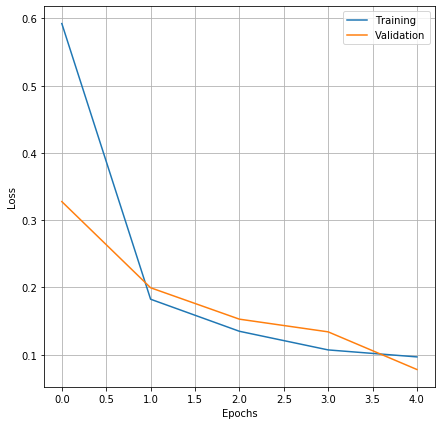

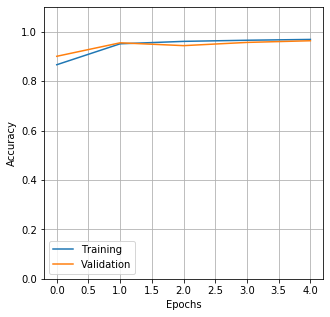

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     33248
         1.0       0.93      0.97      0.95     10029
         2.0       1.00      0.09      0.16       755

    accuracy                           0.97     44032
   macro avg       0.97      0.68      0.70     44032
weighted avg       0.97      0.97      0.97     44032



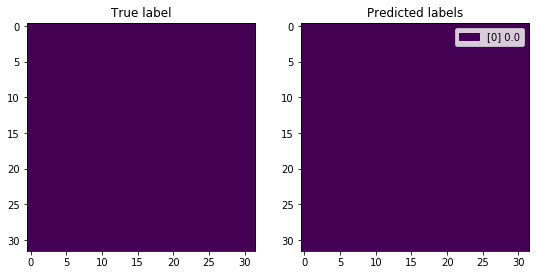

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     12710
         1.0       0.93      0.97      0.95      6281
         2.0       0.99      0.16      0.28       465

    accuracy                           0.96     19456
   macro avg       0.97      0.71      0.74     19456
weighted avg       0.96      0.96      0.96     19456



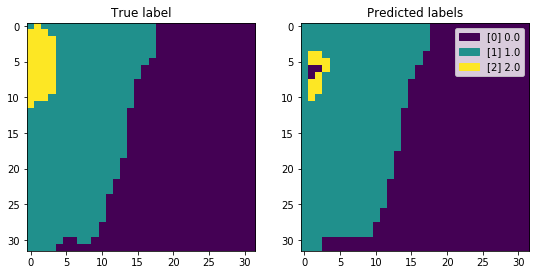

Elapsed time: 197.2047 seconds
Fasle positive blobs 7


In [4]:
n_train = 16 # if 16 then 30min per epoch
n_test  = 4
model = mypackage.HybridSN(X_train_HS, Y_train_HS, X_test_HS, Y_test_HS)
model.summary()

timer.start()
model.train(epochs=5)
timer.stop()

model.plot_training_results()
model.predict(X_train_HS, Y_train_HS)
timer.start()
Y_hat = model.predict(X_test_HS, Y_test_HS)
timer.stop()
print(f"Fasle positive blobs {mypackage.count_false_positive(Y_hat, Y_test_HS)}")

In [5]:
# Moved this here to fix problems with HybridSN
s, m = 32, 30
X_train, Y_train = zoom(X_train_orig, Y_train_orig, s, m)
X_test,  Y_test  = zoom(X_test_orig,  Y_test_orig,  s, m)

print(np.unique(Y_test), Y_test.shape, (X_test.min(), X_test.max()), X_test.shape, X_train.shape)
print(np.unique(Y_train, return_counts=True))
print(np.unique(Y_test, return_counts=True))

[0. 1. 2.] (570, 32, 32, 1) (-7.327864170074463, 9.585556030273438) (570, 32, 32, 208) (1290, 32, 32, 208)
(array([0., 1., 2.]), array([1072956,  231076,   16928]))
(array([0., 1., 2.]), array([477166,  99469,   7045]))


# Testing SVM

In [6]:
# Started the training at ~16:30
# Finished training at ~17:00

In [7]:
Y_train_orig.shape, Y_test_orig.shape

((43, 100, 100, 1), (19, 100, 100, 1))

Start training
Elapsed time: 1262.5831 seconds
Training data prediction
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    364428
           1       0.96      0.97      0.96     60986
           2       0.94      0.69      0.79      4586

    accuracy                           0.99    430000
   macro avg       0.97      0.88      0.92    430000
weighted avg       0.99      0.99      0.99    430000

Test data prediction
Elapsed time: 603.9168 seconds
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    163085
           1       0.96      0.97      0.96     25019
           2       0.94      0.55      0.70      1896

    accuracy                           0.99    190000
   macro avg       0.96      0.84      0.89    190000
weighted avg       0.99      0.99      0.99    190000

Fasle positive blobs 13


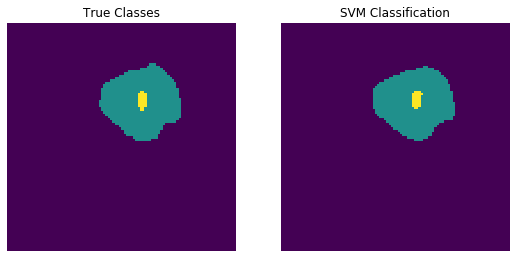

In [8]:
from sklearn import svm
from sklearn.metrics import classification_report

train = mypackage.StackTransform(X_train_orig, Y_train_orig)
test = mypackage.StackTransform(X_test_orig, Y_test_orig)

svc_classifier = svm.SVC(C=1, kernel='rbf', decision_function_shape='ovr')
print("Start training")
timer.start()
svc_classifier.fit(train.X_stack(), train.Y_stack().ravel())
timer.stop()

# save the model to disk
filename = 'latest_svm_model.sav'
joblib.dump(svc_classifier, filename)

# # load the model from disk
# svc_classifier = joblib.load(filename)
Y_hat = svc_classifier.predict(train.X_stack())
classification = classification_report(train.Y_stack(), Y_hat) # .flatten()
print("Training data prediction")
print(classification)
print("Test data prediction")
timer.start()
Y_hat = svc_classifier.predict(test.X_stack())
timer.stop()
classification = classification_report(test.Y_stack(), Y_hat) # .flatten()
print(classification)

Y_hat = test.Unstack(Y_hat, k=1)
print(f"Fasle positive blobs {mypackage.count_false_positive(Y_hat, Y_test_orig)}")

import matplotlib.pyplot as plt
plt.figure(figsize=(9, 5))
plt.subplot(1, 2, 1)
plt.title("True Classes")
plt.imshow(np.squeeze(Y_test_orig[0]))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("SVM Classification")
plt.imshow(np.squeeze(Y_hat[0]))
plt.axis('off');

# Testing Logistic Regression

Start training
Elapsed time: 5138.6059 seconds
Training data prediction
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99   1072956
         1.0       0.96      0.96      0.96    231076
         2.0       0.90      0.78      0.84     16928

    accuracy                           0.99   1320960
   macro avg       0.95      0.91      0.93   1320960
weighted avg       0.99      0.99      0.99   1320960

Test data prediction
Elapsed time: 0.3569 seconds
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    477166
         1.0       0.97      0.96      0.96     99469
         2.0       0.85      0.70      0.76      7045

    accuracy                           0.99    583680
   macro avg       0.94      0.88      0.91    583680
weighted avg       0.99      0.99      0.99    583680

Fasle positive blobs 174


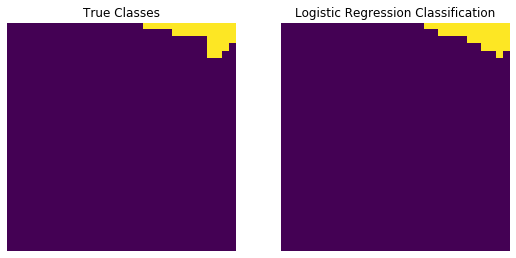

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

train = mypackage.StackTransform(X_train, Y_train)
test = mypackage.StackTransform(X_test, Y_test)

logreg = LogisticRegression(C=1e5, max_iter=50000)
print("Start training")
timer.start()
logreg.fit(train.X_stack(), train.Y_stack().ravel())
timer.stop()

# save the model to disk
filename = 'latest_LogisticReg_model.sav'
joblib.dump(logreg, filename)

# # load the model from disk
# logreg = joblib.load(filename)
Y_hat = logreg.predict(train.X_stack())
classification = classification_report(train.Y_stack(), Y_hat) # .flatten()
print("Training data prediction")
print(classification)
print("Test data prediction")
timer.start()
Y_hat = logreg.predict(test.X_stack())
timer.stop()
classification = classification_report(test.Y_stack(), Y_hat) # .flatten()
print(classification)

Y_hat = test.Unstack(Y_hat, k=1)
print(f"Fasle positive blobs {mypackage.count_false_positive(Y_hat, Y_test)}")

import matplotlib.pyplot as plt
plt.figure(figsize=(9, 5))
plt.subplot(1, 2, 1)
plt.title("True Classes")
plt.imshow(np.squeeze(Y_test[0]))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Logistic Regression Classification")
plt.imshow(np.squeeze(Y_hat[0]))
plt.axis('off');

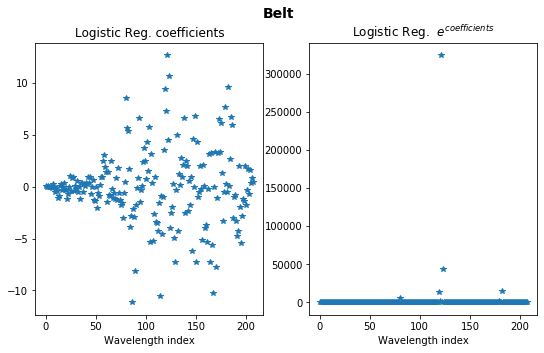

The four most useful wavelengths are: [1364, 1371, 1584, 1357]nm
The corresponding indexes are: [121 123 182 119]


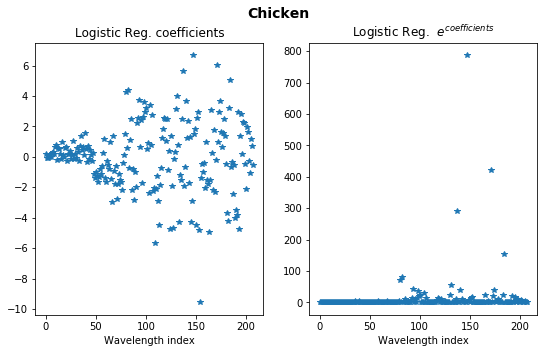

The four most useful wavelengths are: [1458, 1545, 1422, 1591]nm
The corresponding indexes are: [147 171 137 184]


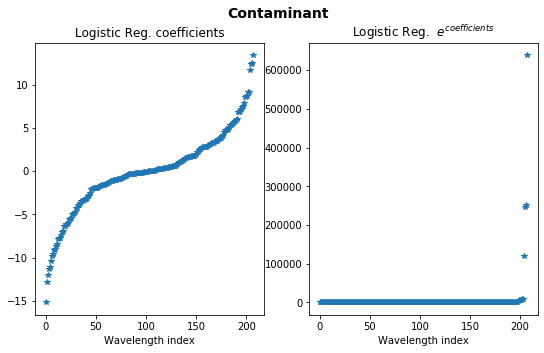

The four most useful wavelengths are: [1674, 1671, 1667, 1664]nm
The corresponding indexes are: [207 206 205 204]


In [57]:
# logit(p) = log(p/(1-p) = \beta_0 + \beta_1*w1+...+ \beta_209*w209
label = {0: 'Belt', 1: 'Chicken', 2: 'Contaminant'}
for i in range(3):
    plt.figure(figsize=(9, 5))
    plt.subplot(121)
    plt.title('Logistic Reg. coefficients')
    plt.plot(logreg.coef_[i, :], '*')
    plt.xlabel("Wavelength index")
    plt.subplot(122)
    plt.title(r'Logistic Reg.  $e^{coefficients}$')
    exp_coef = np.exp(logreg.coef_[i, :])
    plt.plot(exp_coef, '*')
    plt.xlabel("Wavelength index")
#     plt.tight_layout()
    plt.suptitle(label[i], fontsize=14, fontweight='bold')
    plt.show()
    top_index = exp_coef.argsort()[-4:][::-1]
    print(f"The four most useful wavelengths are: {[mypackage.Dataset.TOMRA_WAVELENGTHS[i] for i in top_index]}nm")
    print(f"The corresponding indexes are: {top_index}")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



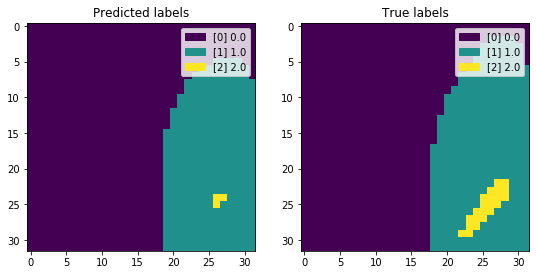

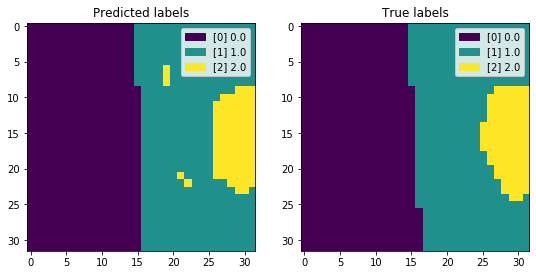

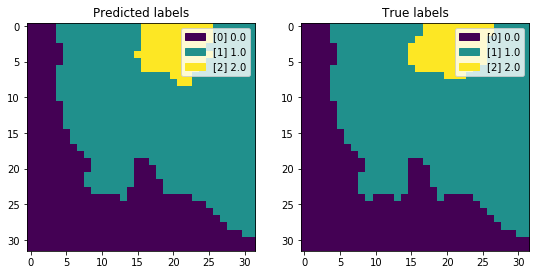

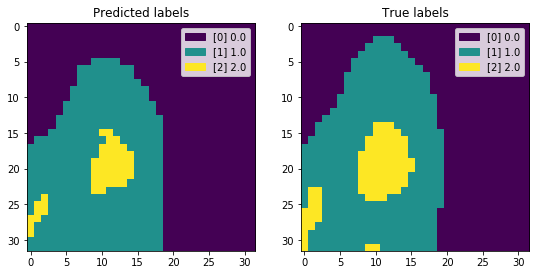

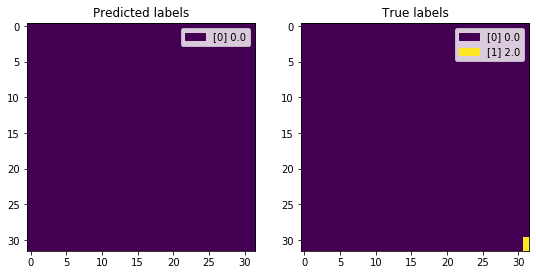

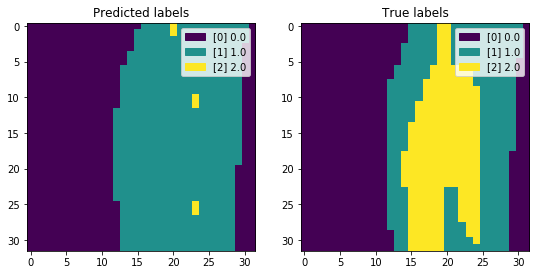

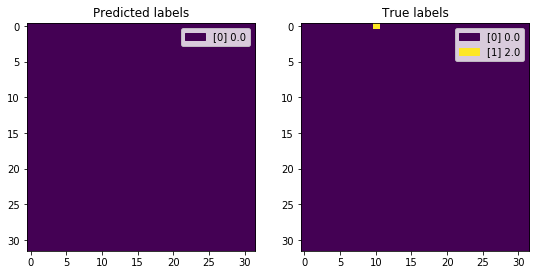

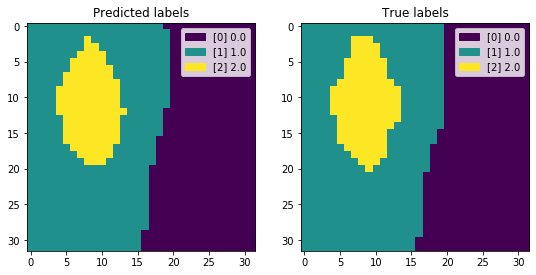

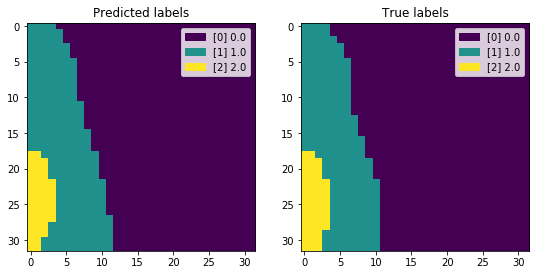

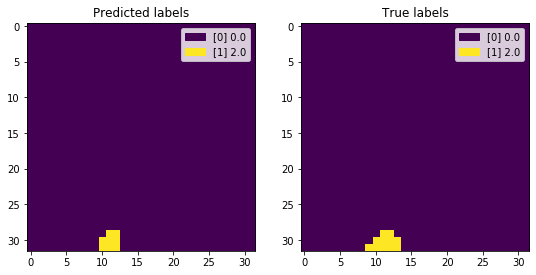

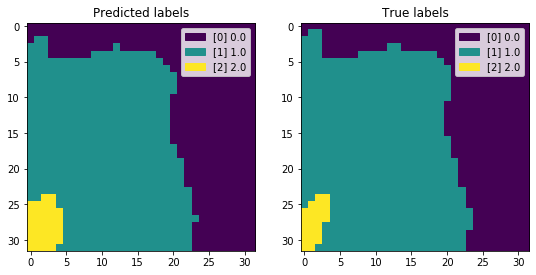

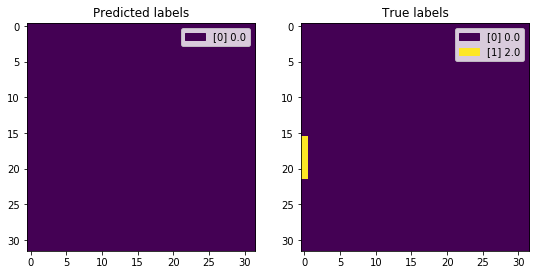

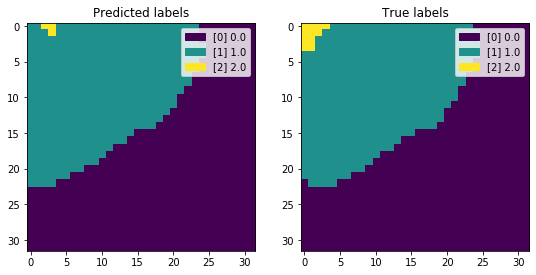

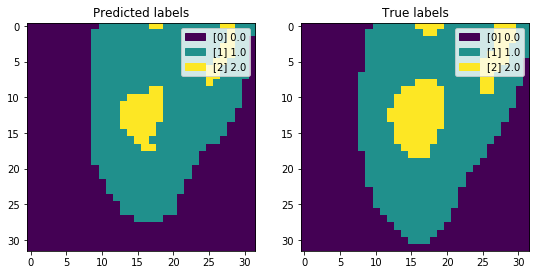

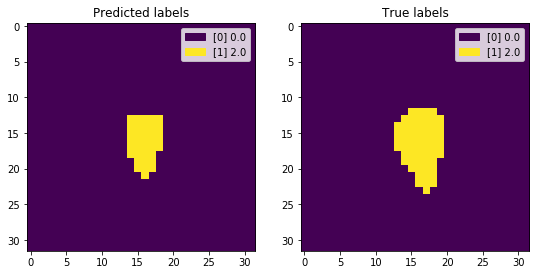

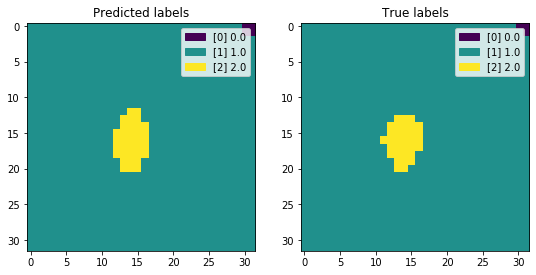

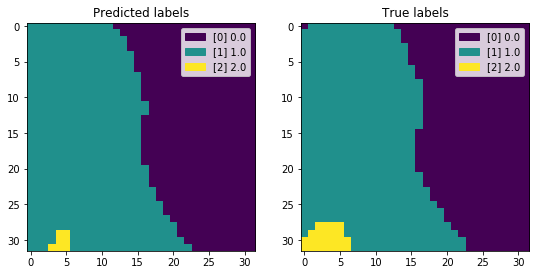

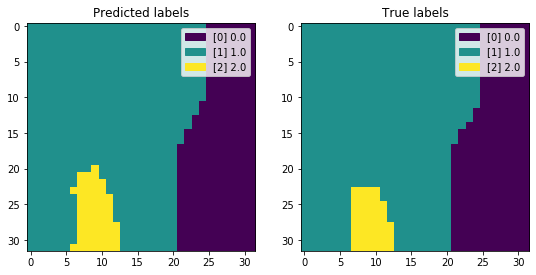

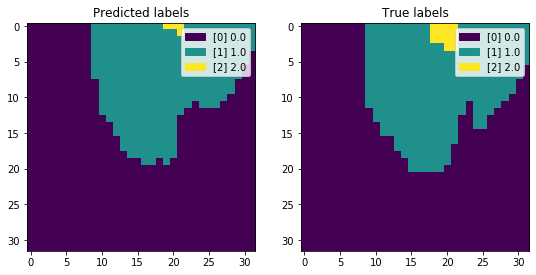

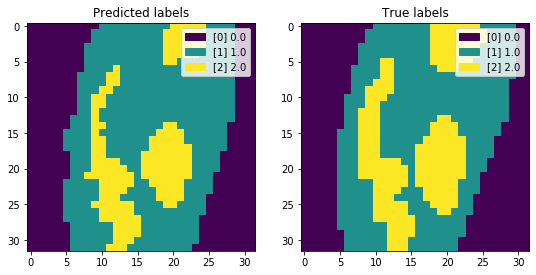

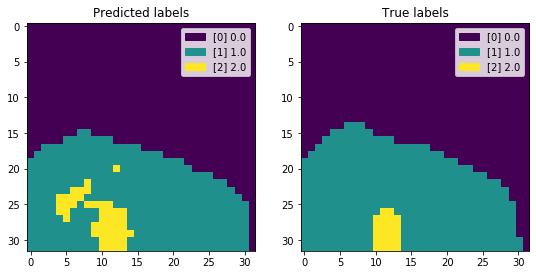

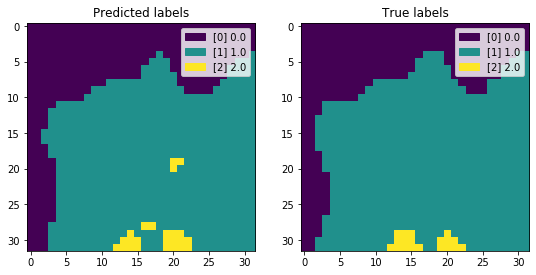

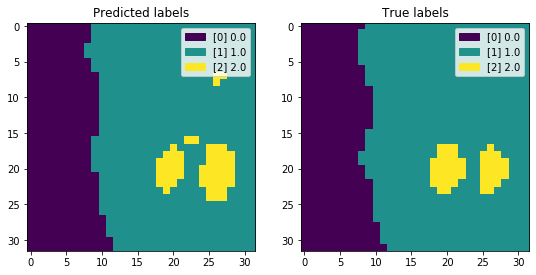

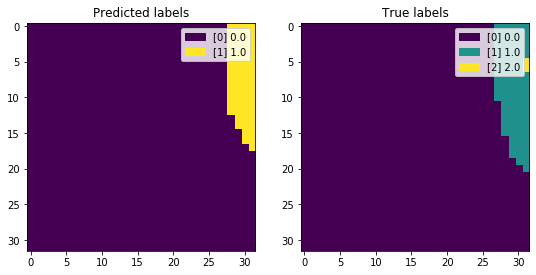

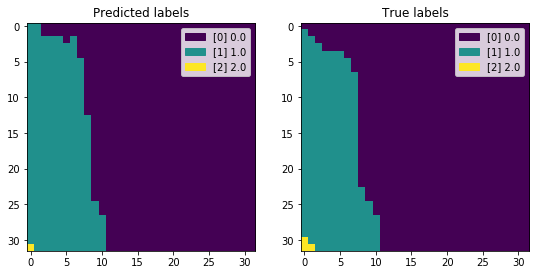

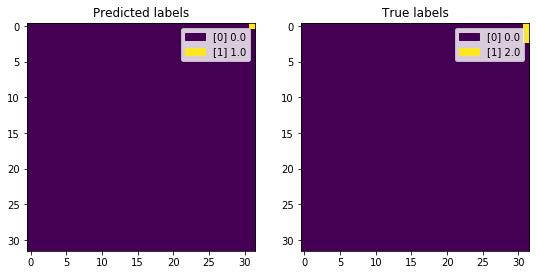

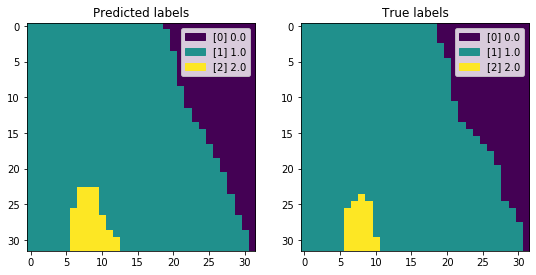

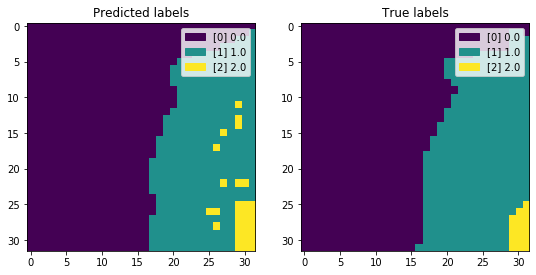

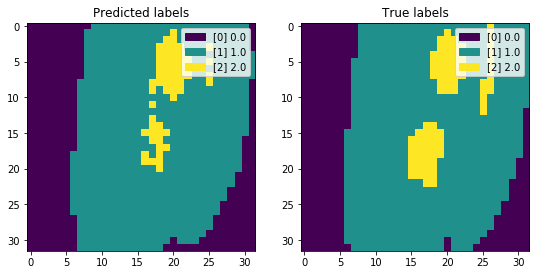

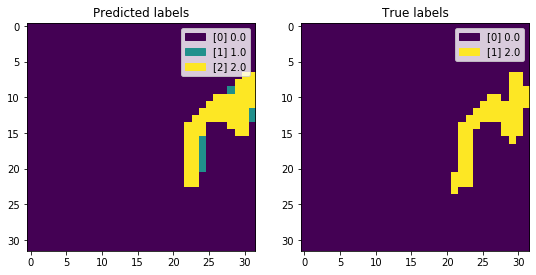

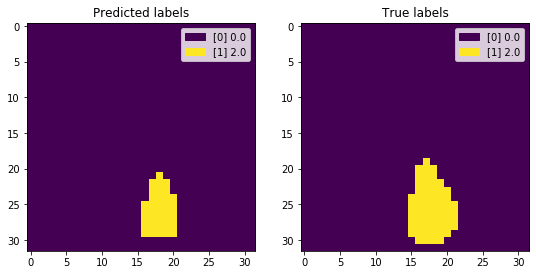

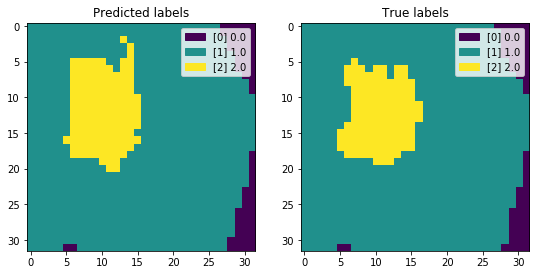

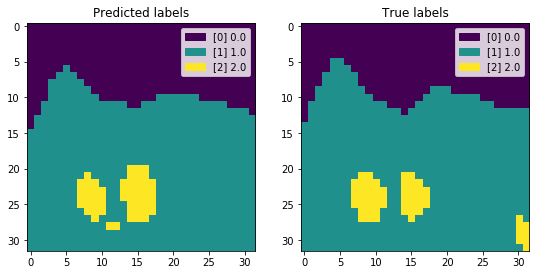

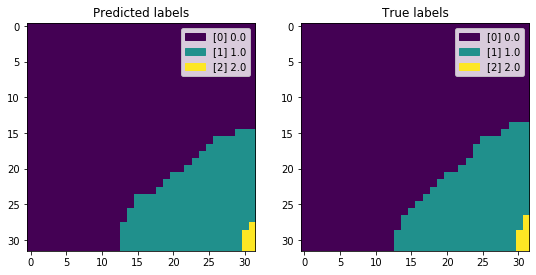

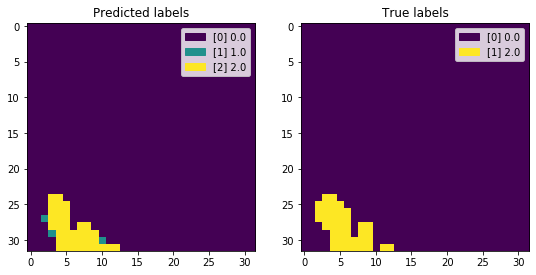

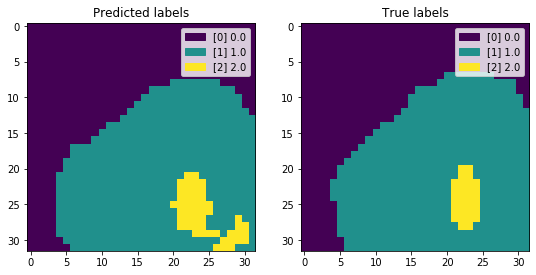

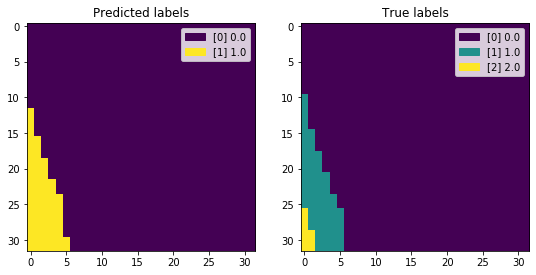

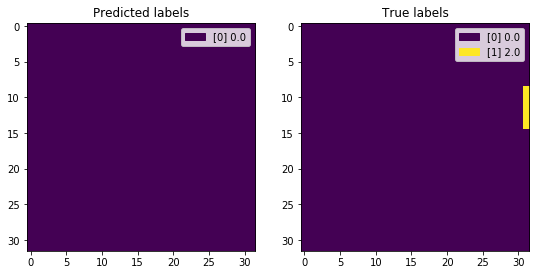

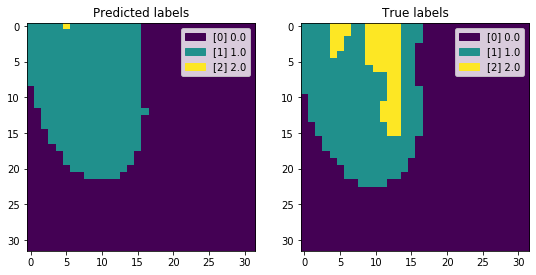

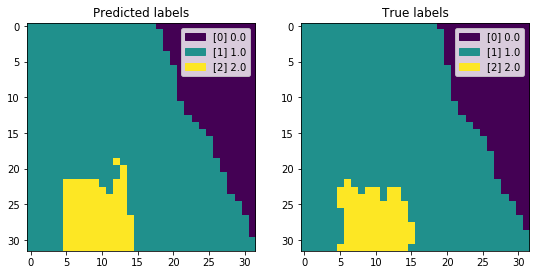

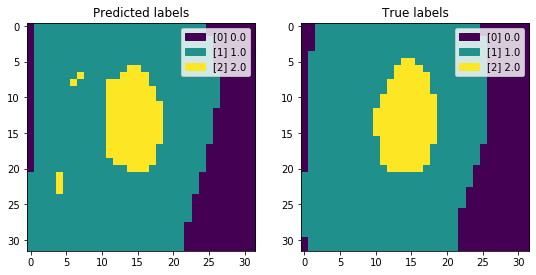

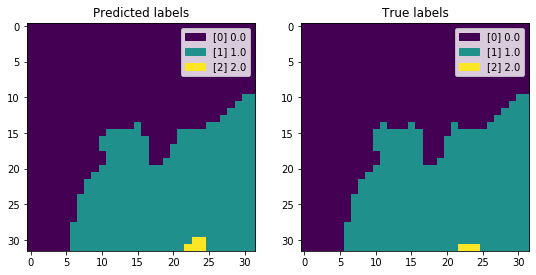

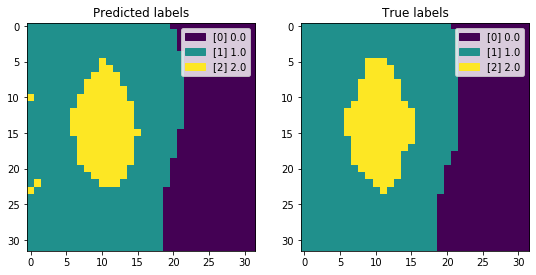

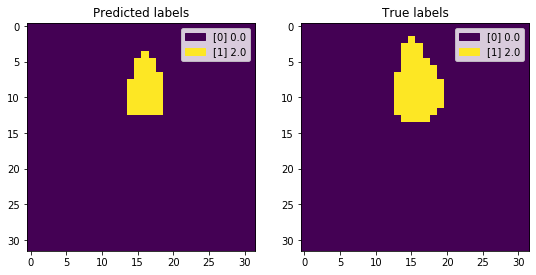

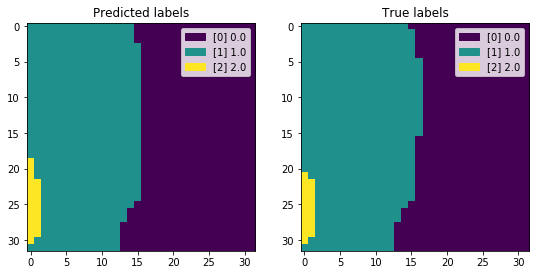

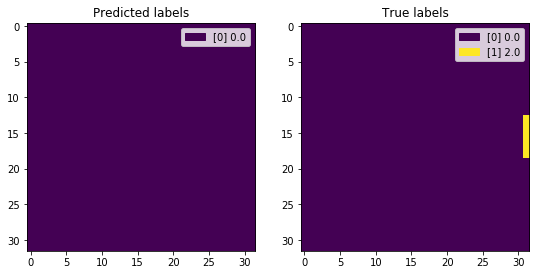

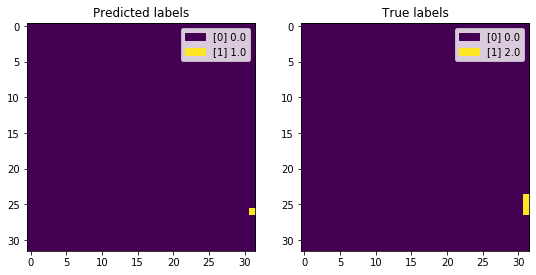

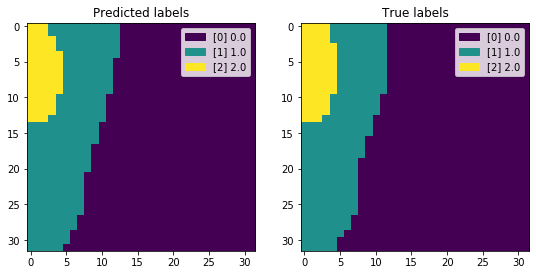

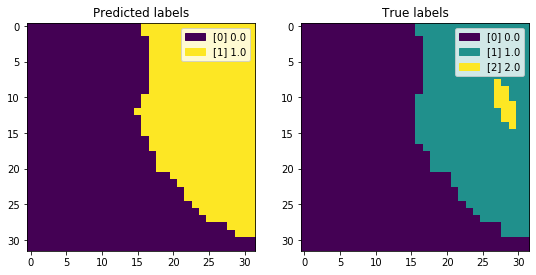

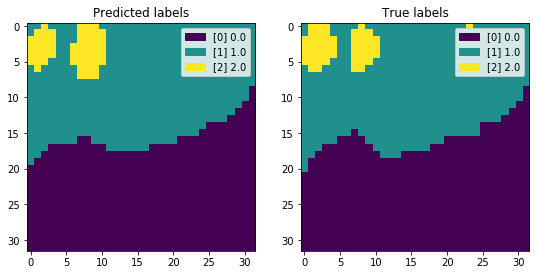

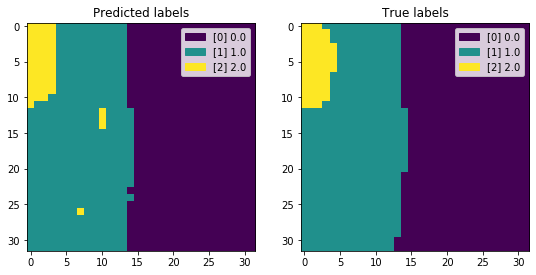

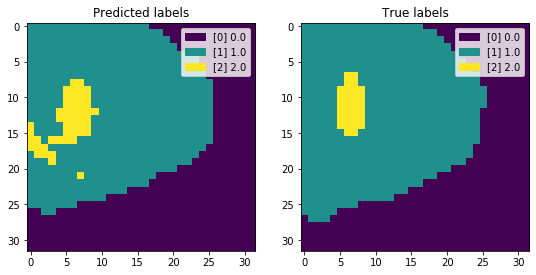

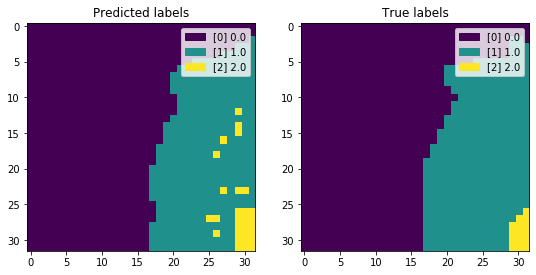

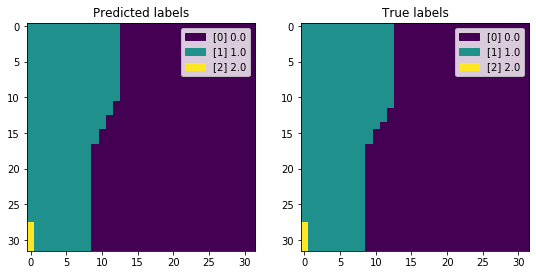

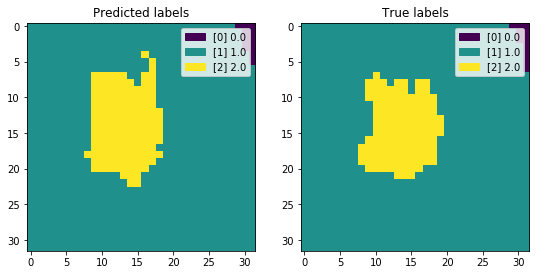

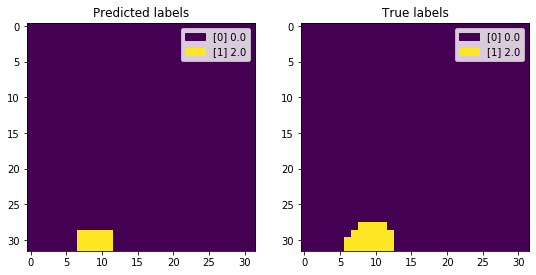

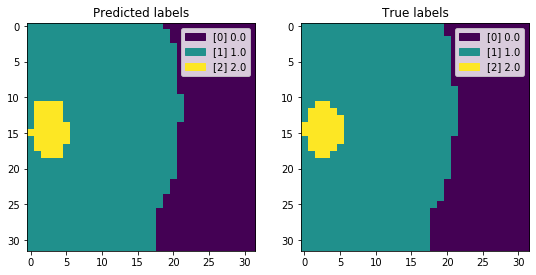

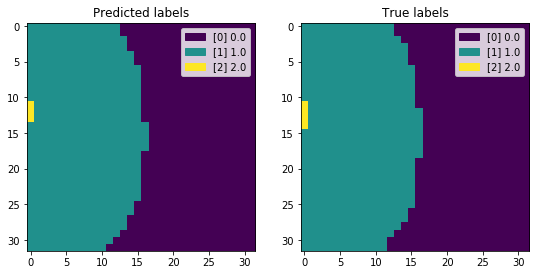

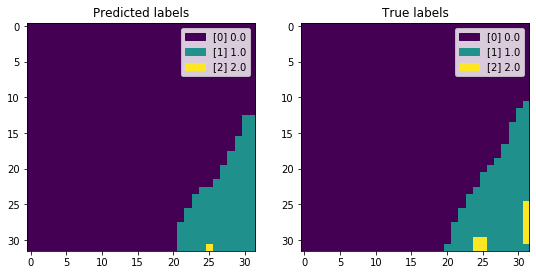

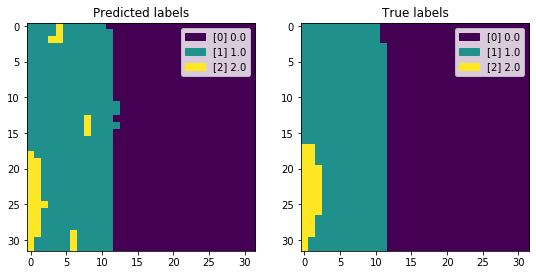

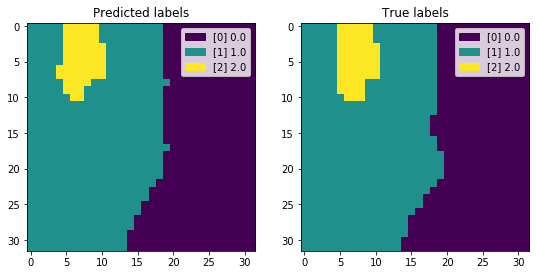

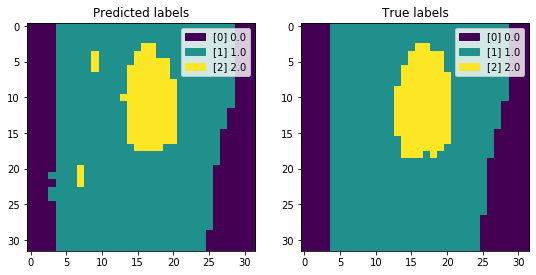

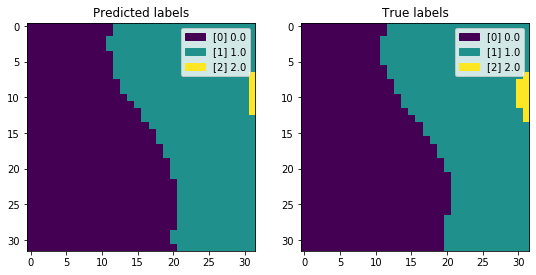

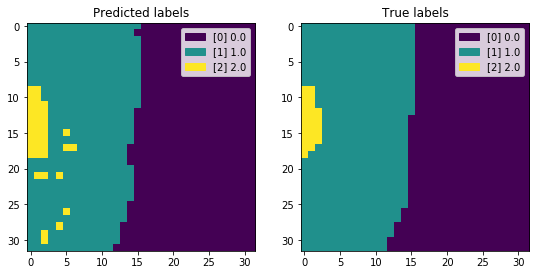

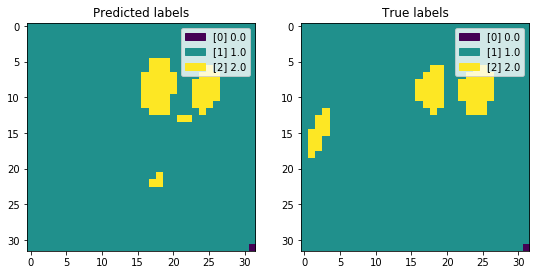

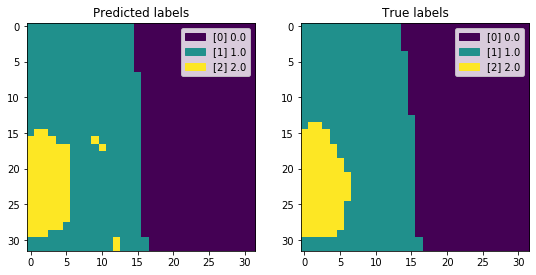

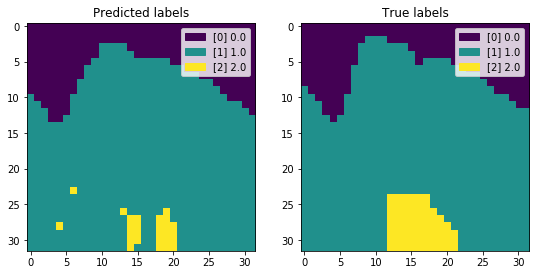

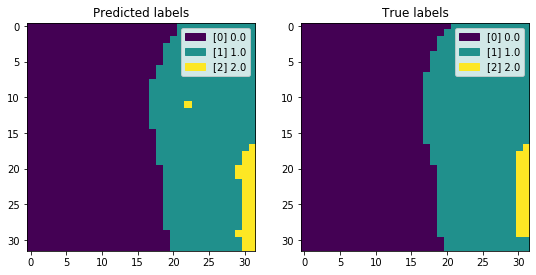

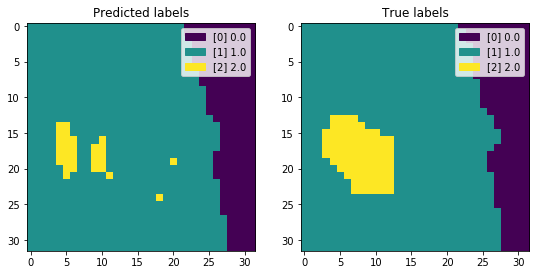

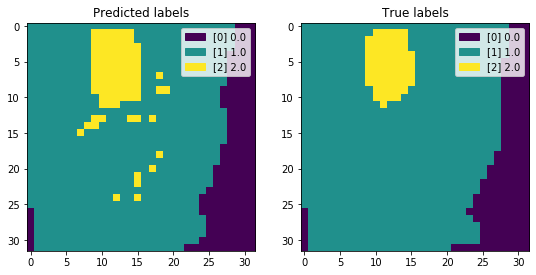

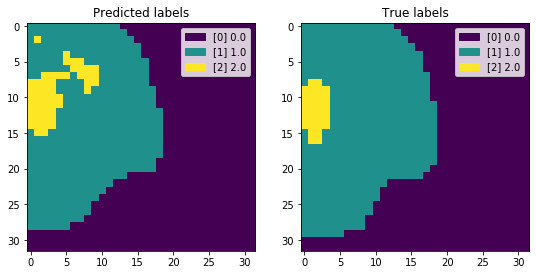

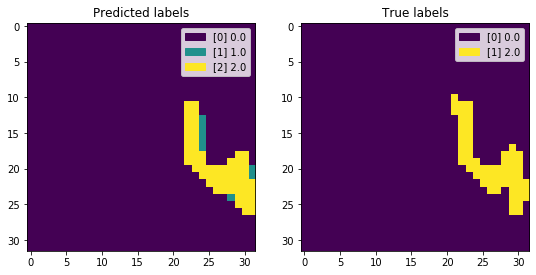

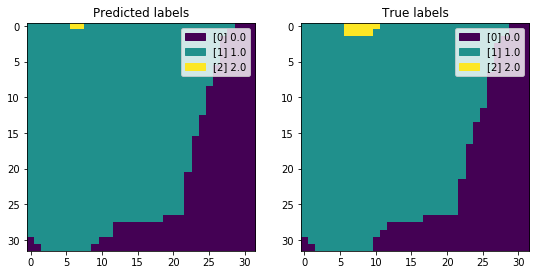

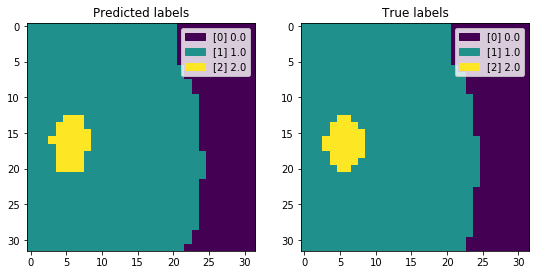

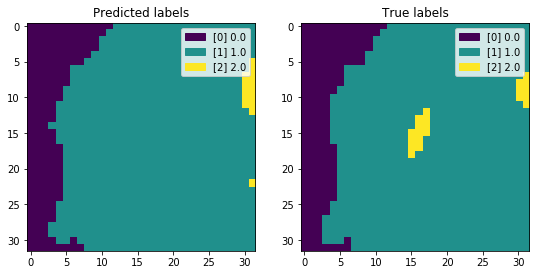

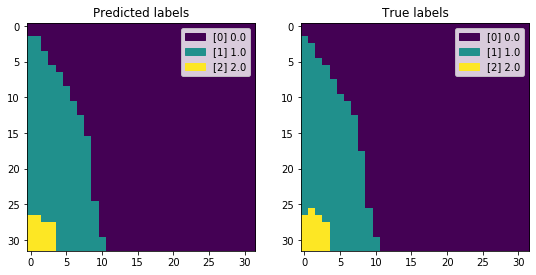

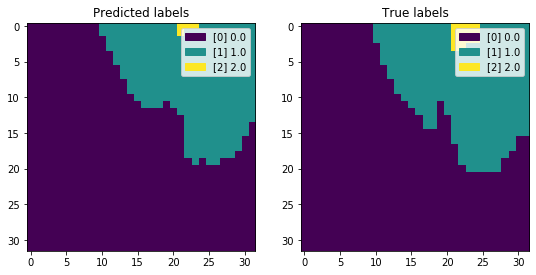

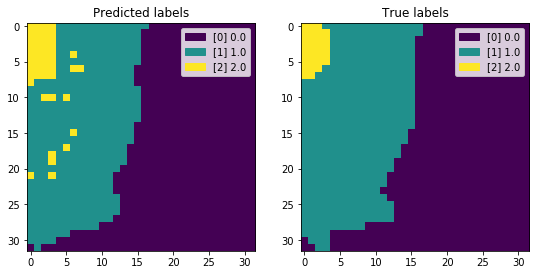

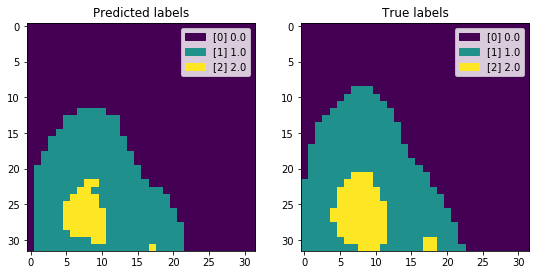

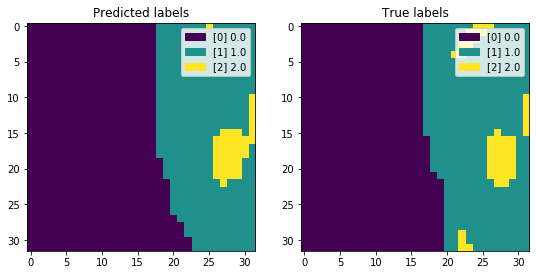

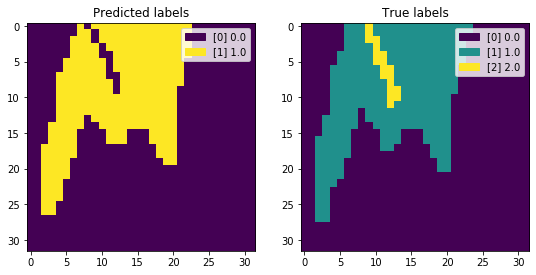

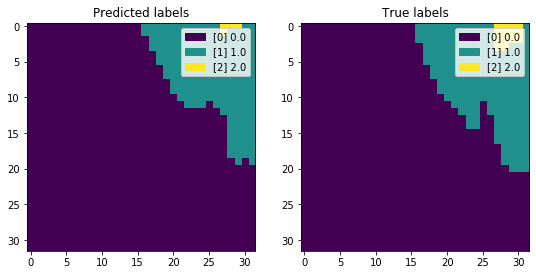

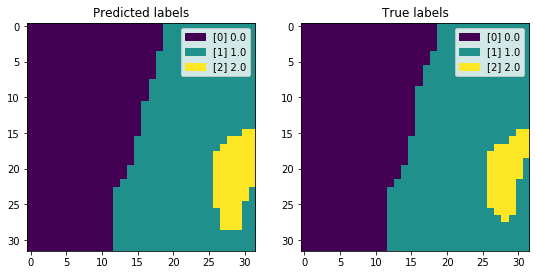

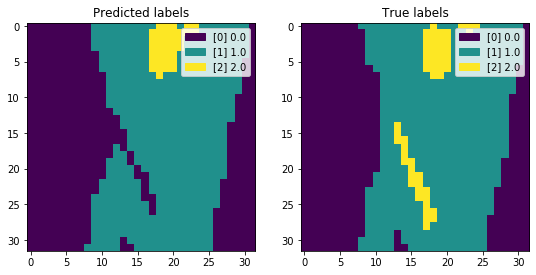

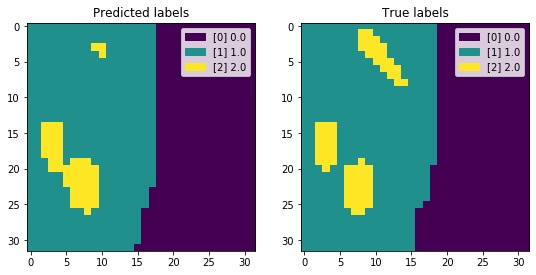

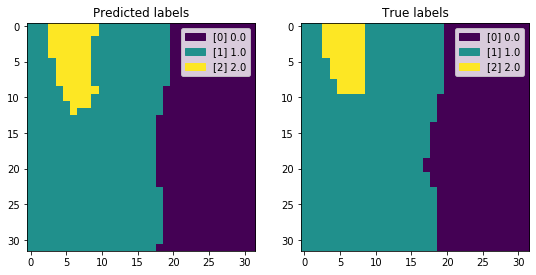

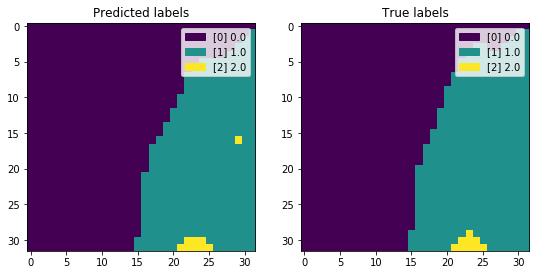

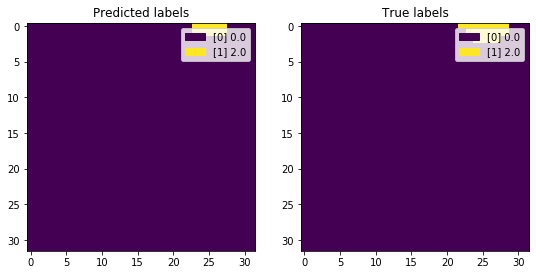

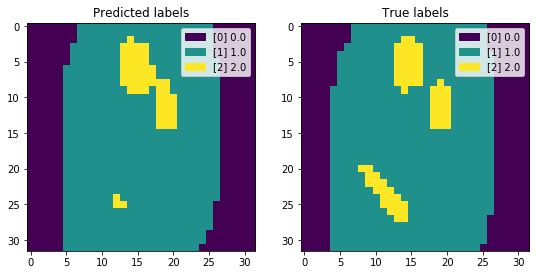

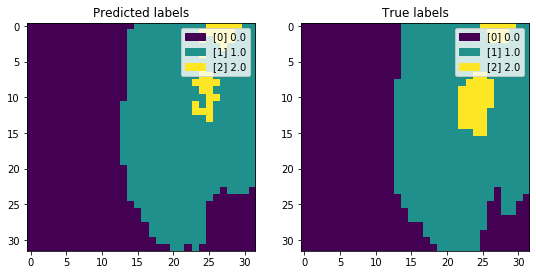

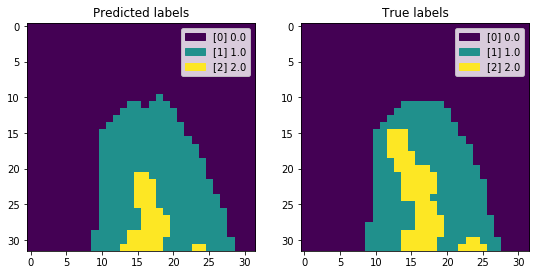

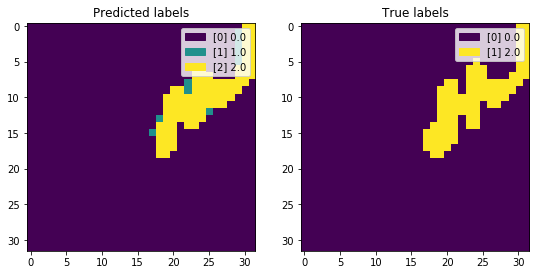

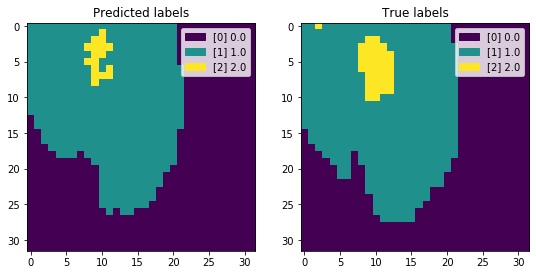

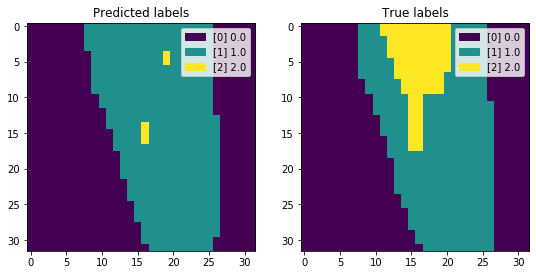

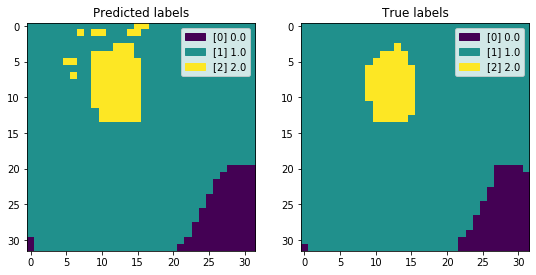

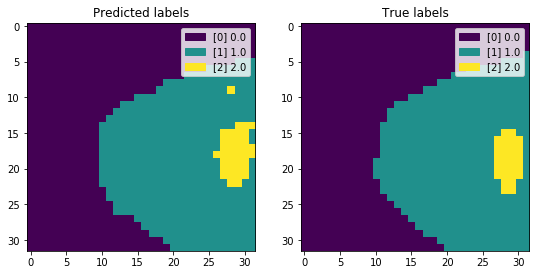

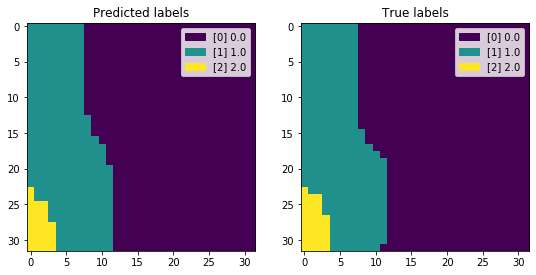

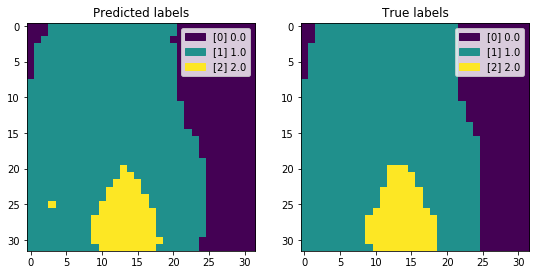

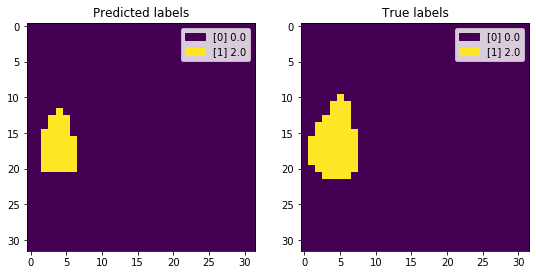

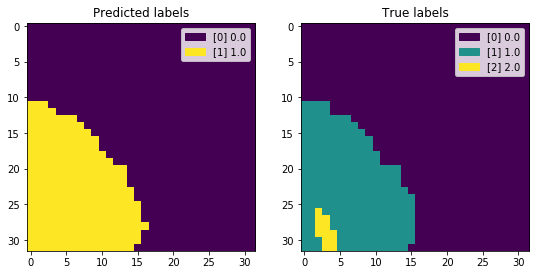

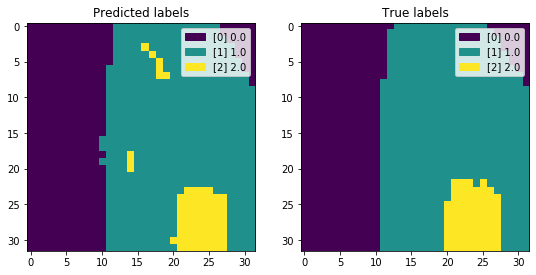

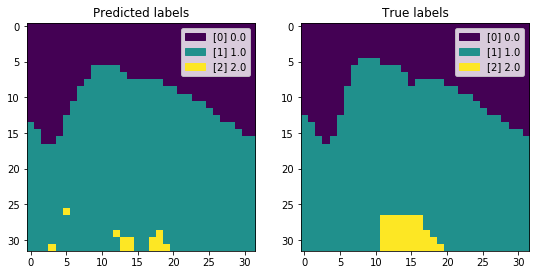

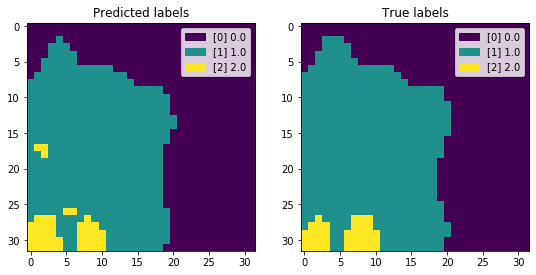

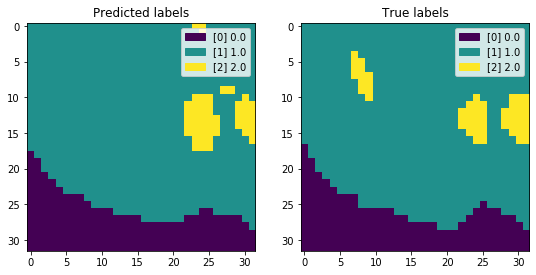

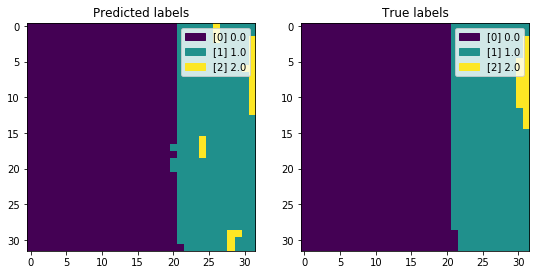

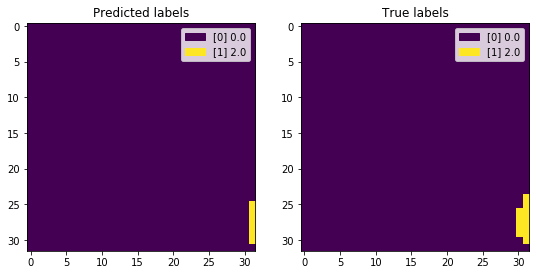

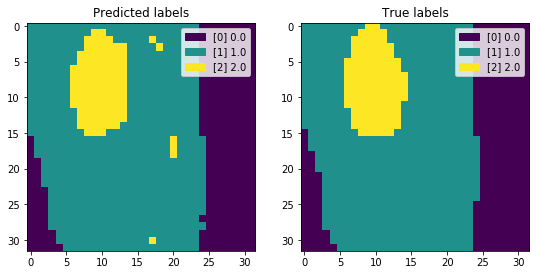

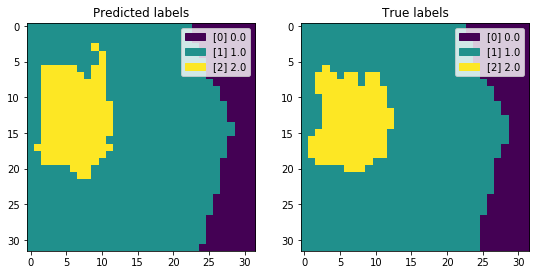

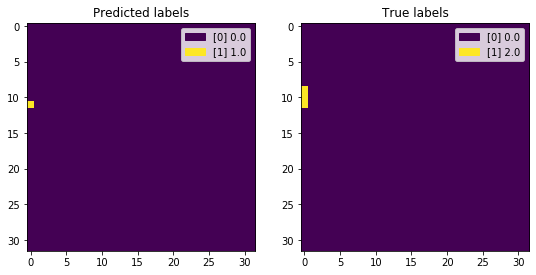

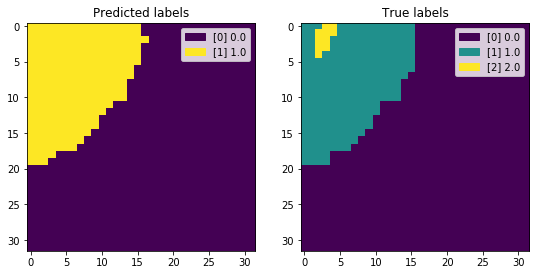

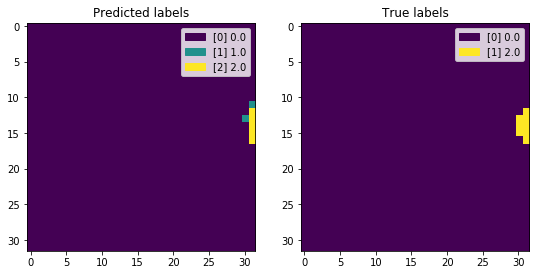

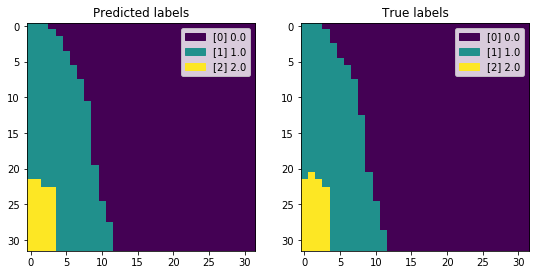

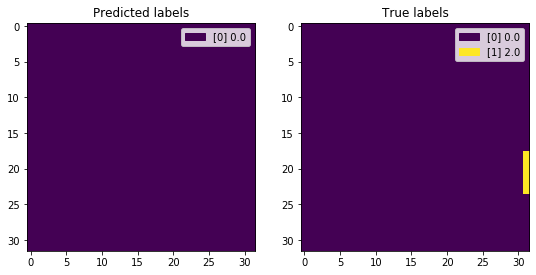

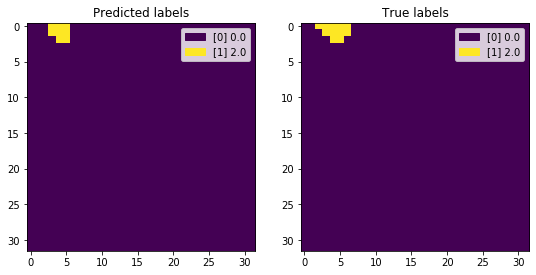

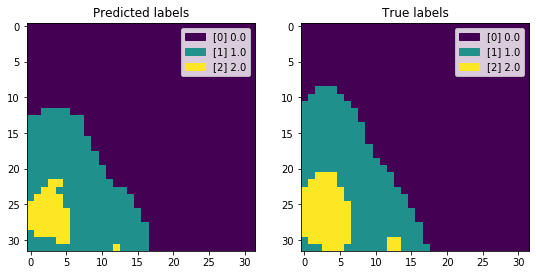

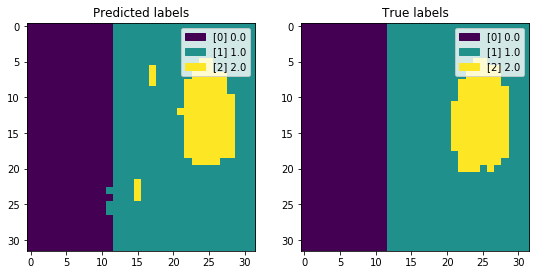

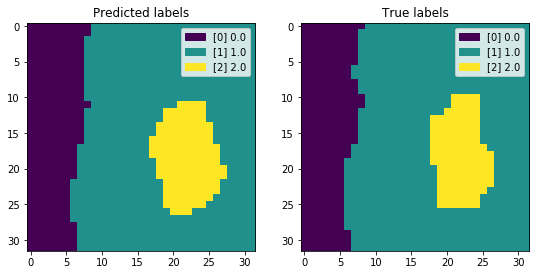

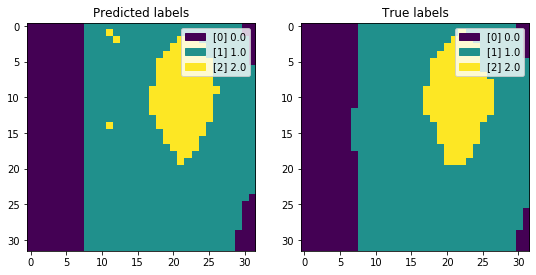

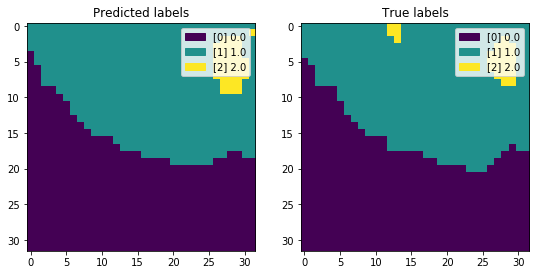

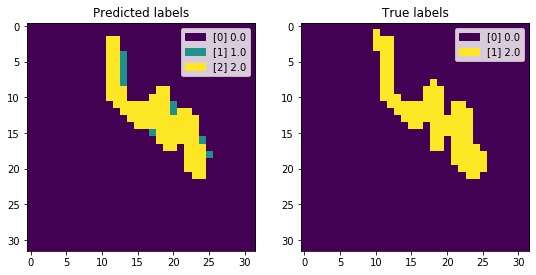

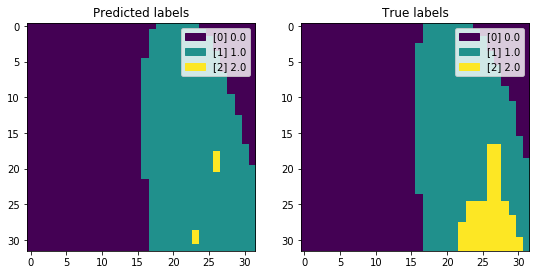

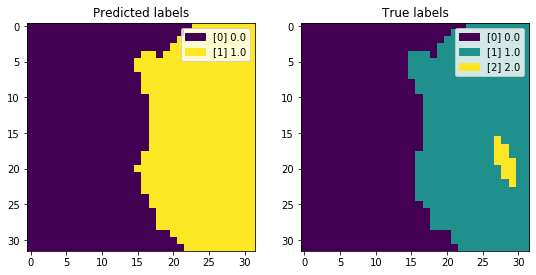

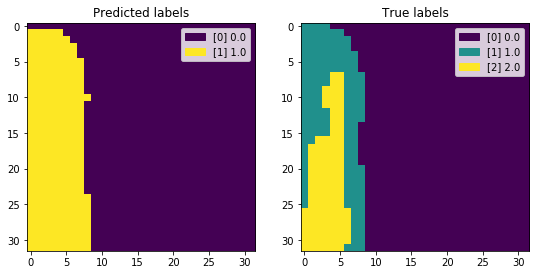

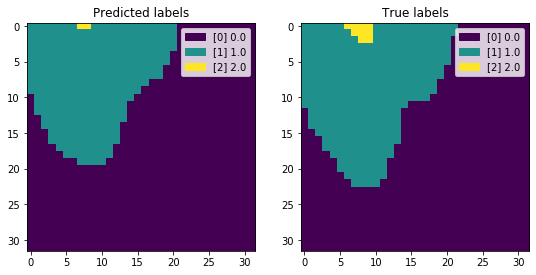

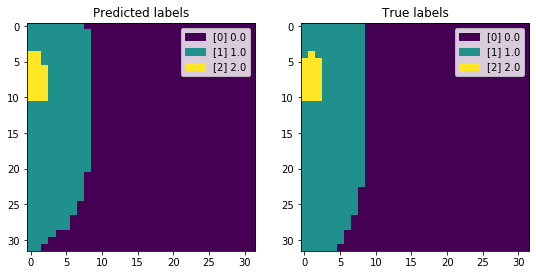

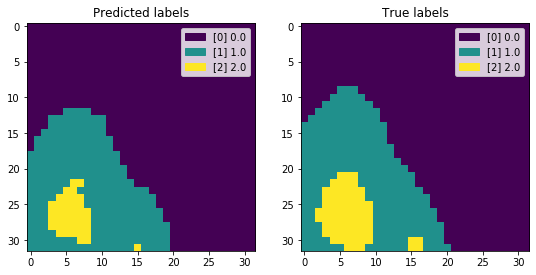

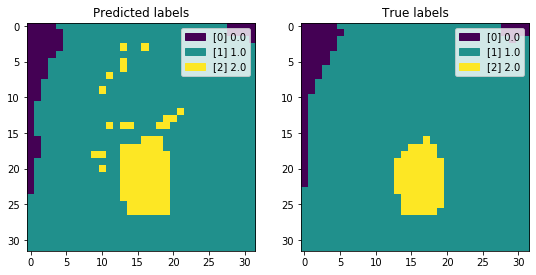

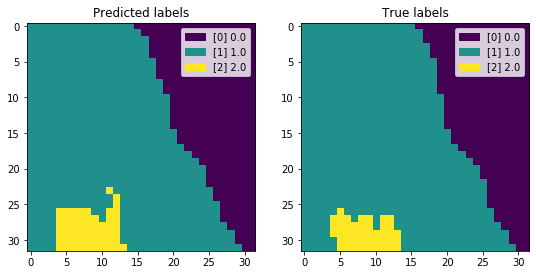

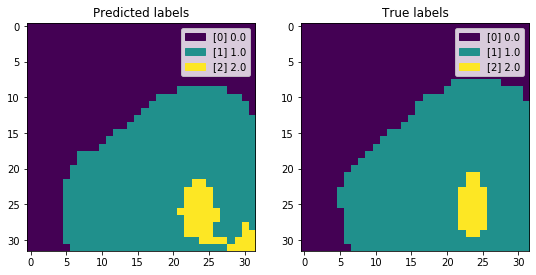

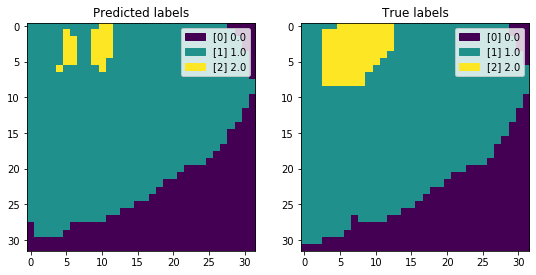

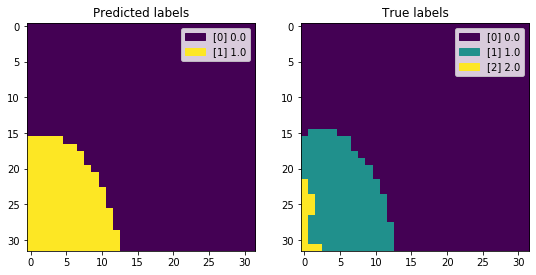

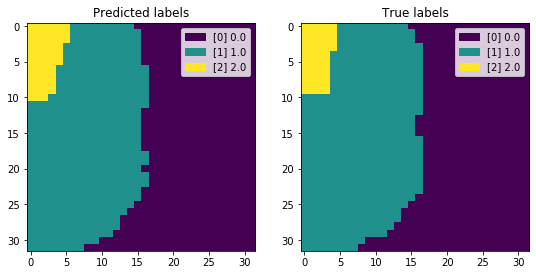

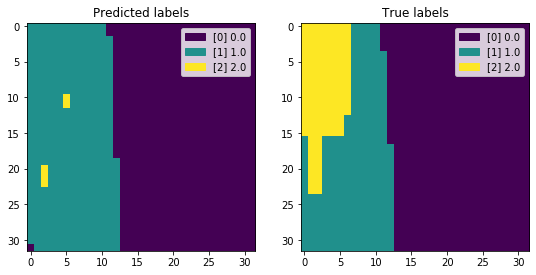

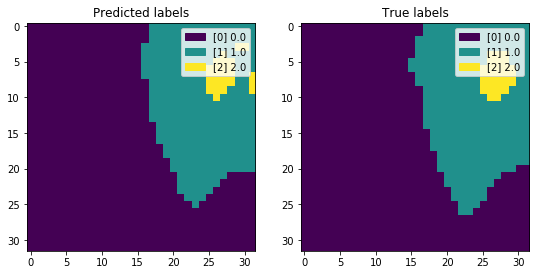

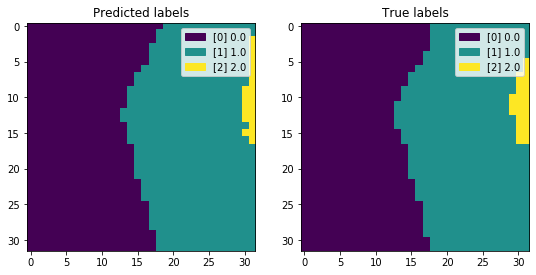

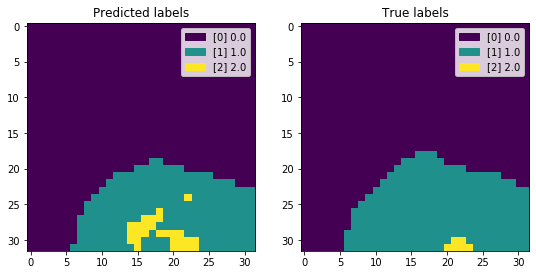

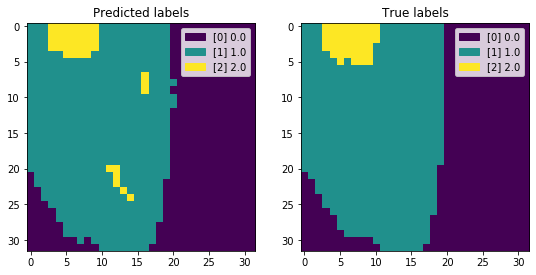

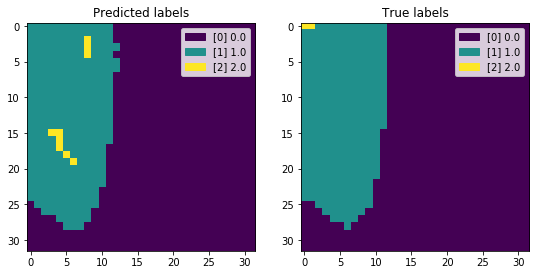

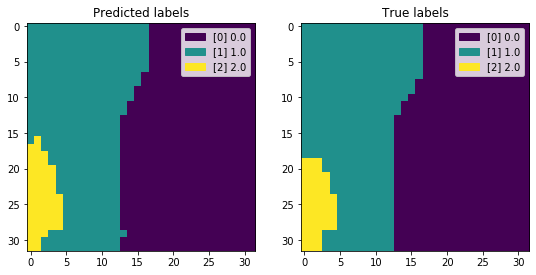

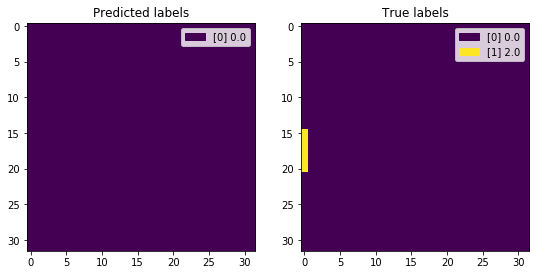

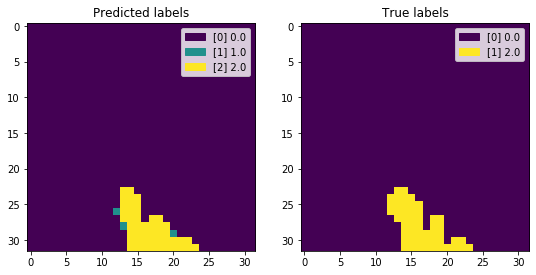

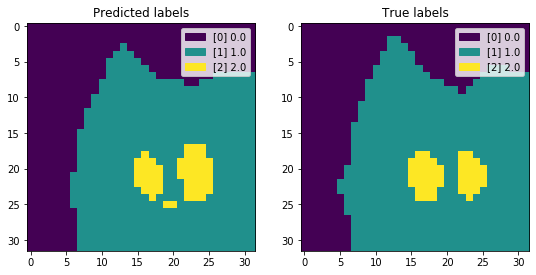

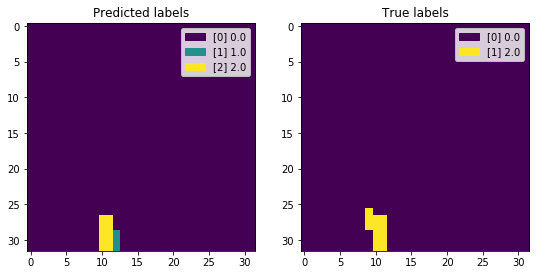

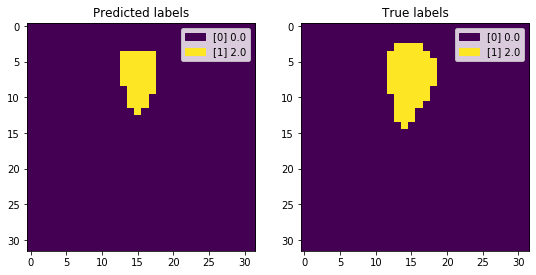

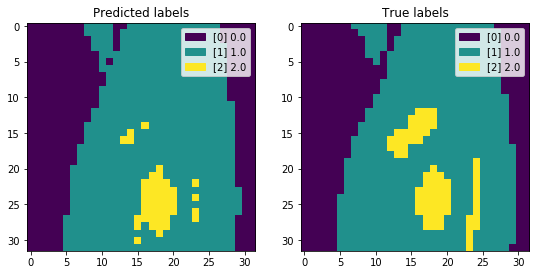

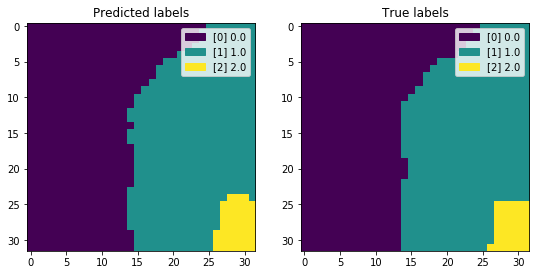

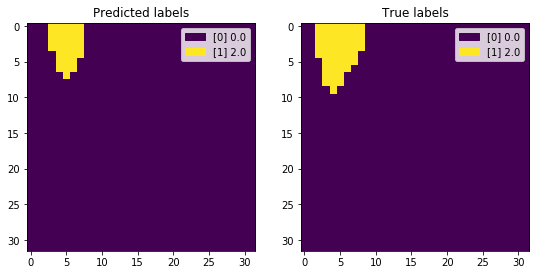

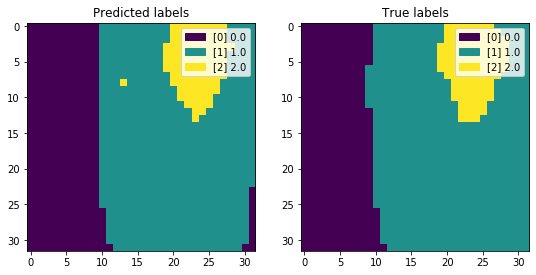

In [10]:
for i in range(len(Y_test)):
    if 2 in Y_test[i]:
        plt.figure(figsize=(9, 6))
        plt.subplot(121)
        img = plt.imshow(np.squeeze(Y_hat[i]))
        mypackage.Dataset._Dataset__add_legend_to_image(Y_hat[i], img)
        plt.title("Predicted labels")
        plt.subplot(122)
        img = plt.imshow(np.squeeze(Y_test[i]))
        mypackage.Dataset._Dataset__add_legend_to_image(Y_test[i], img)
        plt.title("True labels")

In [11]:
# train = mypackage.StackTransform(X_train_orig, Y_train_orig)
# Y_hat_train = logreg.predict(train.X_stack())
# Y_hat_train = train.Unstack(Y_hat_train, k=1)
# print(f"Fasle positive blobs {mypackage.count_false_positive(Y_hat_train, Y_train)}")

# for i in range(len(Y_train_orig)):
#     if 2 in Y_train_orig[i]:
#         plt.figure(figsize=(9, 6))
#         plt.subplot(121)
#         img = plt.imshow(np.squeeze(Y_hat_train[i]))
#         mypackage.Dataset._Dataset__add_legend_to_image(Y_hat_train[i], img)
#         plt.title("Predicted labels")
#         plt.subplot(122)
#         img = plt.imshow(np.squeeze(Y_train_orig[i]))
#         mypackage.Dataset._Dataset__add_legend_to_image(Y_train_orig[i], img)
#         plt.title("True labels")

### Test SpectralUNet on the same data

Start training
Train on 1161 samples, validate on 129 samples
Epoch 1/60
1160/1161 [============================>.] - ETA: 0s - loss: 0.4102 - accuracy: 0.9341
Epoch 00001: val_loss improved from inf to 0.14829, saving model to latest_spectral_unet.hdf5
1161/1161 [==============================] - 64s 55ms/sample - loss: 0.4103 - accuracy: 0.9342 - val_loss: 0.1483 - val_accuracy: 0.9784
Epoch 2/60
1160/1161 [============================>.] - ETA: 0s - loss: 0.1326 - accuracy: 0.9737
Epoch 00002: val_loss improved from 0.14829 to 0.07525, saving model to latest_spectral_unet.hdf5
1161/1161 [==============================] - 61s 53ms/sample - loss: 0.1328 - accuracy: 0.9737 - val_loss: 0.0753 - val_accuracy: 0.9791
Epoch 3/60
1160/1161 [============================>.] - ETA: 0s - loss: 0.1089 - accuracy: 0.9722
Epoch 00003: val_loss improved from 0.07525 to 0.06707, saving model to latest_spectral_unet.hdf5
1161/1161 [==============================] - 61s 53ms/sample - loss: 0.1096 - ac

1160/1161 [============================>.] - ETA: 0s - loss: 0.0450 - accuracy: 0.9843
Epoch 00027: val_loss did not improve from 0.03465
1161/1161 [==============================] - 61s 53ms/sample - loss: 0.0450 - accuracy: 0.9843 - val_loss: 0.0362 - val_accuracy: 0.9856
Epoch 28/60
1160/1161 [============================>.] - ETA: 0s - loss: 0.0456 - accuracy: 0.9837
Epoch 00028: val_loss did not improve from 0.03465
1161/1161 [==============================] - 61s 53ms/sample - loss: 0.0456 - accuracy: 0.9837 - val_loss: 0.0387 - val_accuracy: 0.9859
Epoch 29/60
1160/1161 [============================>.] - ETA: 0s - loss: 0.0457 - accuracy: 0.9838
Epoch 00029: val_loss did not improve from 0.03465
1161/1161 [==============================] - 61s 53ms/sample - loss: 0.0457 - accuracy: 0.9838 - val_loss: 0.0472 - val_accuracy: 0.9803
Epoch 30/60
1160/1161 [============================>.] - ETA: 0s - loss: 0.0445 - accuracy: 0.9840
Epoch 00030: val_loss did not improve from 0.03465
1

Epoch 55/60
1160/1161 [============================>.] - ETA: 0s - loss: 0.0385 - accuracy: 0.9856
Epoch 00055: val_loss did not improve from 0.03078
1161/1161 [==============================] - 61s 53ms/sample - loss: 0.0385 - accuracy: 0.9856 - val_loss: 0.0314 - val_accuracy: 0.9877
Epoch 56/60
1160/1161 [============================>.] - ETA: 0s - loss: 0.0377 - accuracy: 0.9859
Epoch 00056: val_loss did not improve from 0.03078
1161/1161 [==============================] - 61s 53ms/sample - loss: 0.0376 - accuracy: 0.9859 - val_loss: 0.0331 - val_accuracy: 0.9870
Epoch 57/60
1160/1161 [============================>.] - ETA: 0s - loss: 0.0375 - accuracy: 0.9858
Epoch 00057: val_loss did not improve from 0.03078
1161/1161 [==============================] - 61s 53ms/sample - loss: 0.0377 - accuracy: 0.9857 - val_loss: 0.0370 - val_accuracy: 0.9862
Epoch 58/60
1160/1161 [============================>.] - ETA: 0s - loss: 0.0363 - accuracy: 0.9864
Epoch 00058: val_loss did not improve fr

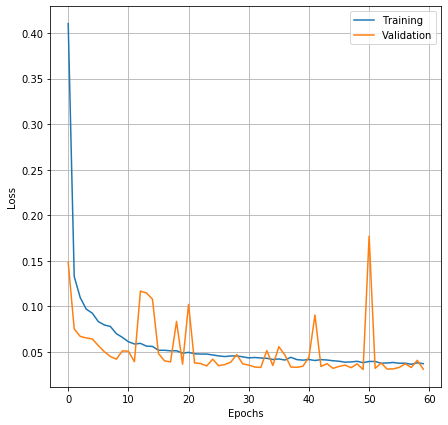

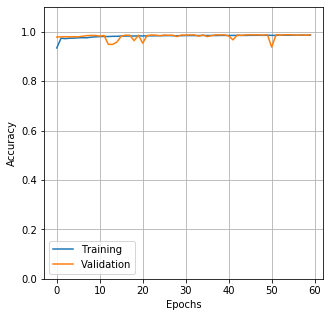

Predicting for train data
Elapsed time: 16.0730 seconds
              precision    recall  f1-score   support

           0       0.99      1.00      0.99   1072956
           1       0.96      0.97      0.97    231076
           2       0.91      0.76      0.83     16928

    accuracy                           0.99   1320960
   macro avg       0.96      0.91      0.93   1320960
weighted avg       0.99      0.99      0.99   1320960



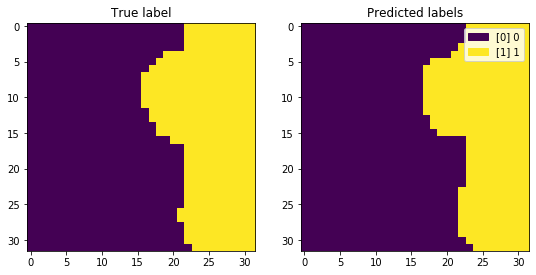

Predicting for test data
Elapsed time: 7.0135 seconds
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    477166
           1       0.96      0.96      0.96     99469
           2       0.83      0.52      0.64      7045

    accuracy                           0.99    583680
   macro avg       0.93      0.83      0.87    583680
weighted avg       0.99      0.99      0.98    583680



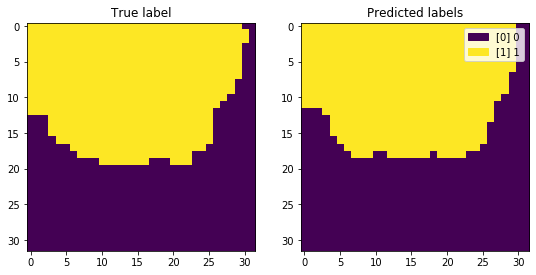

Elapsed time: 7.8735 seconds
Fasle positive blobs 27


In [12]:
spectral_unet = mypackage.SpectralUNet(X_train, Y_train, batchnorm=True, dropout=0.5)
print("Start training")
timer.start()
spectral_unet.train(batch_size=5, epochs=60, validation_split=0.1, clear_output=False, monitor='val_loss', mode='min')
timer.stop()

# spectral_unet.summary()
spectral_unet.plot_training_results()
print("Predicting for train data")
spectral_unet.predict(X_train, Y_labels=Y_train)
print("Predicting for test data")
timer.start()
y_pred_test = spectral_unet.predict(X_test, Y_labels=Y_test);
timer.stop()
print(f"Fasle positive blobs {mypackage.count_false_positive(y_pred_test, Y_test)}")


### Test 2D UNet on the same data

Start training
Elapsed time: 198.8904 seconds


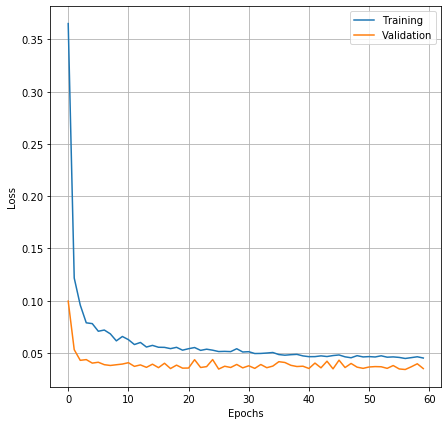

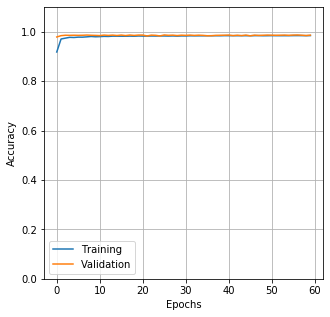

Predicting for train data
Elapsed time: 0.6816 seconds
              precision    recall  f1-score   support

           0       0.99      1.00      0.99   1072956
           1       0.96      0.95      0.96    231076
           2       0.88      0.65      0.75     16928

    accuracy                           0.99   1320960
   macro avg       0.94      0.87      0.90   1320960
weighted avg       0.98      0.99      0.98   1320960



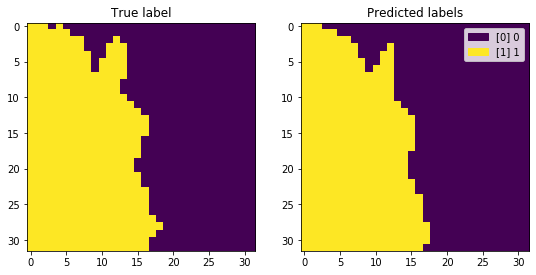

Predicting for test data
Elapsed time: 0.2392 seconds
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    477166
           1       0.96      0.95      0.96     99469
           2       0.78      0.48      0.59      7045

    accuracy                           0.98    583680
   macro avg       0.91      0.81      0.85    583680
weighted avg       0.98      0.98      0.98    583680



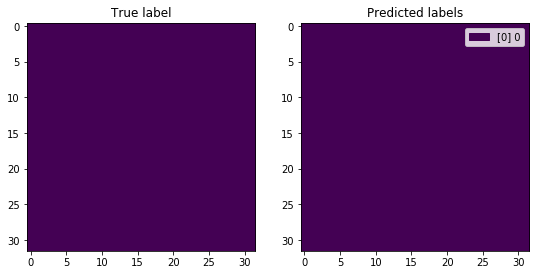

Elapsed time: 1.1074 seconds
Fasle positive blobs 42
Number of layers in the base model:  49


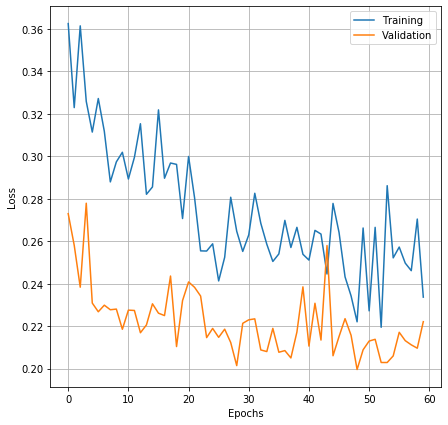

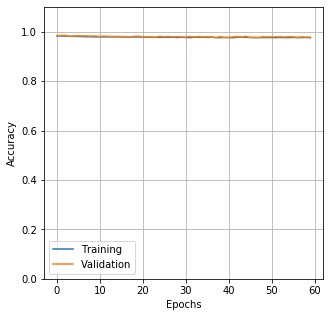

Predicting for test data after Dice_Loss focus on contaminants
Elapsed time: 0.4224 seconds
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    477166
           1       0.97      0.89      0.93     99469
           2       0.76      0.58      0.66      7045

    accuracy                           0.98    583680
   macro avg       0.91      0.82      0.86    583680
weighted avg       0.98      0.98      0.97    583680



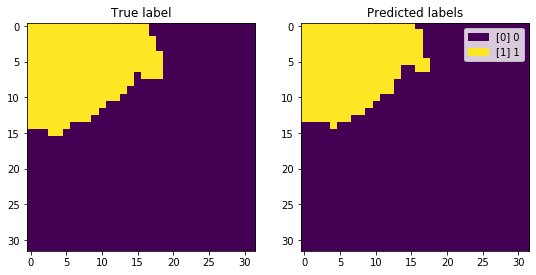

Fasle positive blobs 39


In [13]:
# I would like to use as input these channels
# 7: 953nm, 40: 1072, 68: 1173nm, 138: 1426nm, -1: 1674nm -> 1173nm, 1426nm, 1674nm match to the expected based on labratory measurements
channels_used = [7, 40, 68, 138, -1]
unet = mypackage.UNet(X_train[..., channels_used], Y_train, batchnorm=True, dropout=0.5)
print("Start training")
timer.start()
unet.train(batch_size=5, epochs=60, validation_split=0.1, clear_output=False, monitor='val_loss', mode='min', verbose=0)
timer.stop()

# unet.summary()
unet.plot_training_results()
print("Predicting for train data")
unet.predict(X_train[..., channels_used], Y_labels=Y_train)
print("Predicting for test data")
timer.start()
y_pred_test = unet.predict(X_test[..., channels_used], Y_labels=Y_test);
timer.stop()
print(f"Fasle positive blobs {mypackage.count_false_positive(y_pred_test, Y_test)}")

tl = lambda y_true, y_pred: mypackage.lf.tversky_loss(y_true, y_pred, only_contaminant=True)
unet.retrain(X_train[..., channels_used], Y_train, batch_size=20, epochs=60, loss=tl, validation_split=0.1, verbose=0)
unet.plot_training_results()
print("Predicting for test data after Dice_Loss focus on contaminants")
y_pred_test, y_pred_heat = unet.predict(X_test[..., channels_used], Y_labels=Y_test, return_heat_map=True);
print(f"Fasle positive blobs {mypackage.count_false_positive(y_pred_test, Y_test)}")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



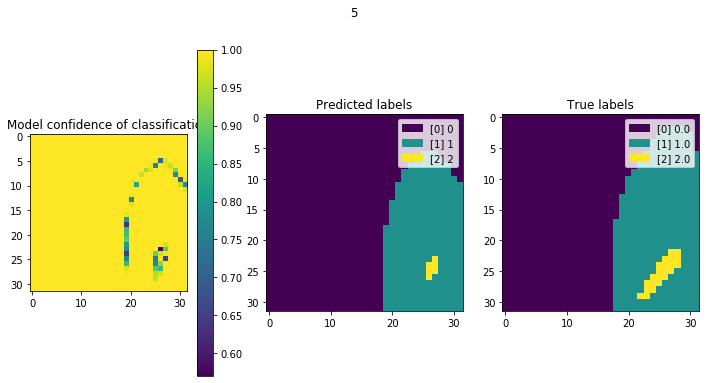

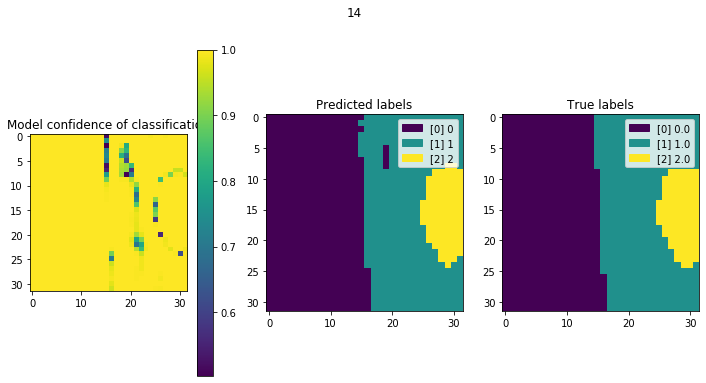

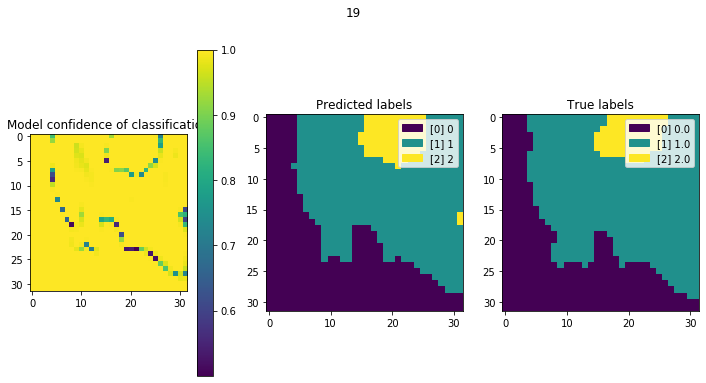

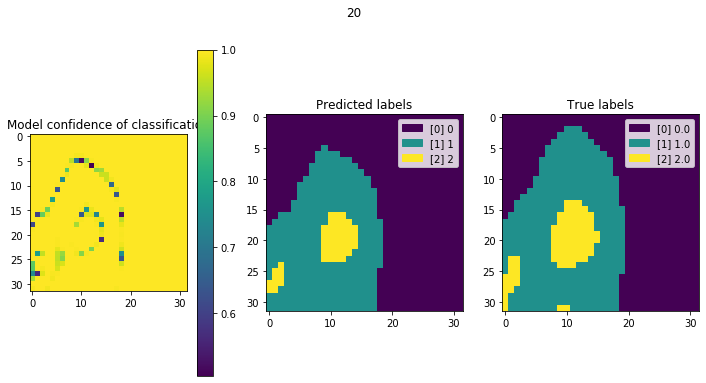

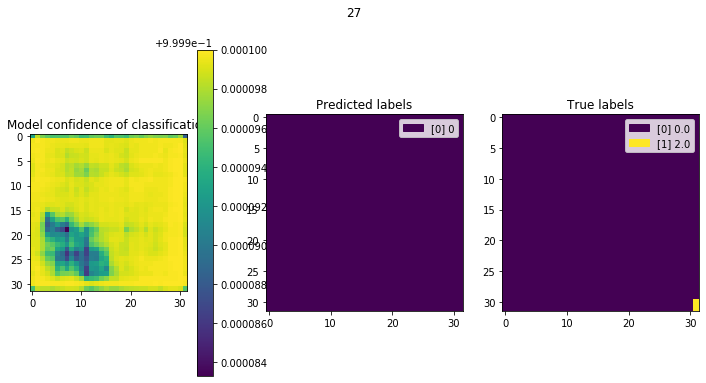

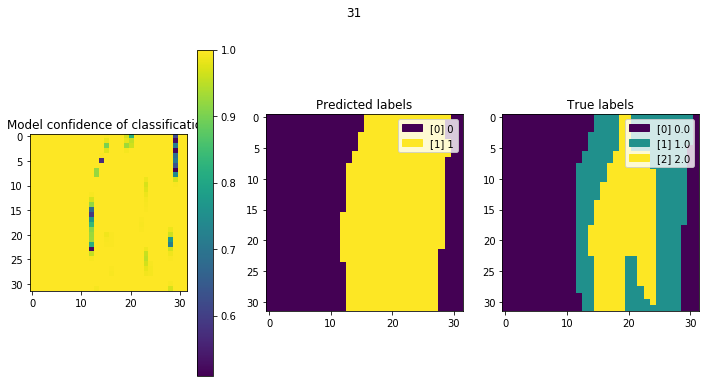

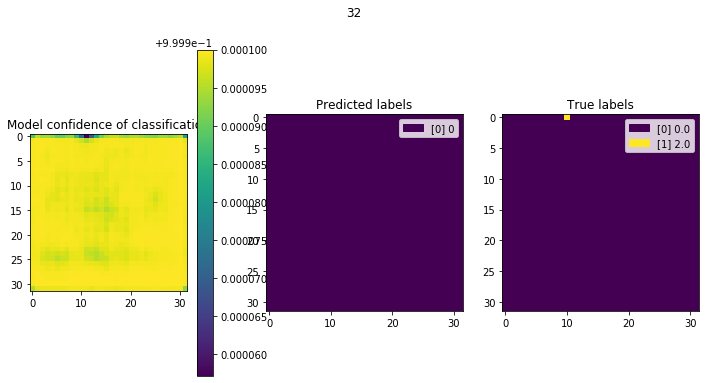

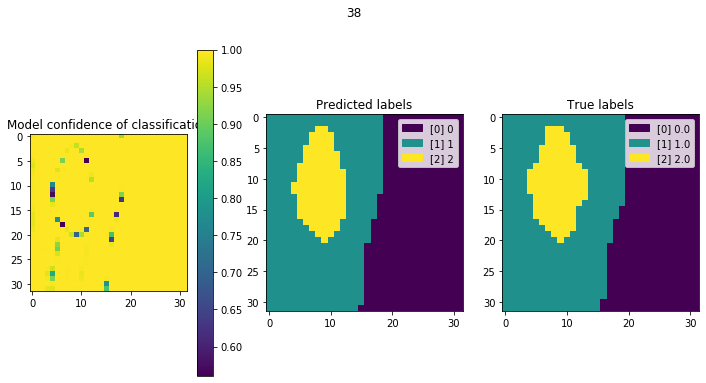

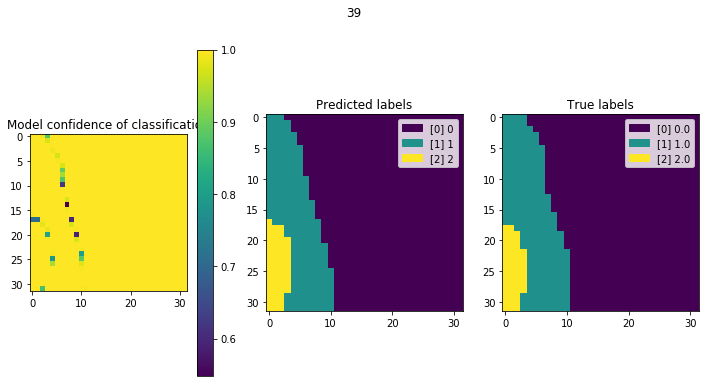

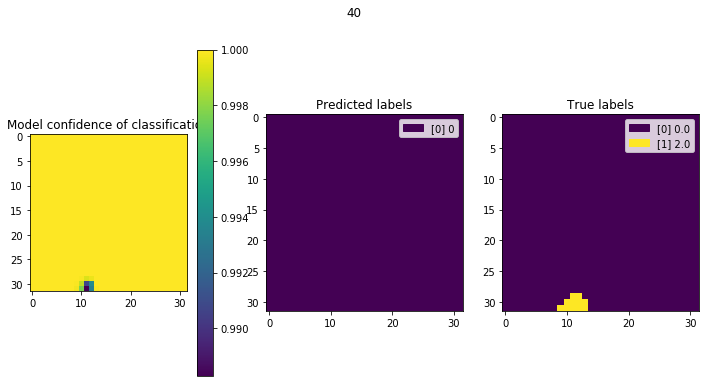

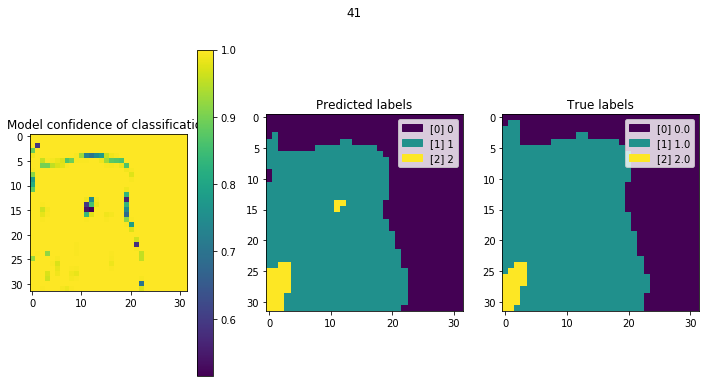

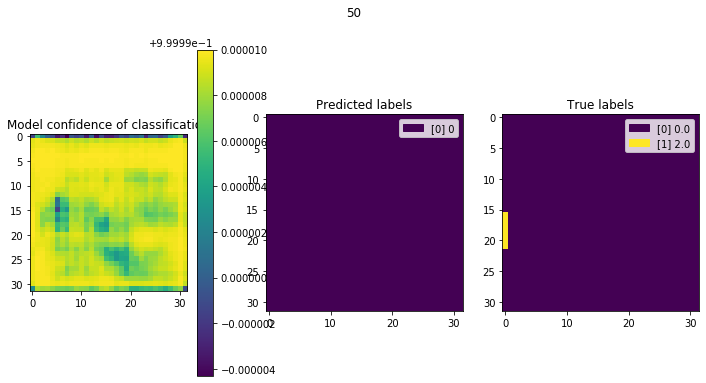

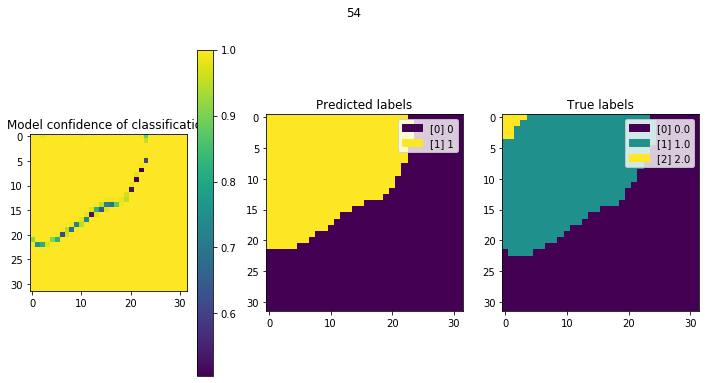

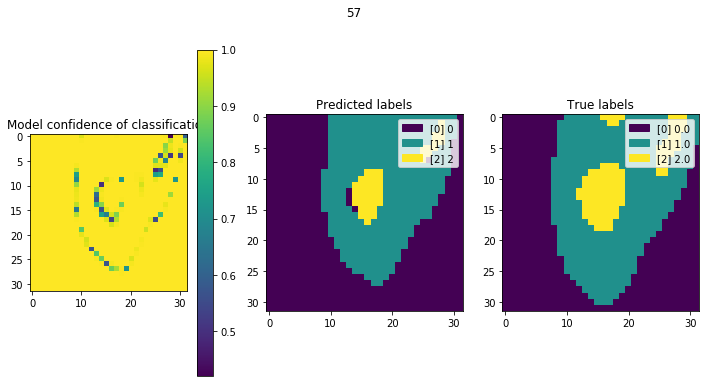

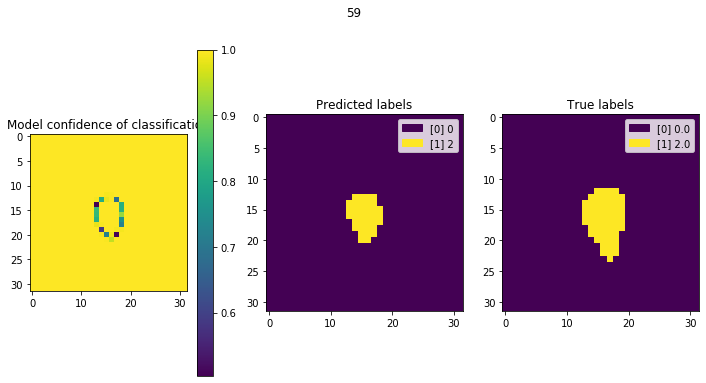

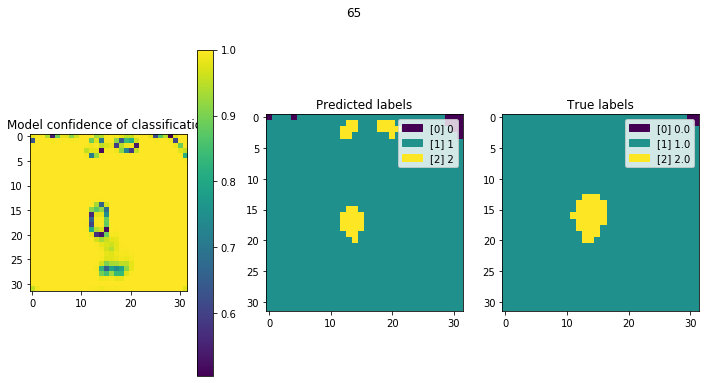

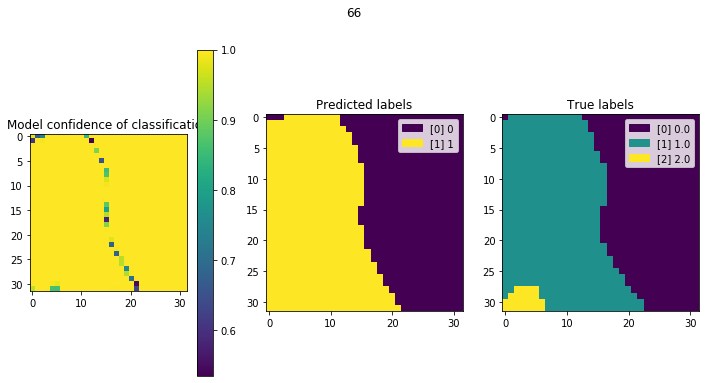

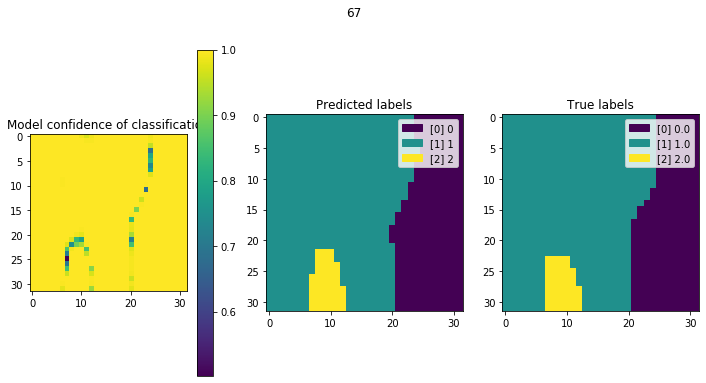

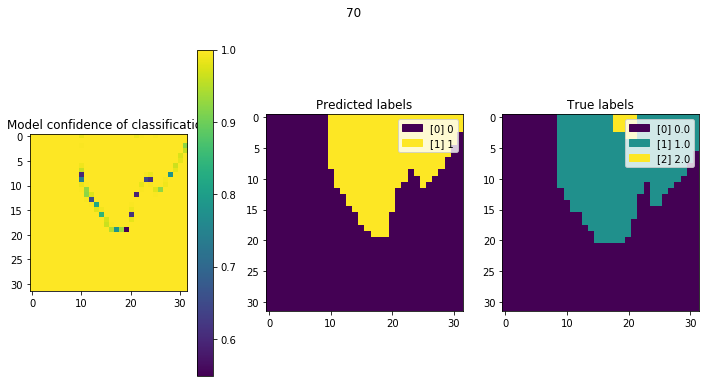

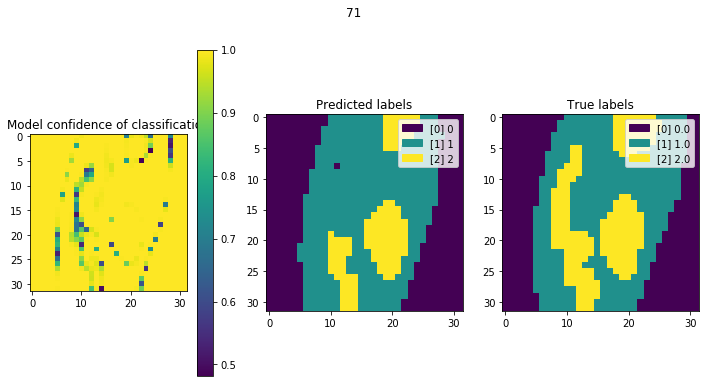

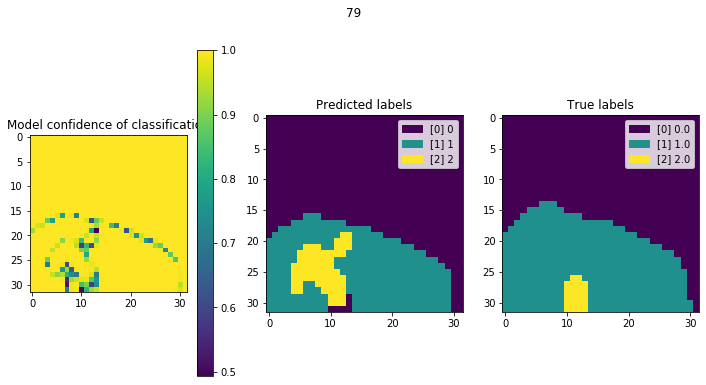

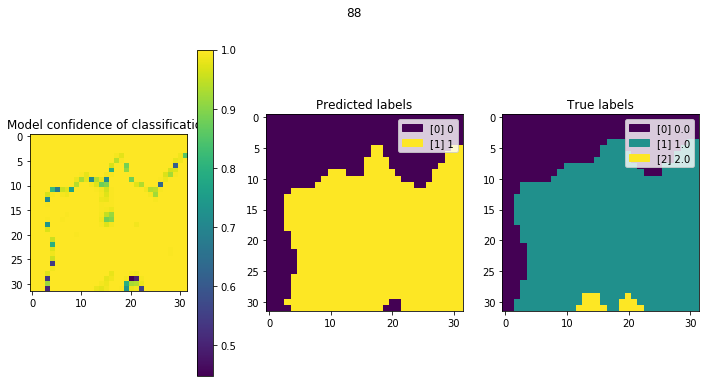

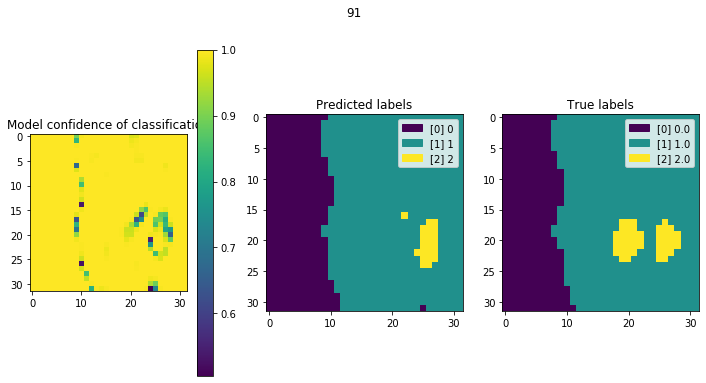

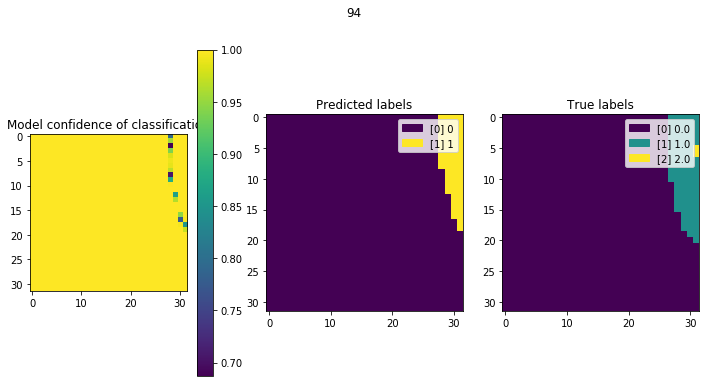

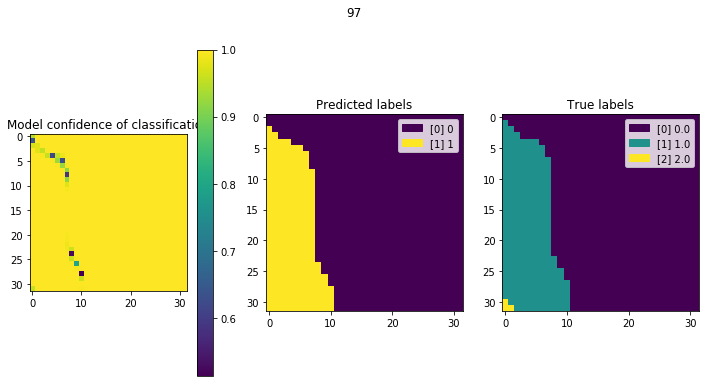

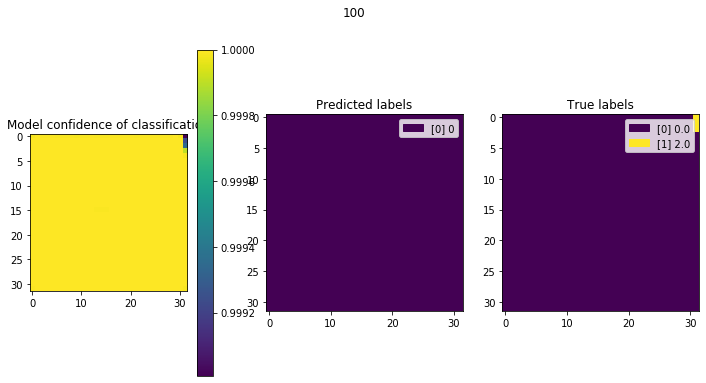

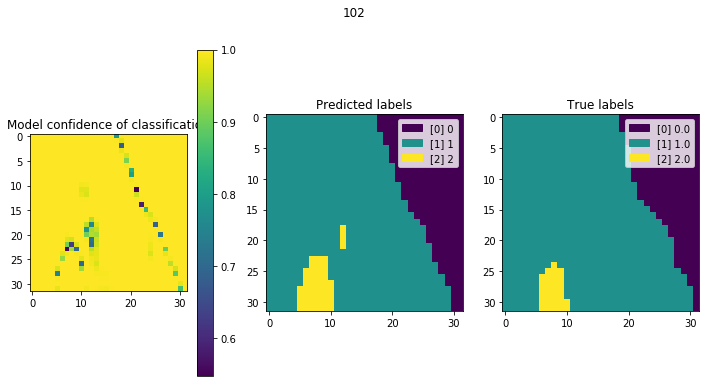

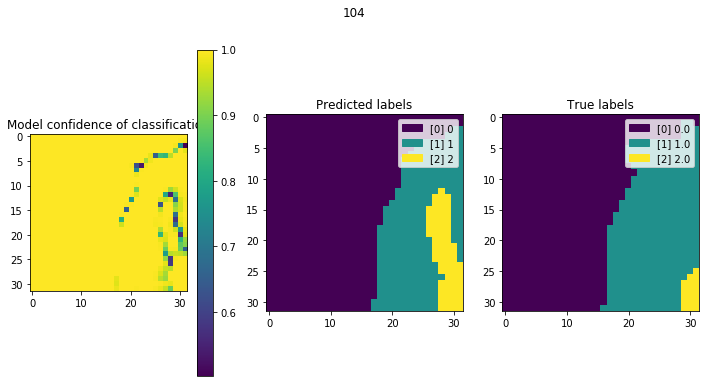

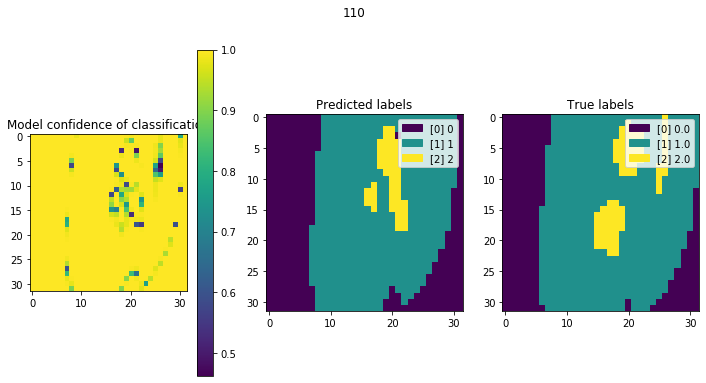

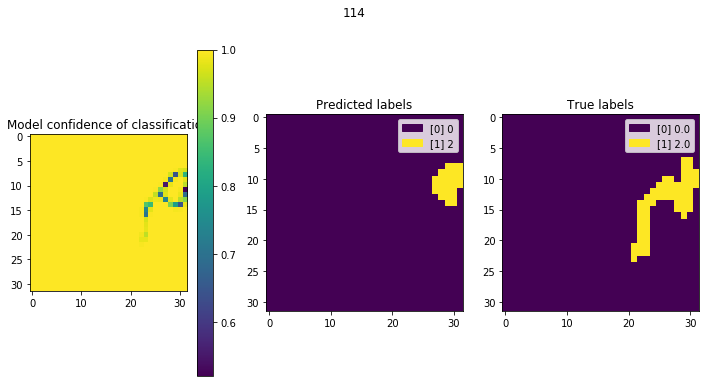

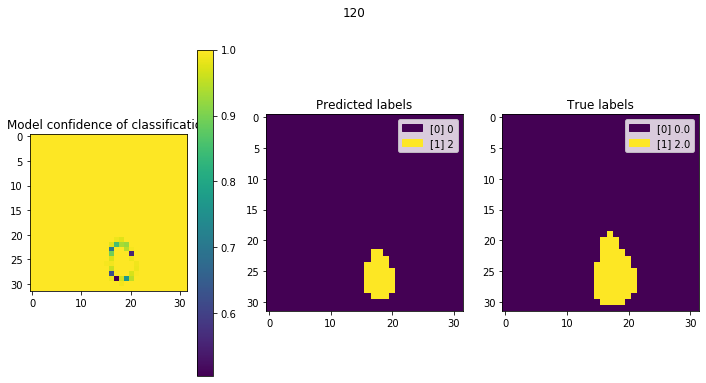

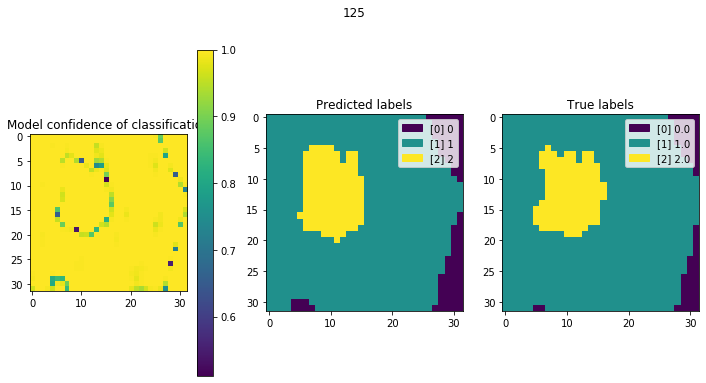

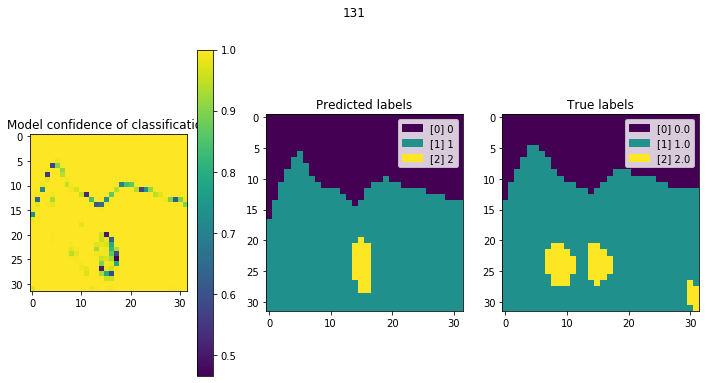

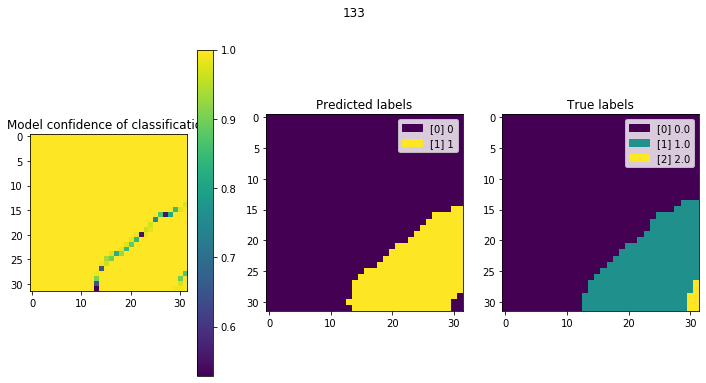

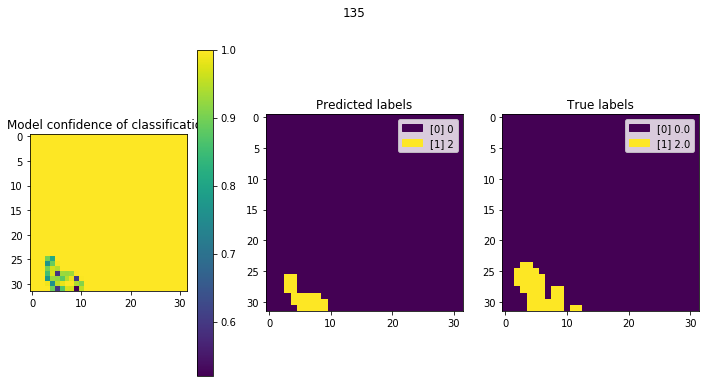

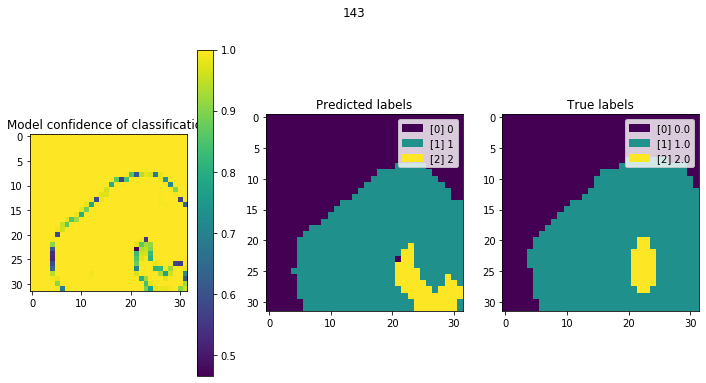

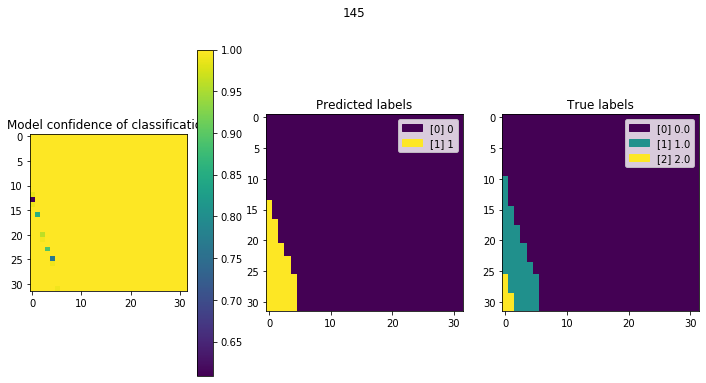

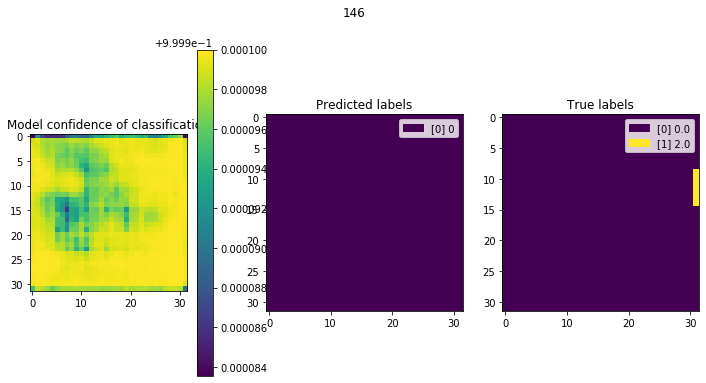

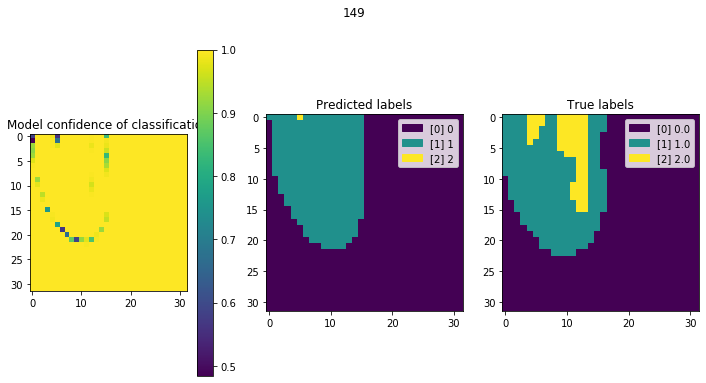

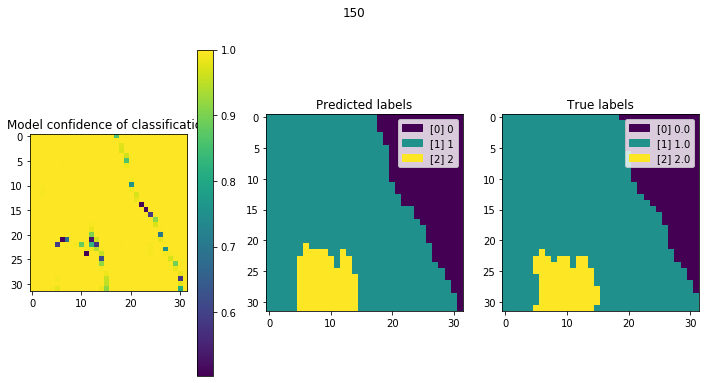

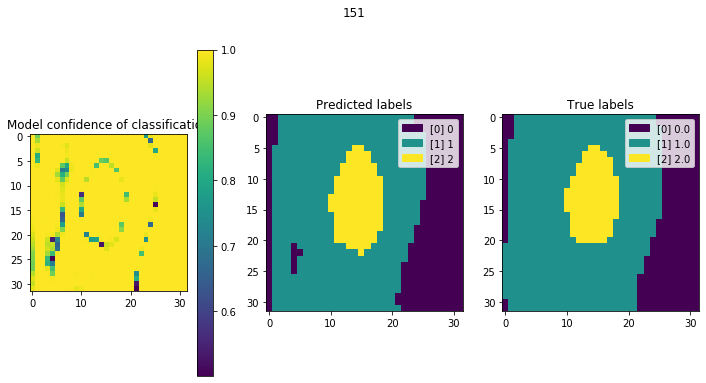

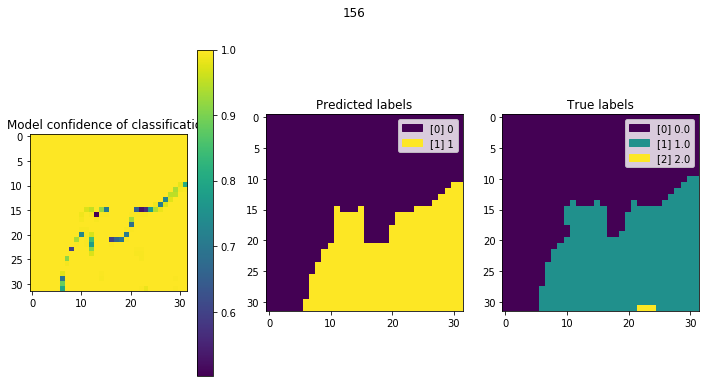

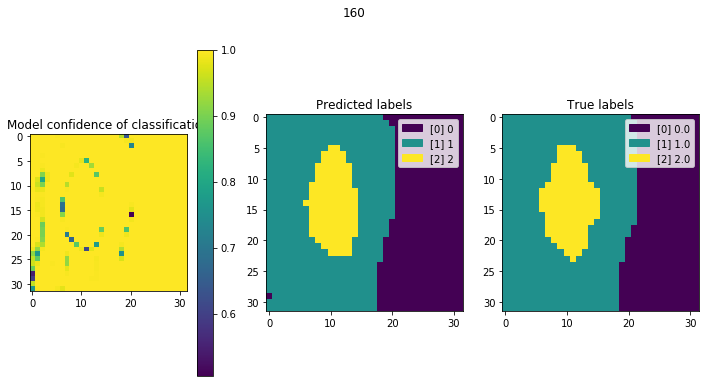

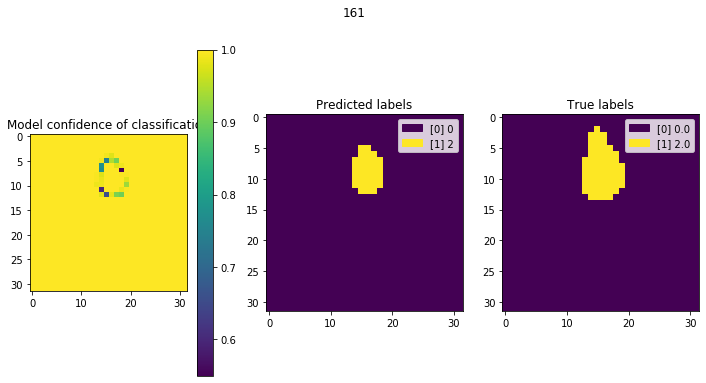

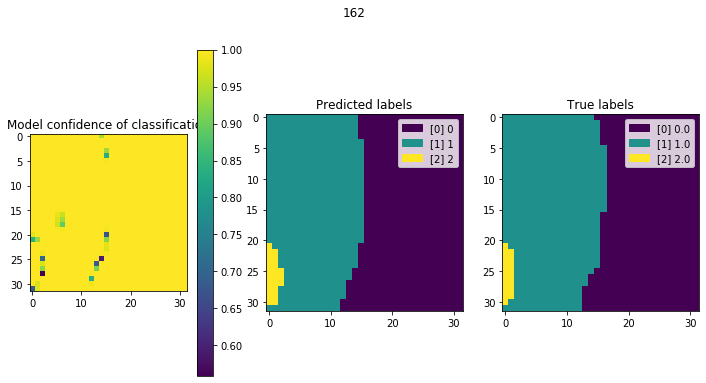

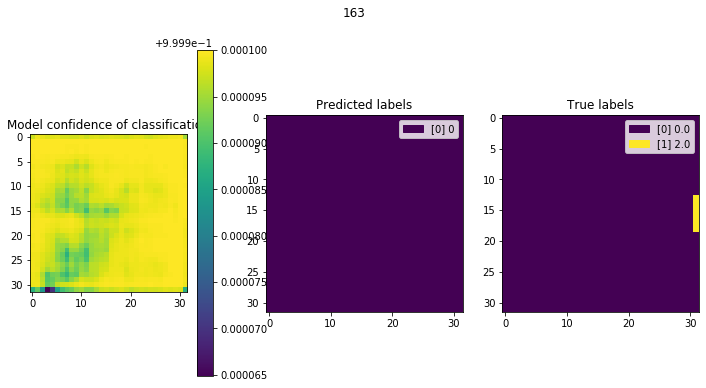

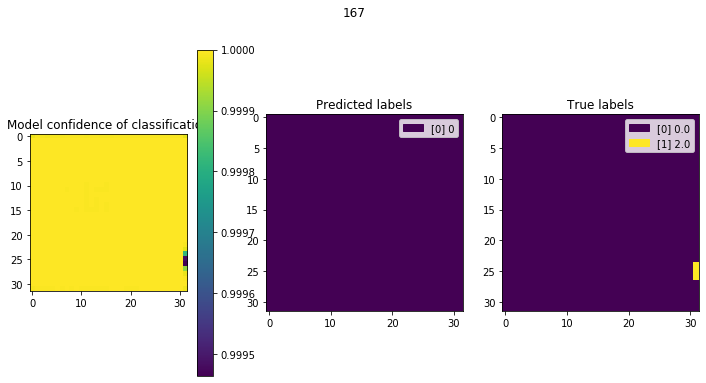

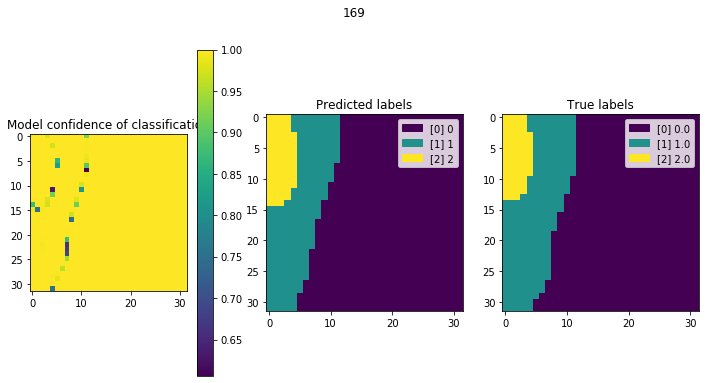

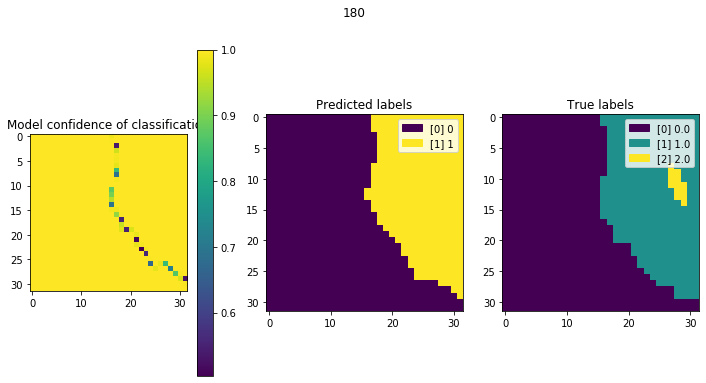

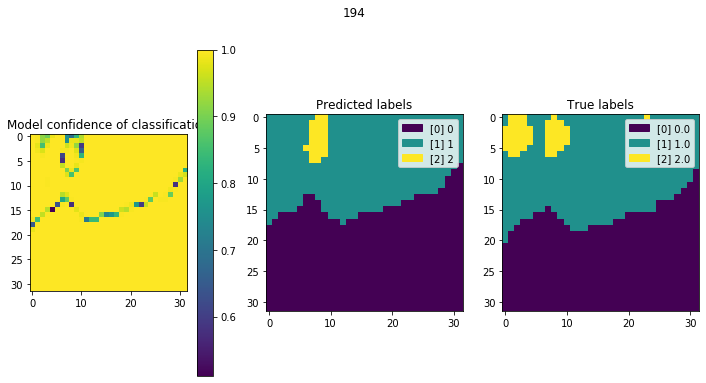

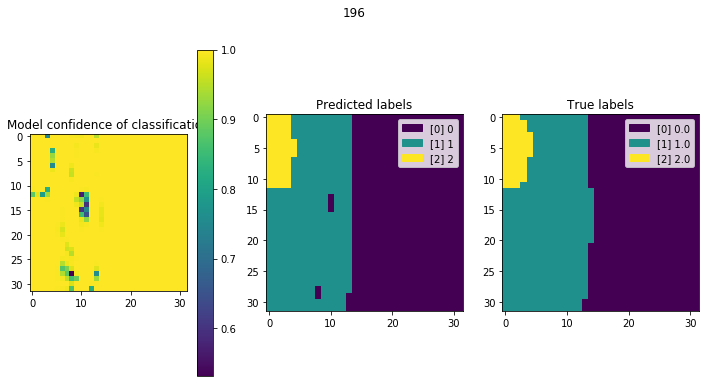

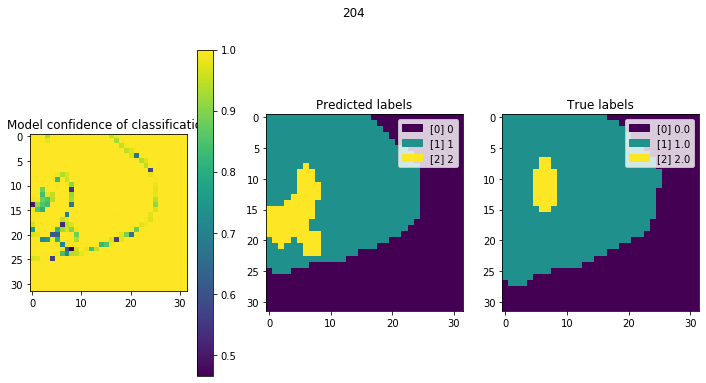

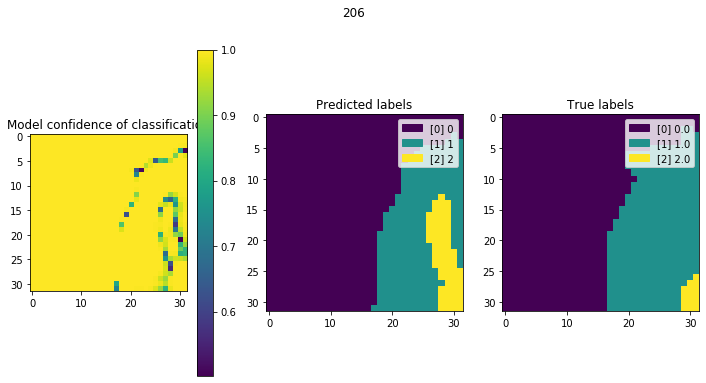

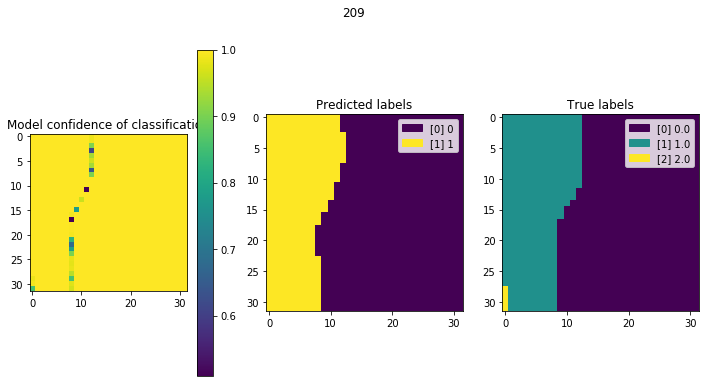

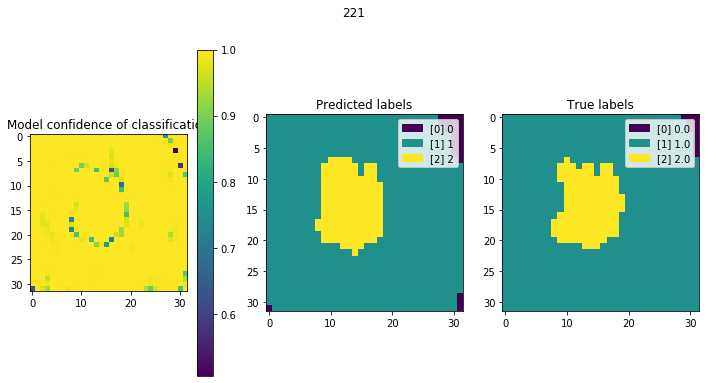

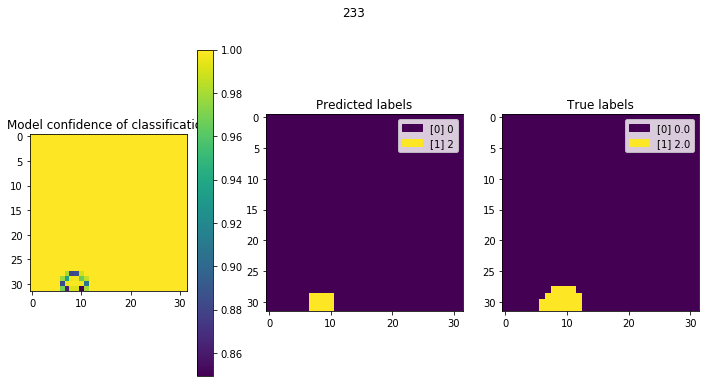

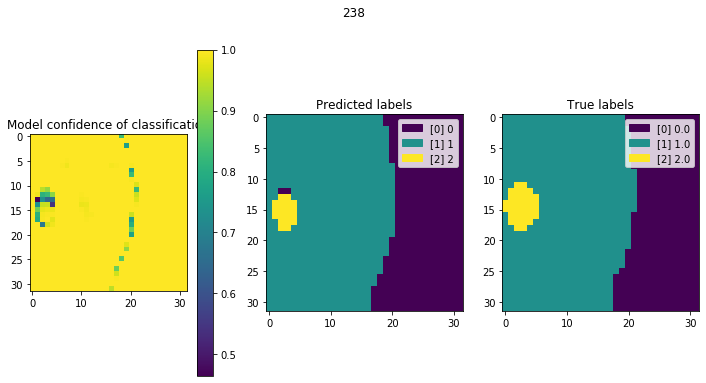

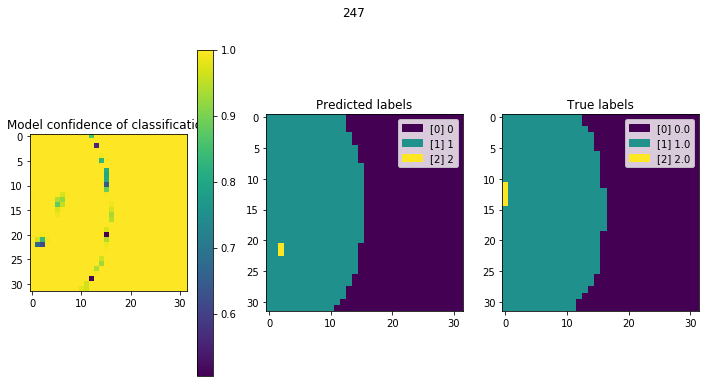

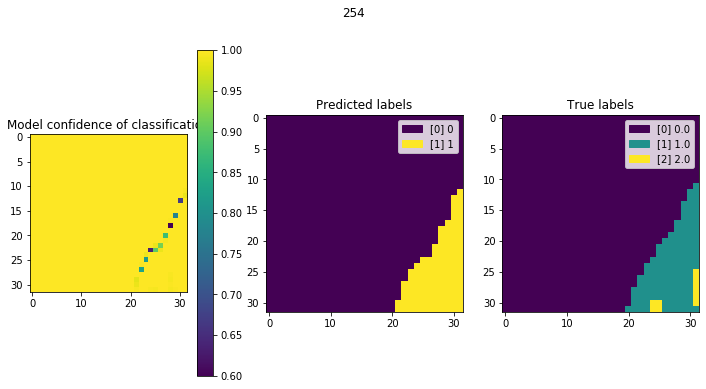

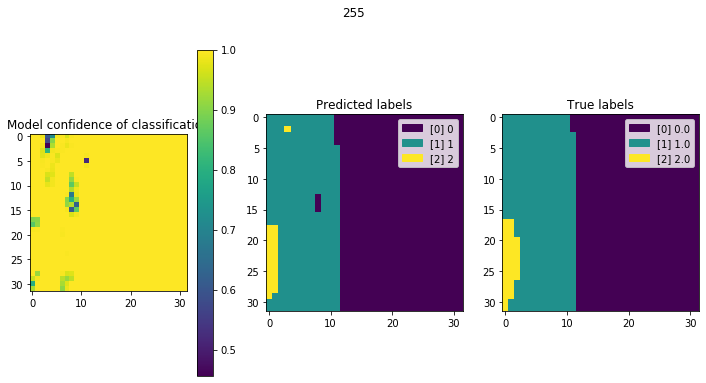

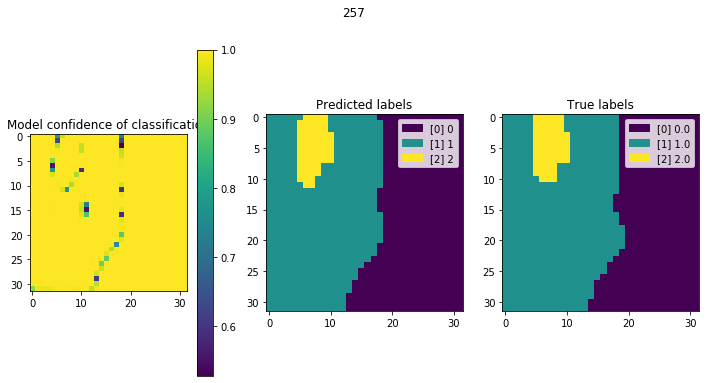

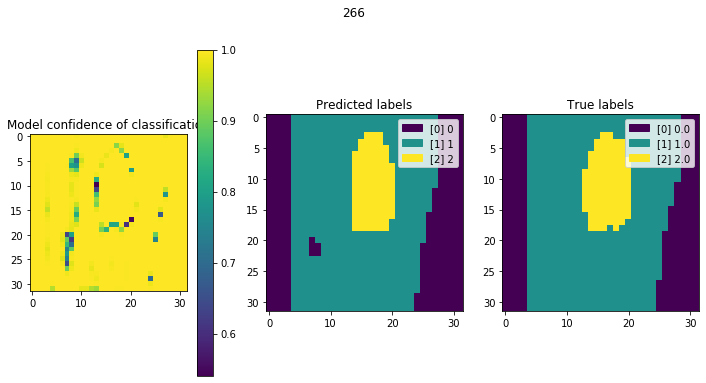

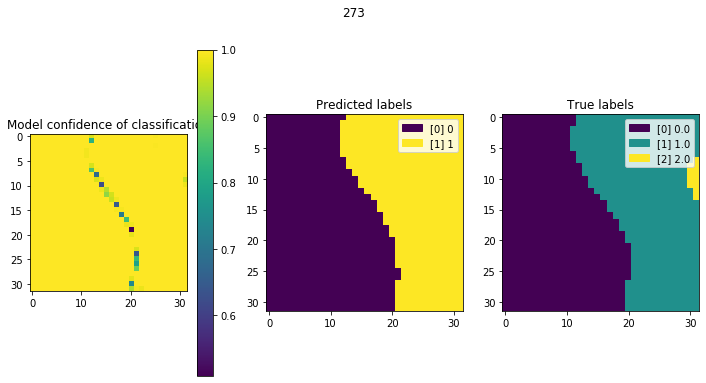

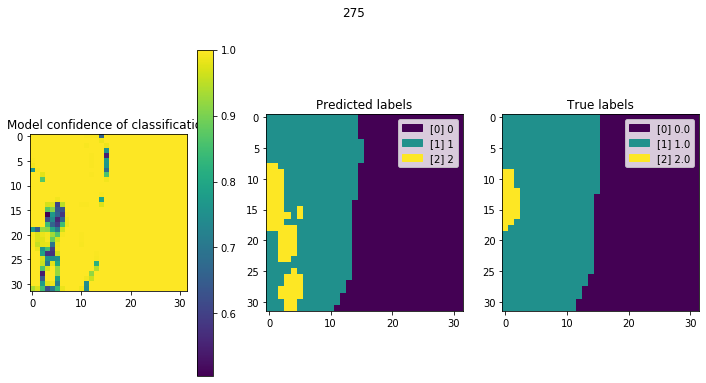

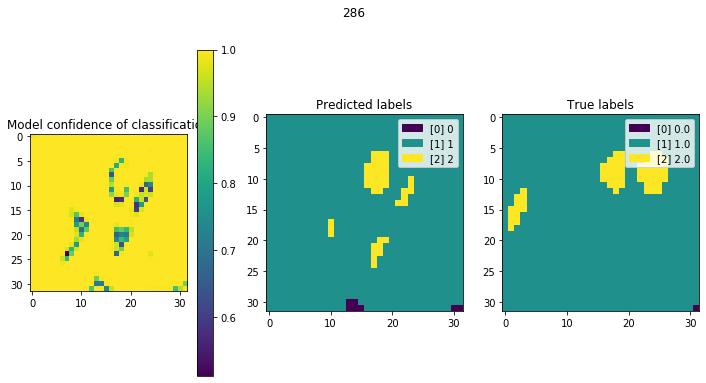

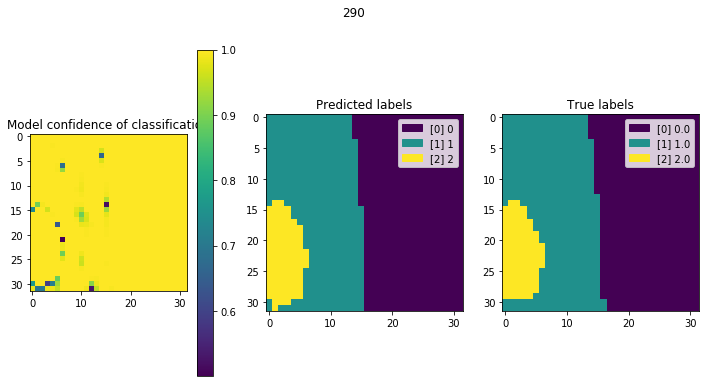

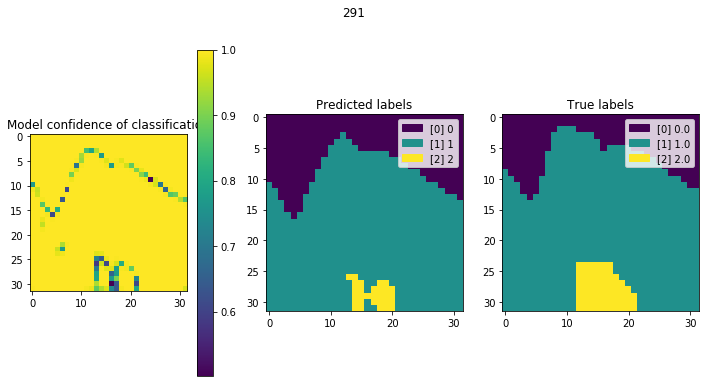

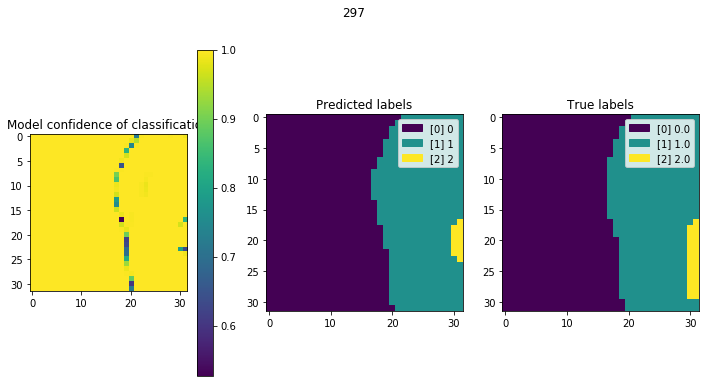

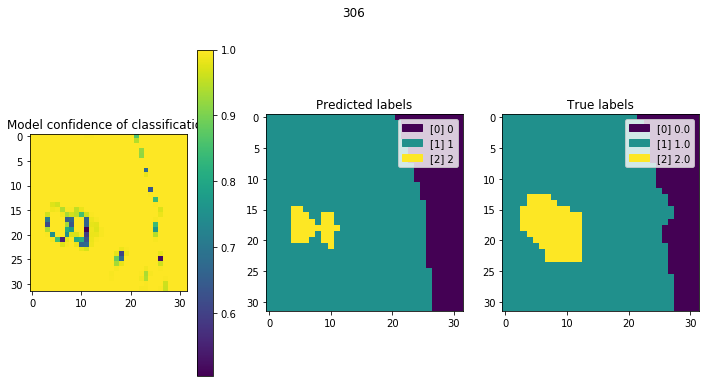

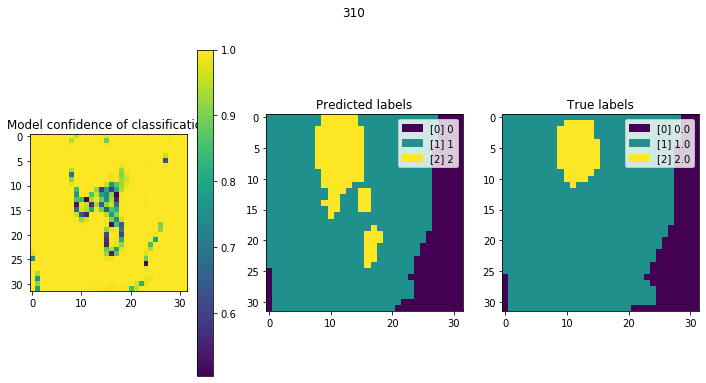

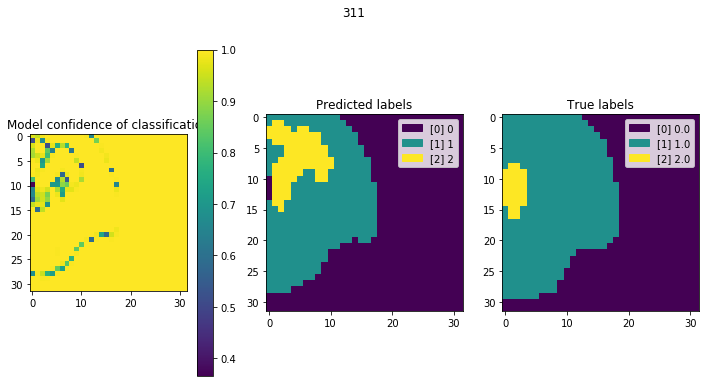

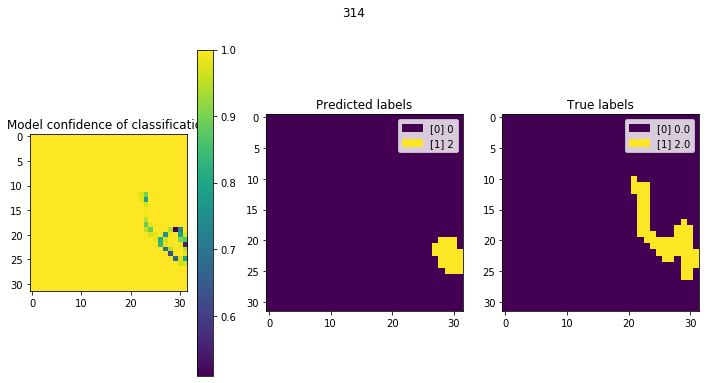

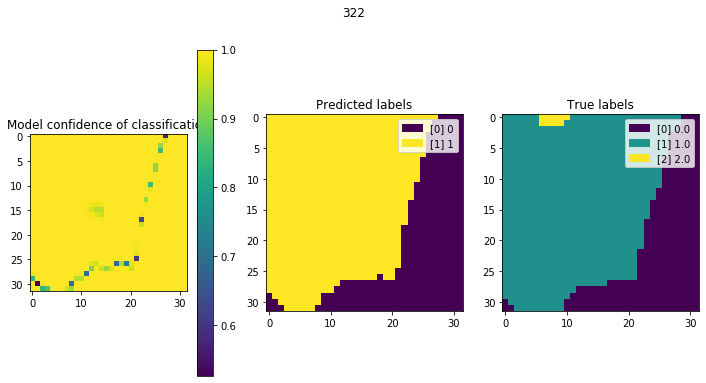

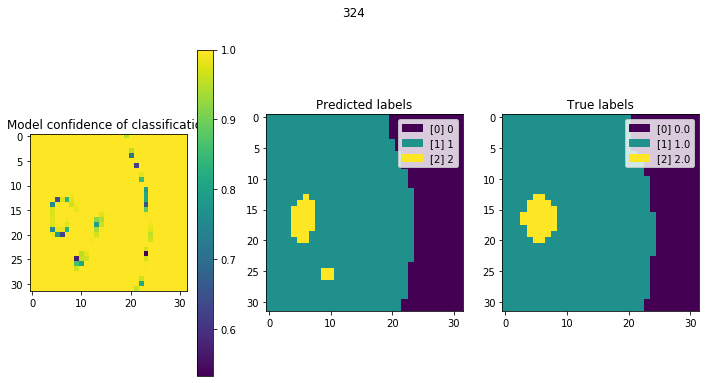

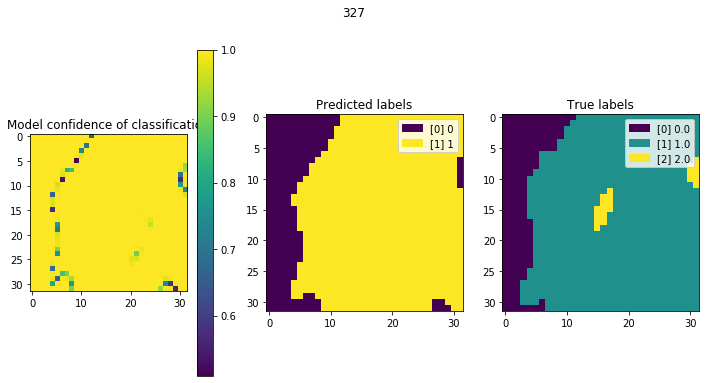

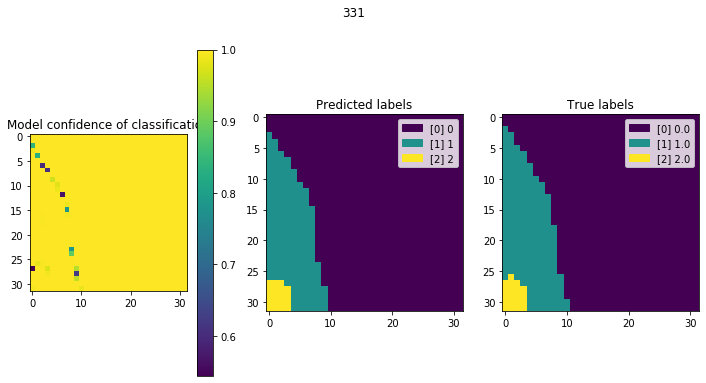

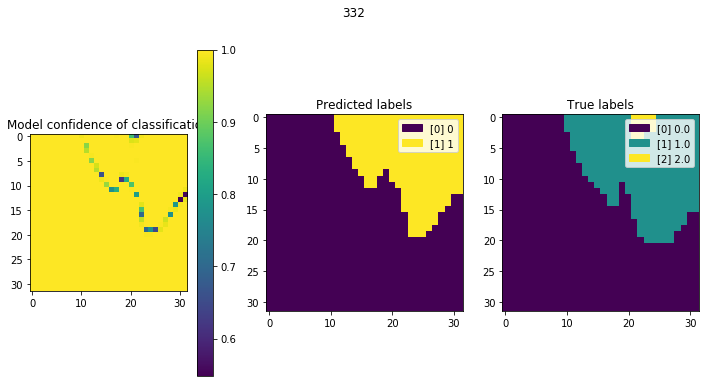

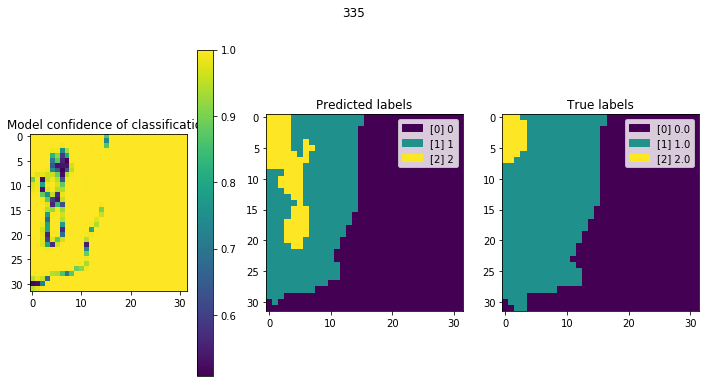

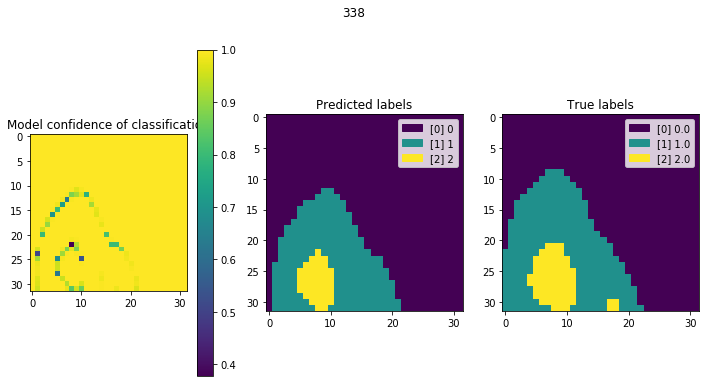

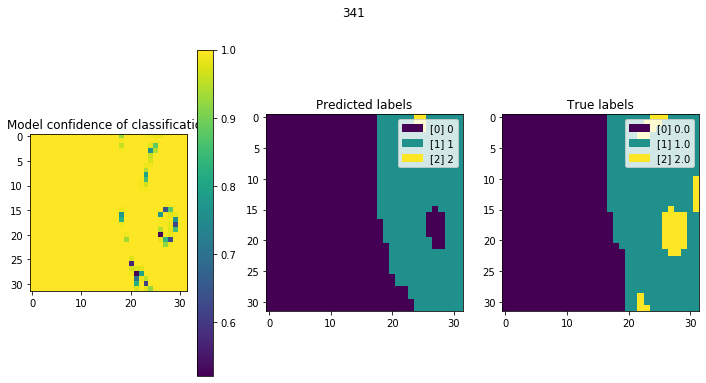

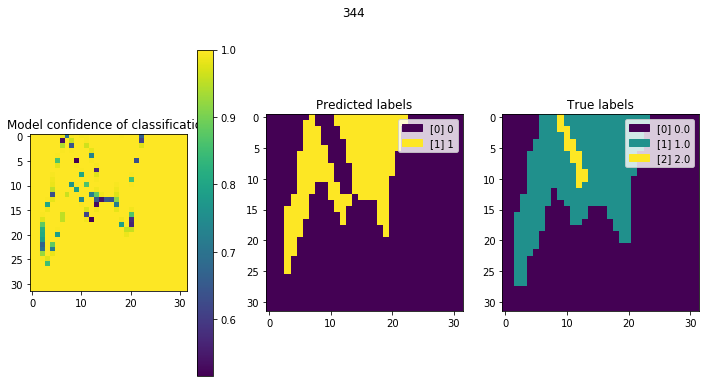

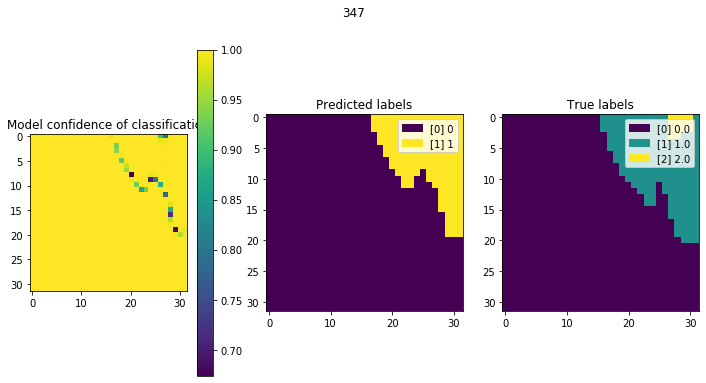

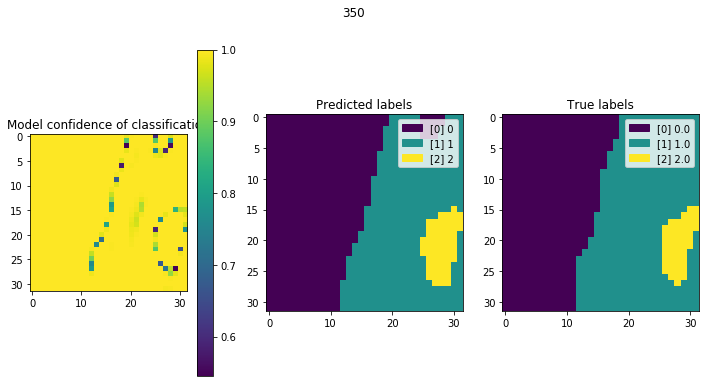

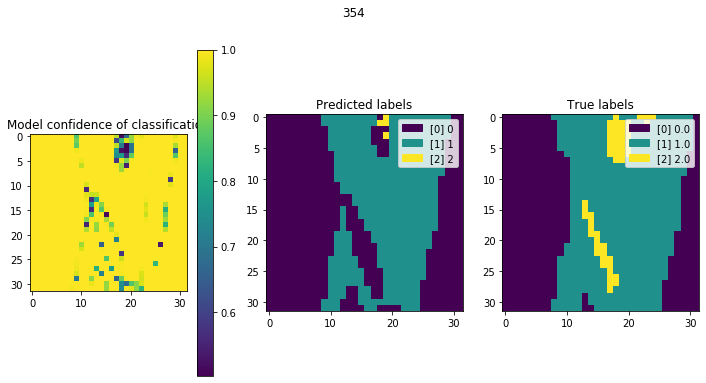

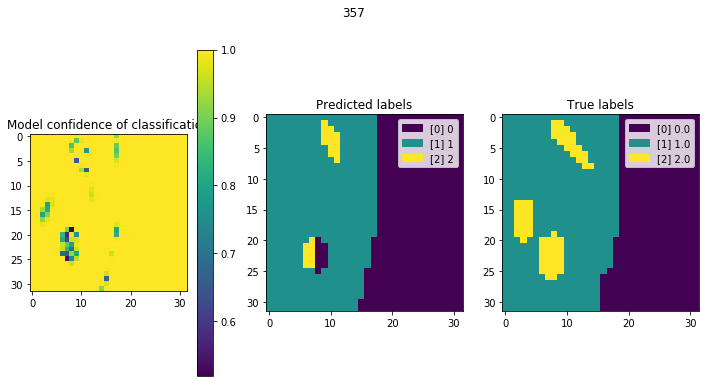

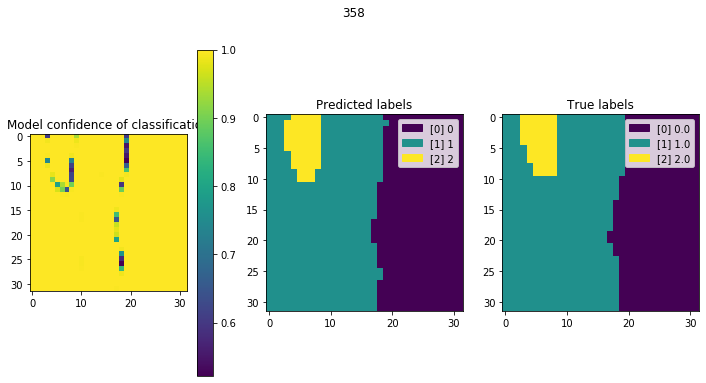

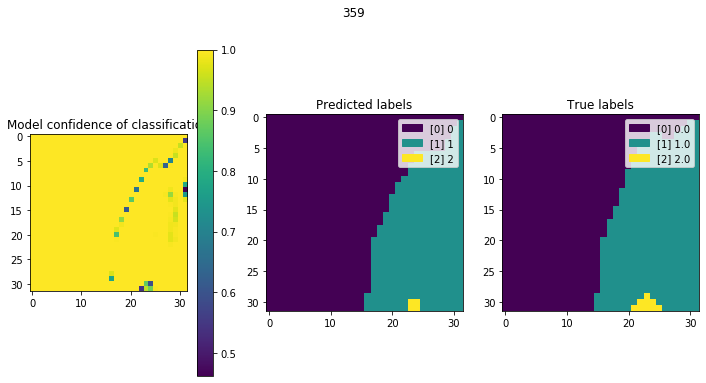

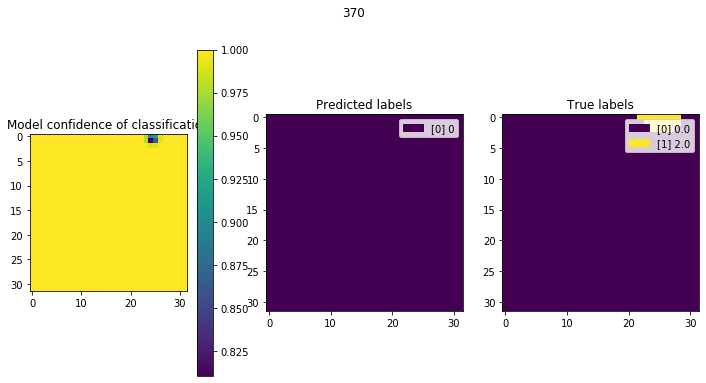

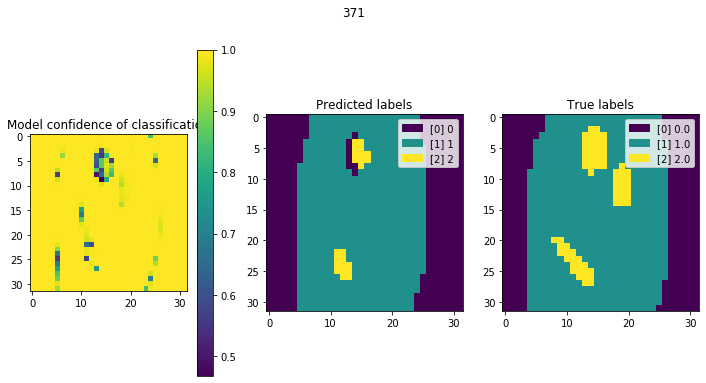

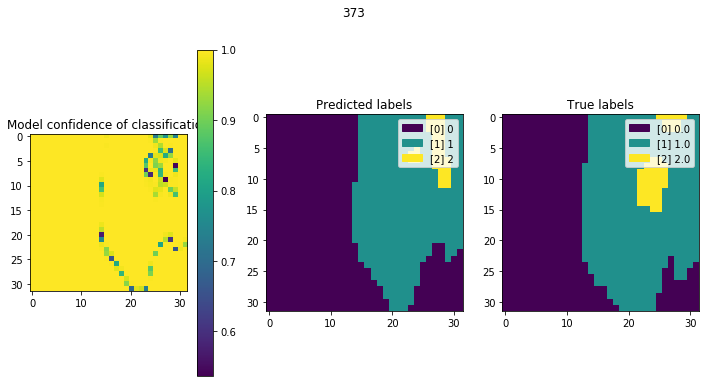

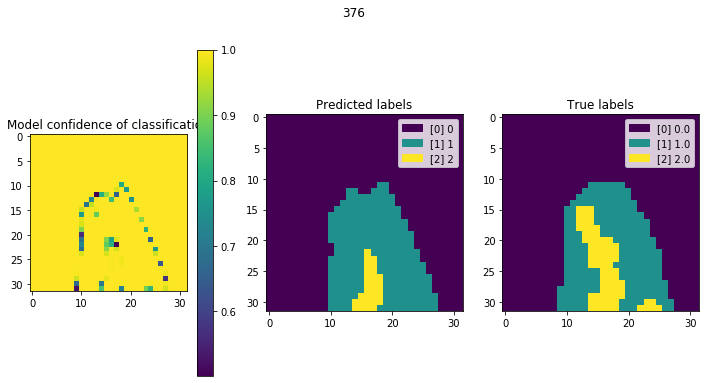

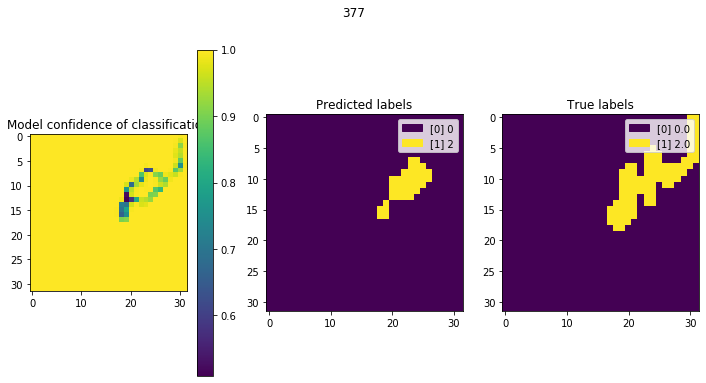

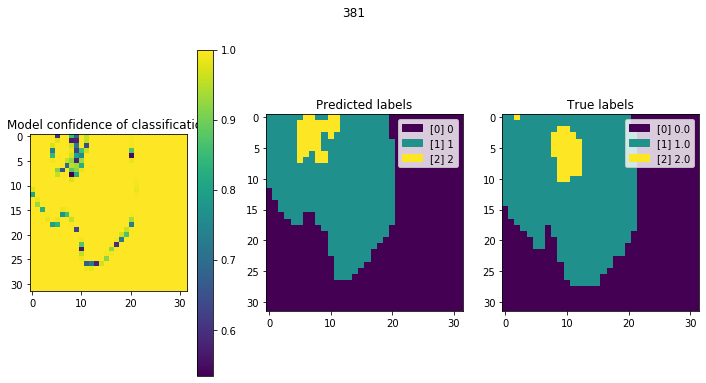

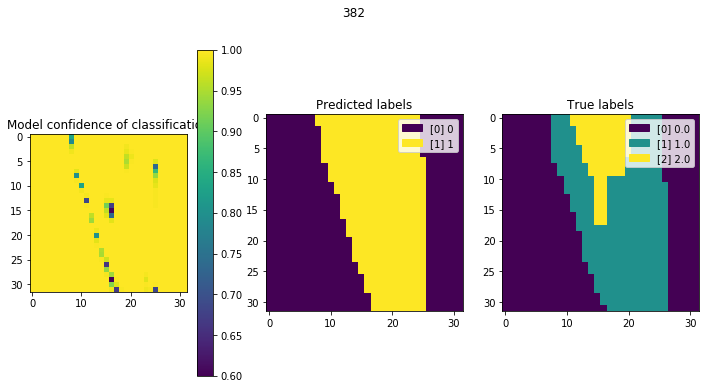

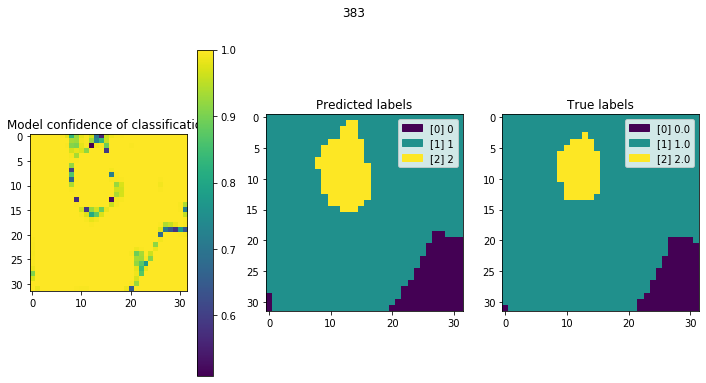

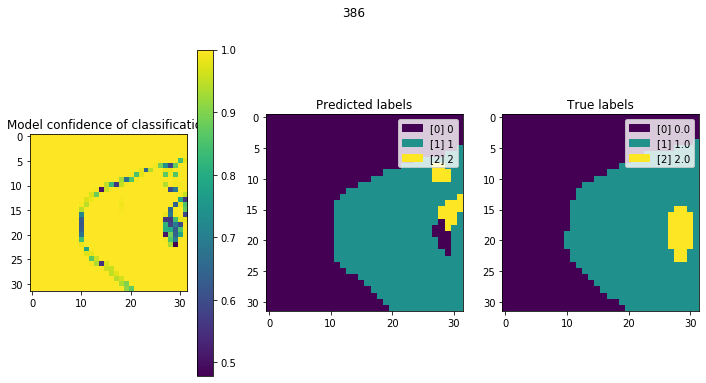

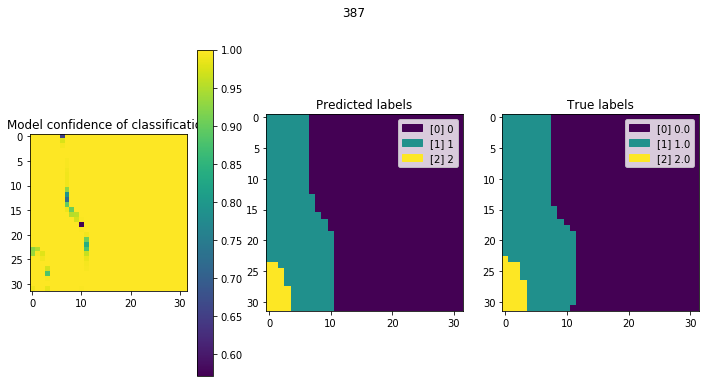

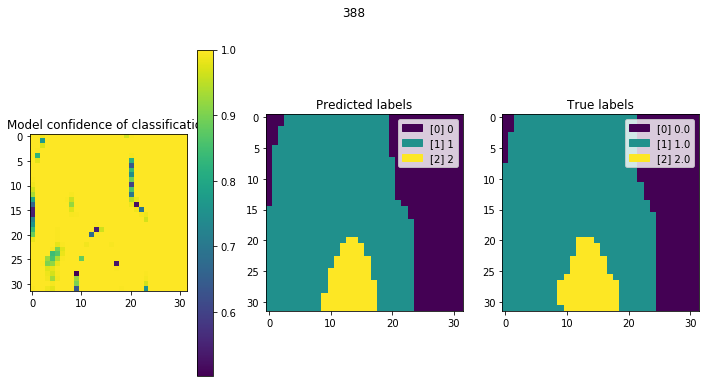

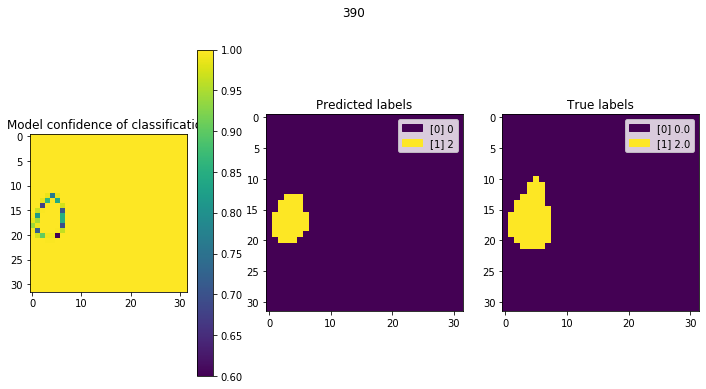

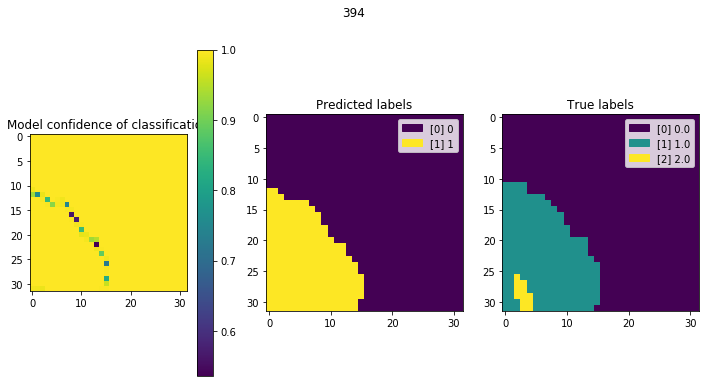

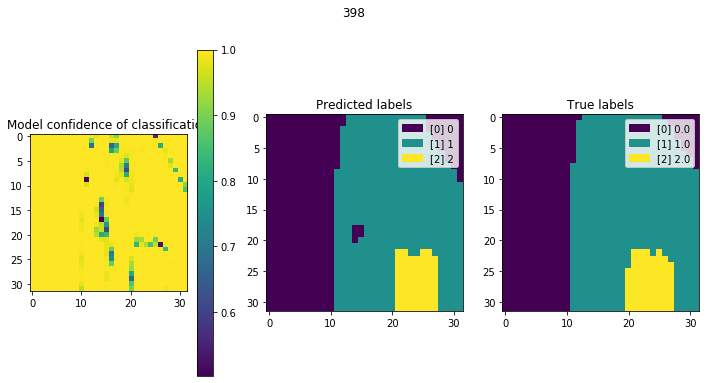

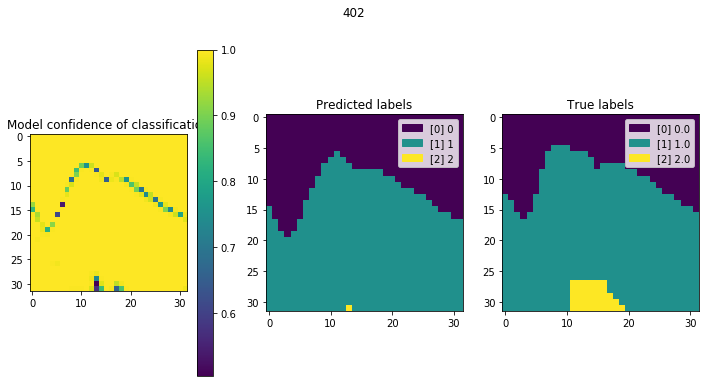

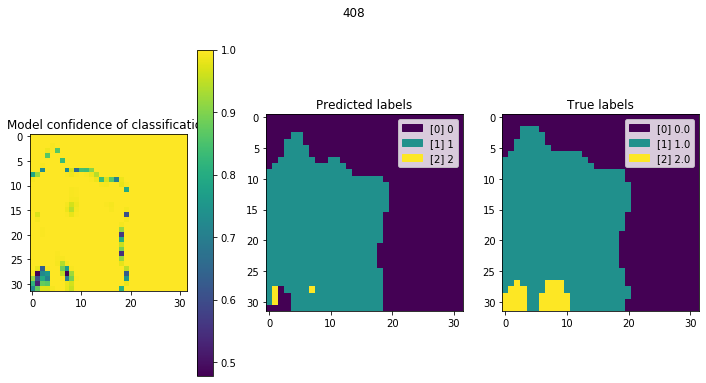

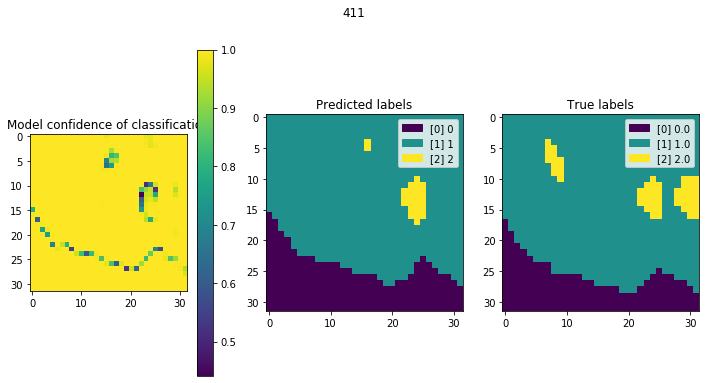

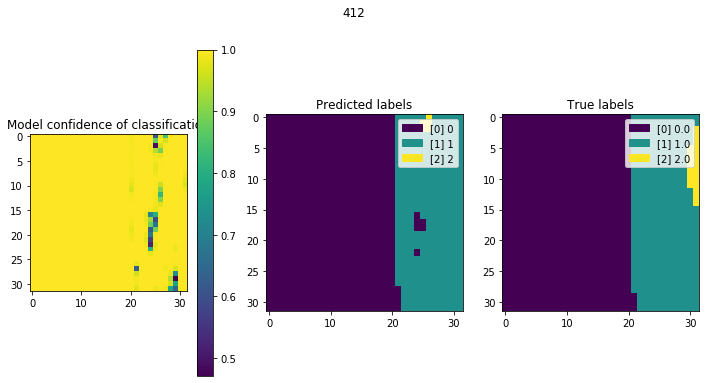

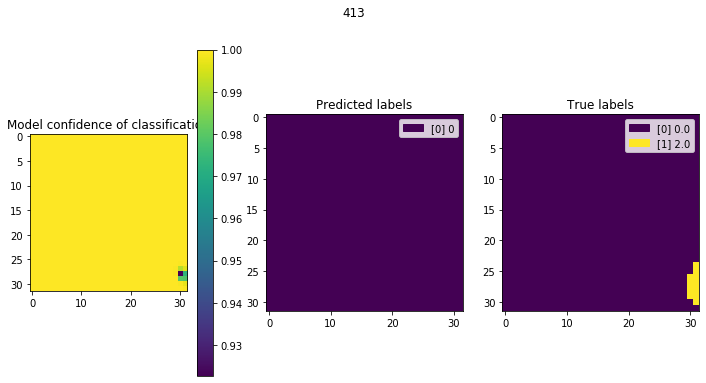

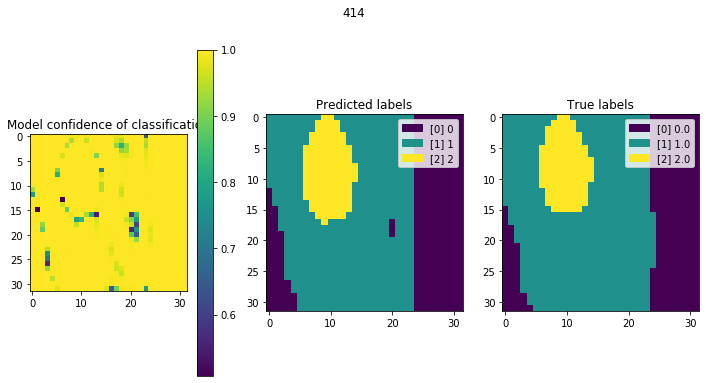

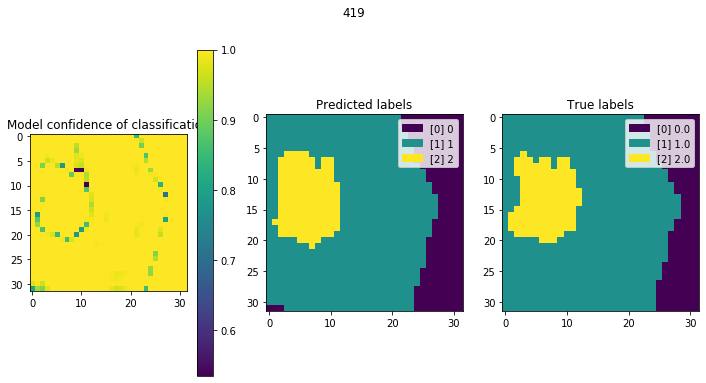

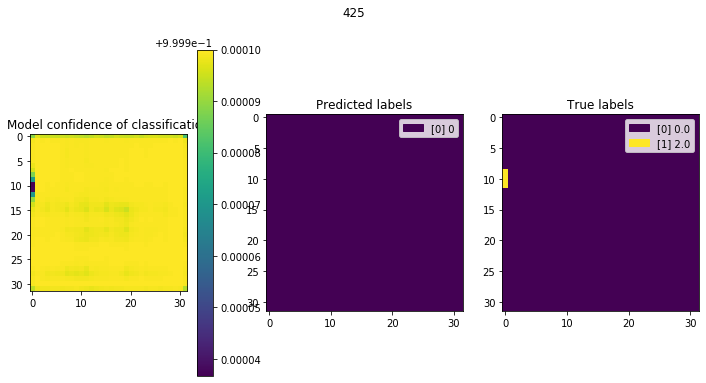

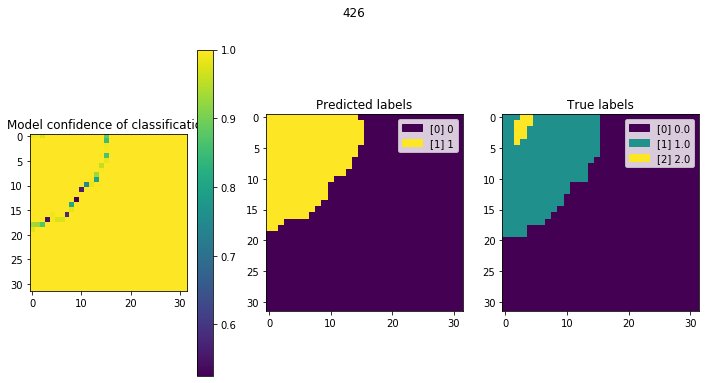

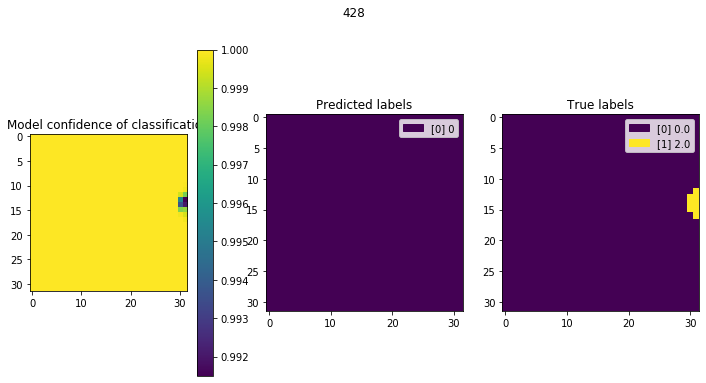

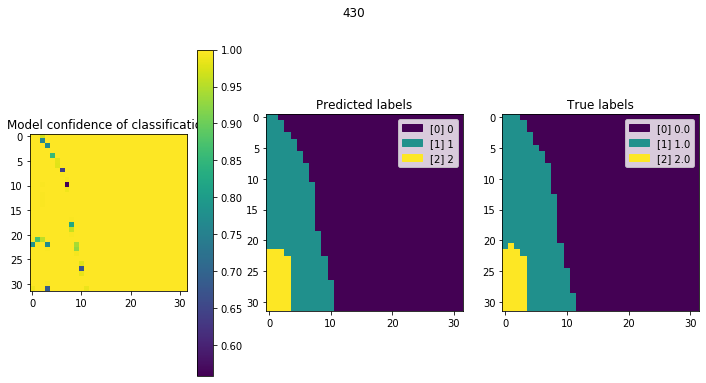

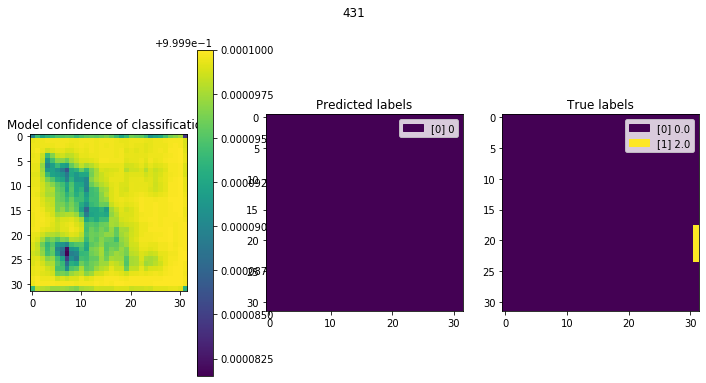

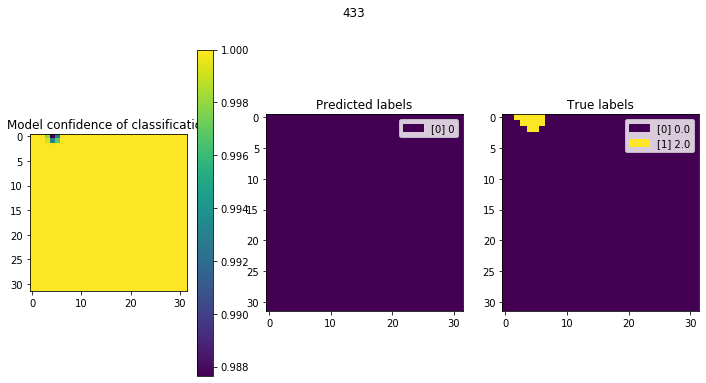

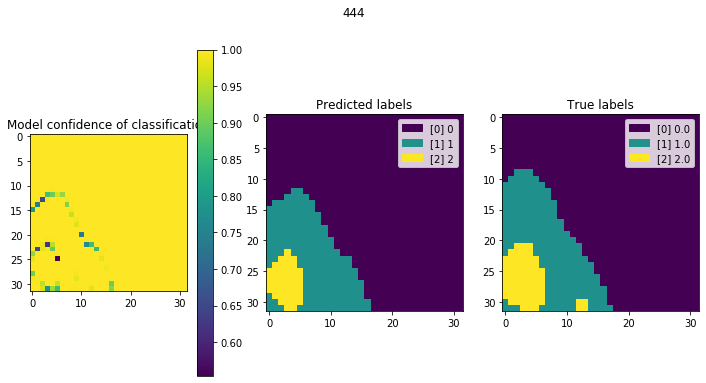

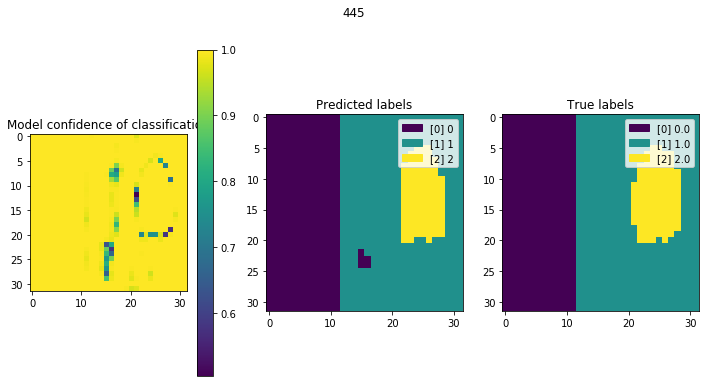

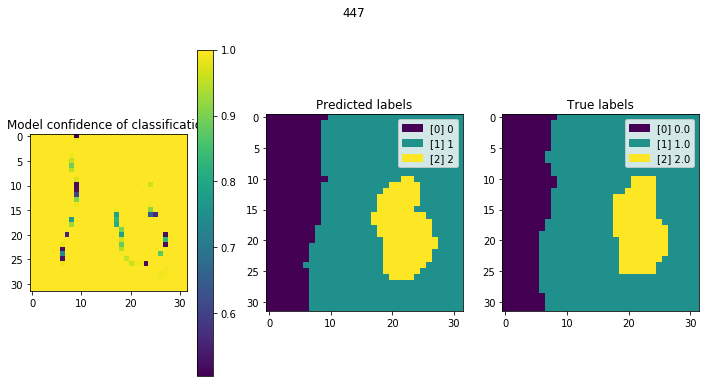

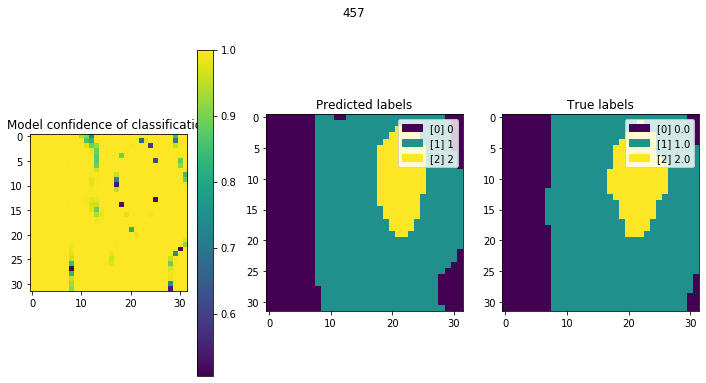

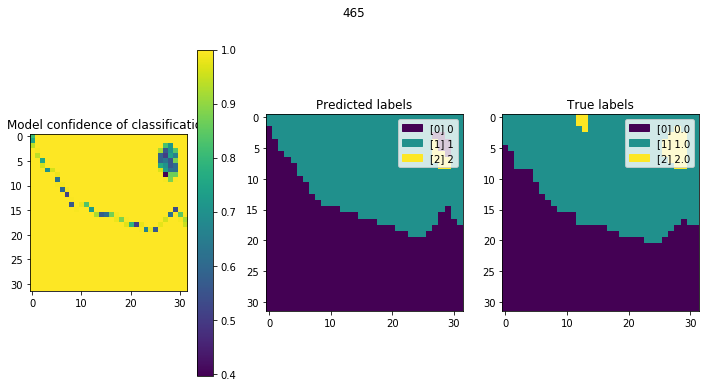

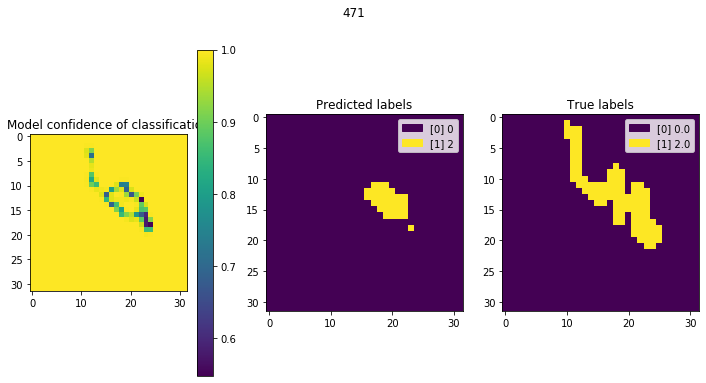

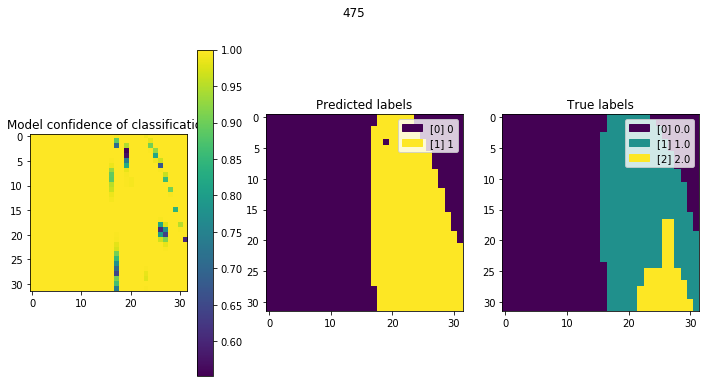

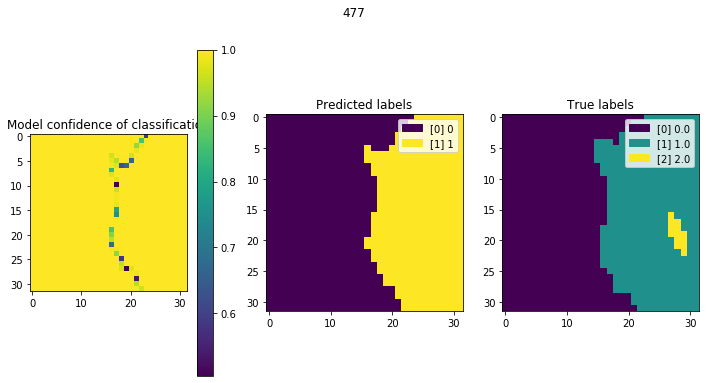

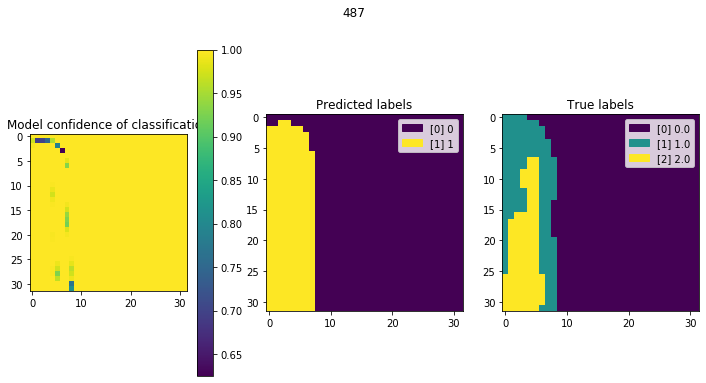

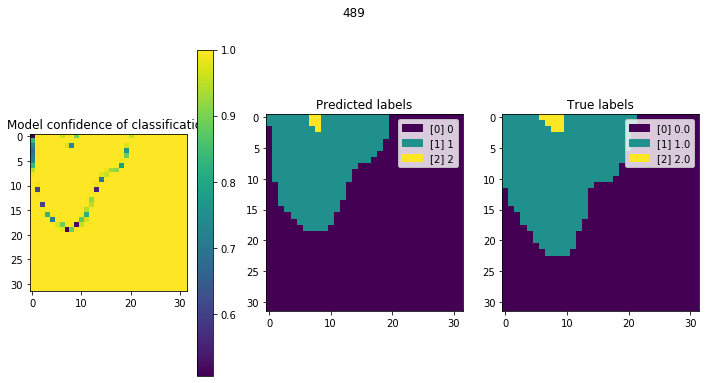

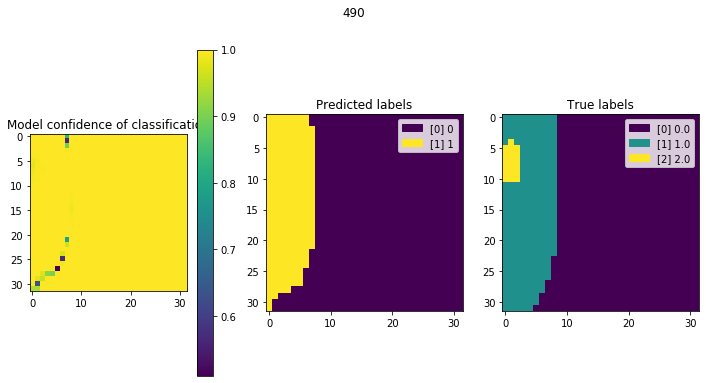

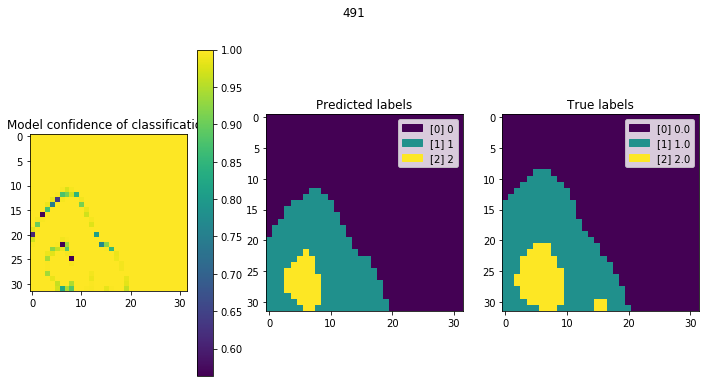

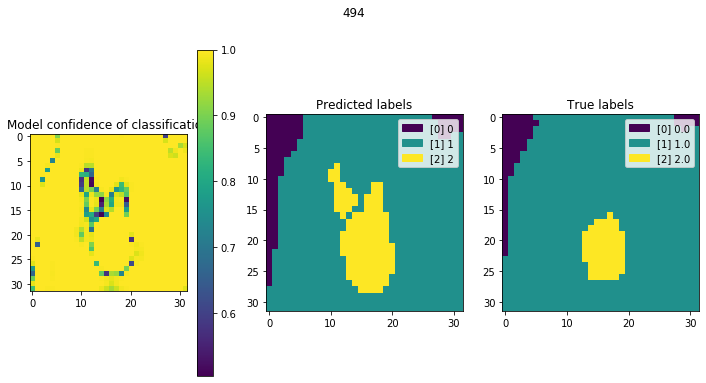

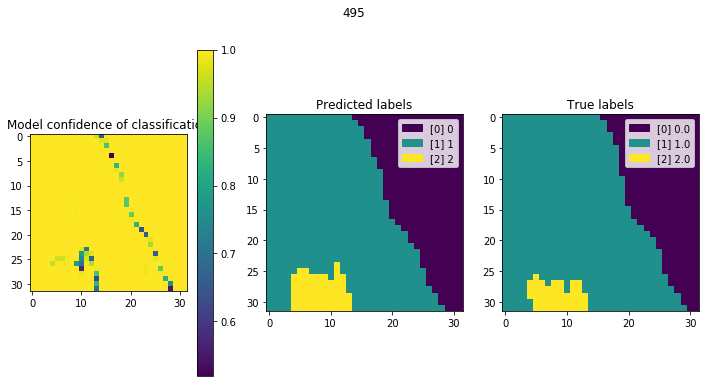

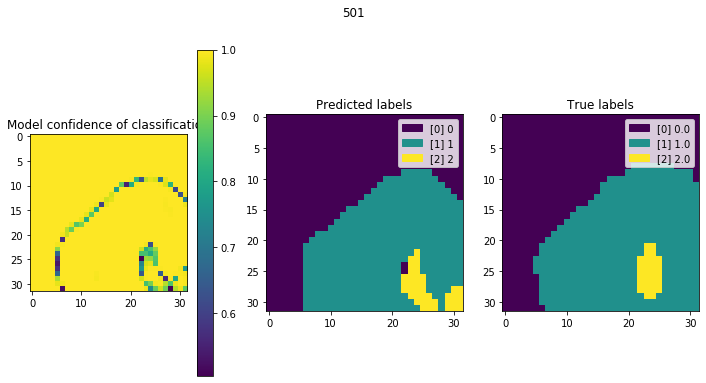

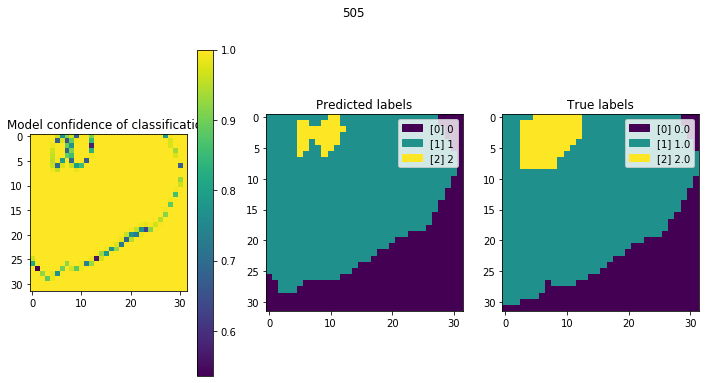

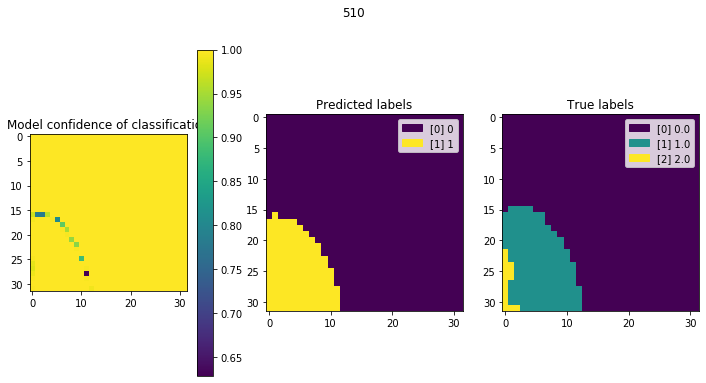

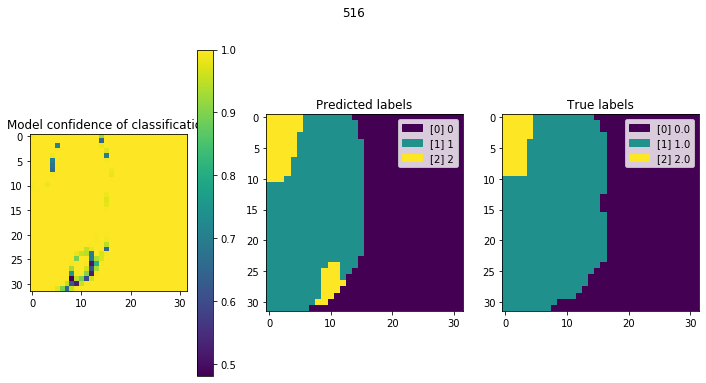

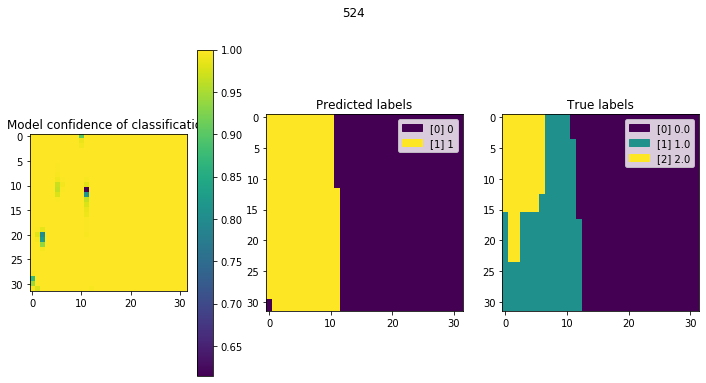

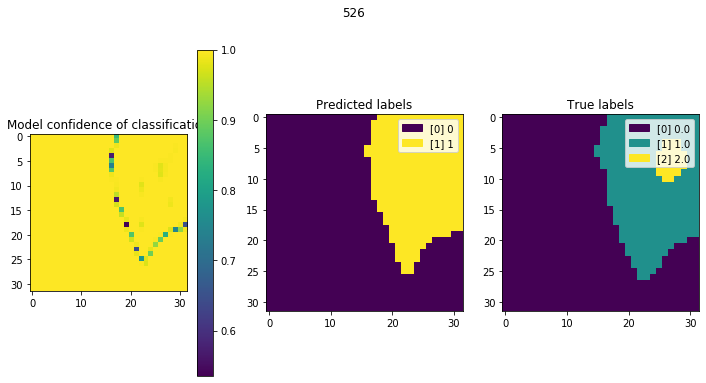

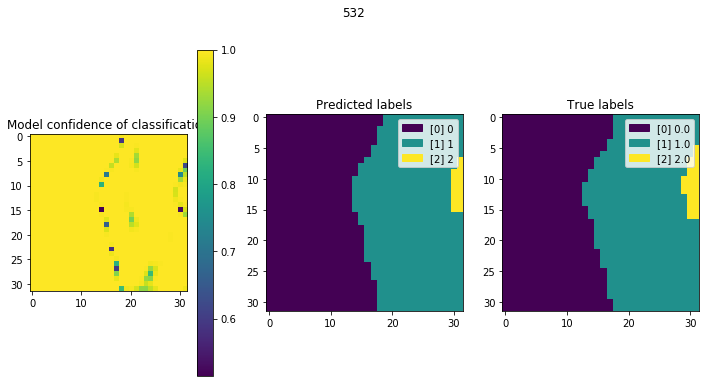

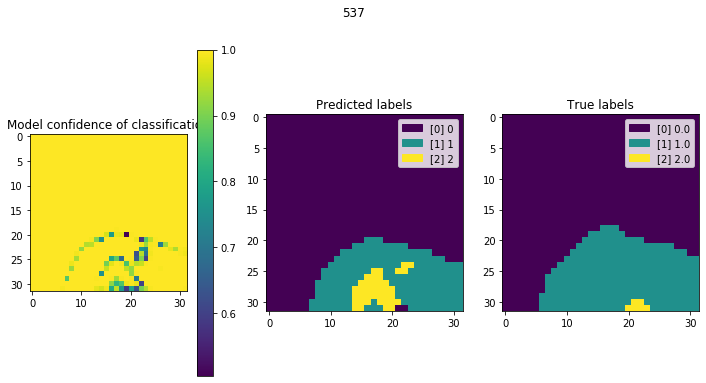

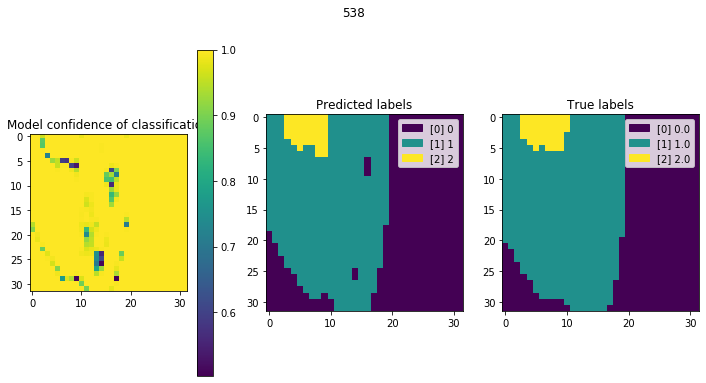

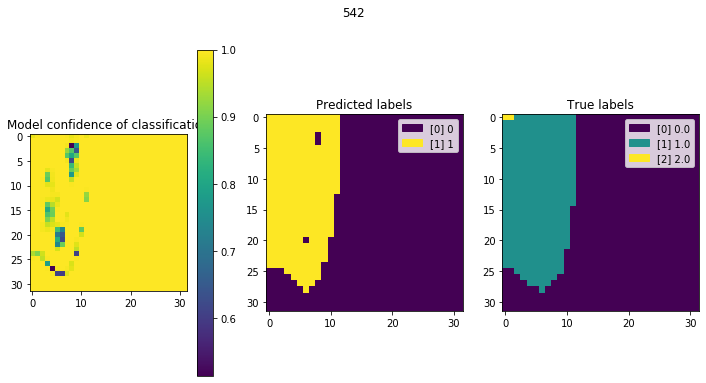

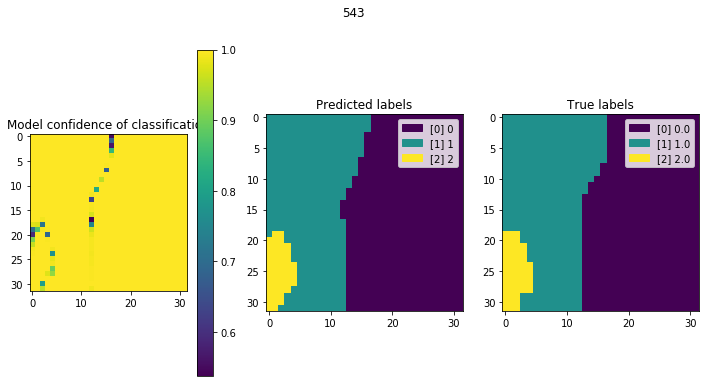

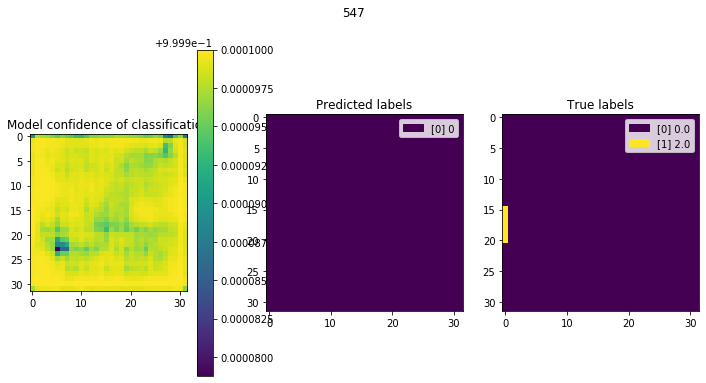

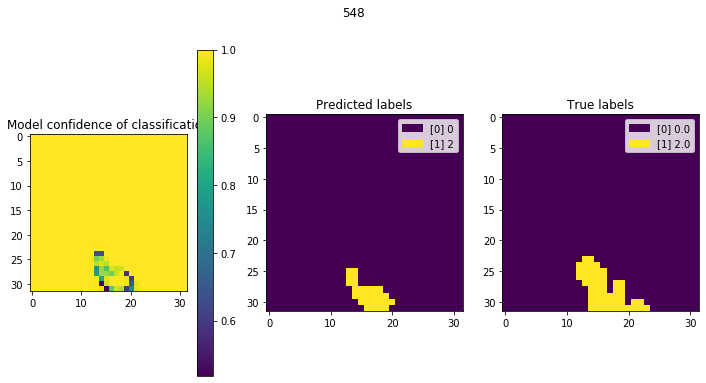

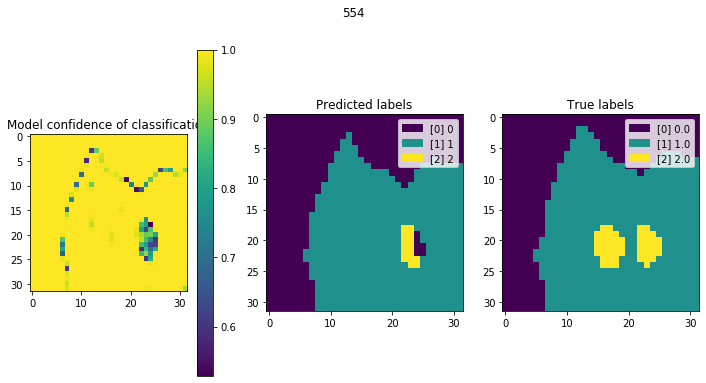

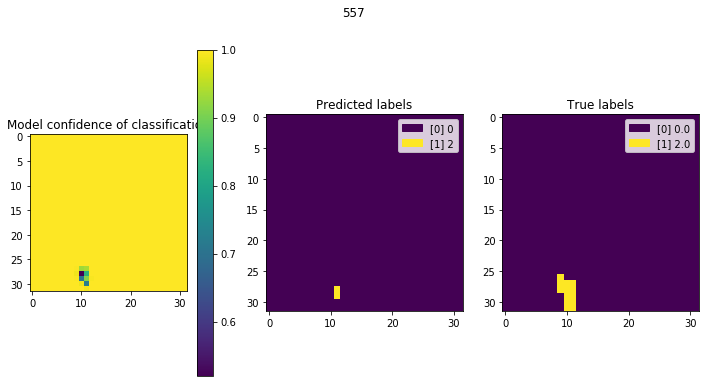

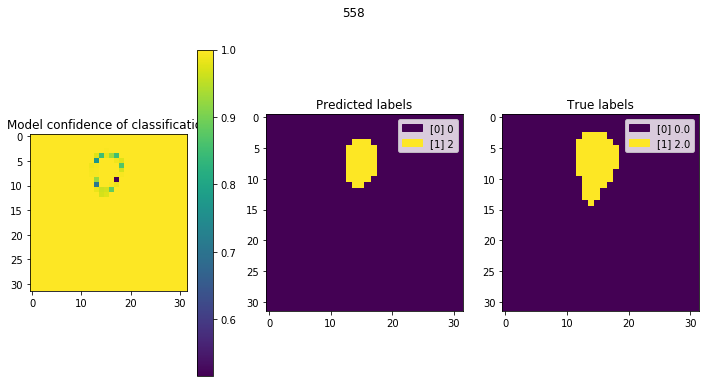

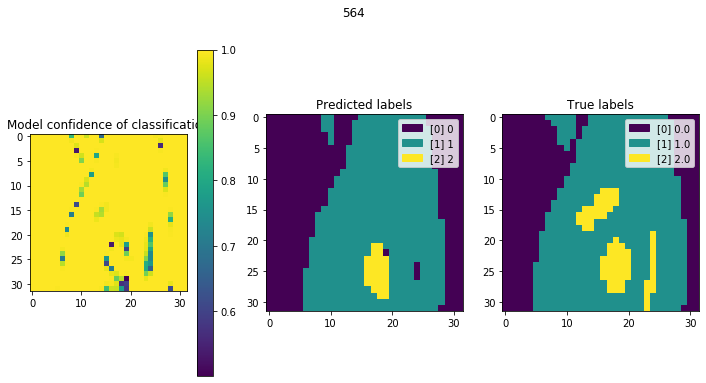

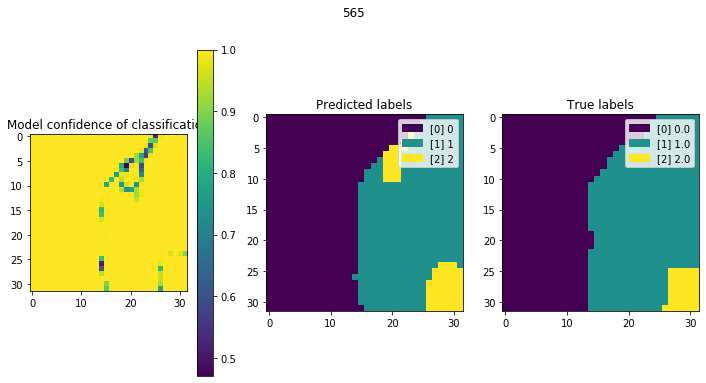

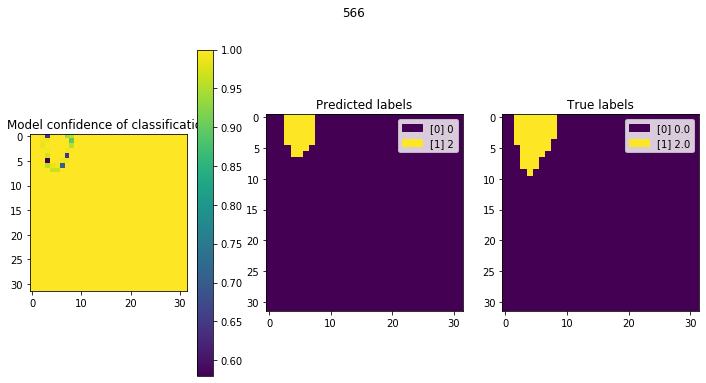

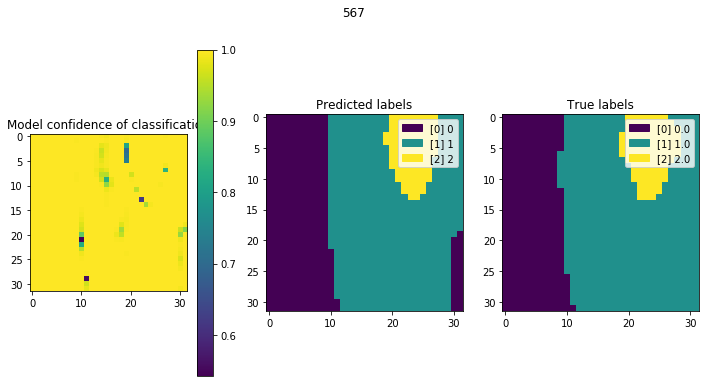

In [14]:
def get_classification_heat_map(y_hat, heat_maps):
    heat = np.zeros(y_hat.shape)
    heat[y_hat == 0] = heat_maps[..., 0][y_hat == 0]
    heat[y_hat == 1] = heat_maps[..., 1][y_hat == 1]
    heat[y_hat == 2] = heat_maps[..., 2][y_hat == 2]
    return heat

def plot_with_heat_map(y_hat, heat_maps, y):
    heat = get_classification_heat_map(y_hat, heat_maps)

    plt.figure(figsize=(12, 6))
    plt.subplot(131)
    plt.imshow(heat)
    plt.colorbar()
    plt.title("Model confidence of classification")
    plt.subplot(132)
    img = plt.imshow(y_hat)
    mypackage.Dataset._Dataset__add_legend_to_image(y_hat, img)
    plt.title("Predicted labels")
    plt.subplot(133)
    img = plt.imshow(np.squeeze(y))
    mypackage.Dataset._Dataset__add_legend_to_image(y, img)
    plt.title("True labels")

# y_pred_test, y_pred_heat = unet.predict(X_test[..., channels_used], Y_labels=Y_test, return_heat_map=True);
for i in range(len(Y_test)):
    if 2 in Y_test[i]:
        plot_with_heat_map(y_pred_test[i], y_pred_heat[i], Y_test[i])
        plt.suptitle(i)
        

In [15]:
# # https://stackoverflow.com/questions/38009682/how-to-tell-if-tensorflow-is-using-gpu-acceleration-from-inside-python-shell
# import tensorflow as tf
# from tensorflow.python.client import device_lib

# print(device_lib.list_local_devices())
# print("The following list should not be empty")
# print(tf.test.gpu_device_name())
# print("The following should contain stuff, and then be True, True")
# print(tf.config.experimental.list_physical_devices('GPU'), tf.test.is_built_with_cuda(), tf.test.is_gpu_available( cuda_only=False, min_cuda_compute_capability=None))